In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 566)
(1919620, 8)
validation
(288502, 566)
(288502, 8)
test
(221128, 566)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 566)]             0         


 dense (Dense)               (None, 2048)              1161216   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 3949448 (15.07 MB)


Trainable params: 3949448 (15.07 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 3:14 - loss: 2.3136 - STD: 0.1100 - MAE: 0.2190

 2/20 [==>...........................] - ETA: 6s - loss: 2.2131 - STD: 0.0711 - MAE: 0.2189  

 3/20 [===>..........................] - ETA: 6s - loss: 2.1722 - STD: 0.0543 - MAE: 0.2188

 4/20 [=====>........................] - ETA: 5s - loss: 2.1546 - STD: 0.0469 - MAE: 0.2188

 5/20 [======>.......................] - ETA: 5s - loss: 2.1465 - STD: 0.0435 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.1425 - STD: 0.0417 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.1400 - STD: 0.0406 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.1372 - STD: 0.0395 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.1339 - STD: 0.0384 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.1302 - STD: 0.0370 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.1263 - STD: 0.0355 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.1226 - STD: 0.0338 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.1193 - STD: 0.0321 - MAE: 0.2186

14/20 [====================>.........] - ETA: 2s - loss: 2.1164 - STD: 0.0305 - MAE: 0.2186

15/20 [=====================>........] - ETA: 2s - loss: 2.1160 - STD: 0.0293 - MAE: 0.2186

16/20 [=======================>......] - ETA: 2s - loss: 2.1140 - STD: 0.0284 - MAE: 0.2186

17/20 [========================>.....] - ETA: 1s - loss: 2.1124 - STD: 0.0277 - MAE: 0.2187

18/20 [==========================>...] - ETA: 1s - loss: 2.1111 - STD: 0.0272 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1099 - STD: 0.0267 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1087 - STD: 0.0261 - MAE: 0.2187

20/20 [==============================] - 24s 718ms/step - loss: 2.1087 - STD: 0.0261 - MAE: 0.2187 - val_loss: 2.0837 - val_STD: 0.0125 - val_MAE: 0.2187


Epoch 2/10000


 1/20 [>.............................] - ETA: 12s - loss: 2.0835 - STD: 0.0125 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 6s - loss: 2.0823 - STD: 0.0108 - MAE: 0.2187 

 3/20 [===>..........................] - ETA: 5s - loss: 2.0812 - STD: 0.0095 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 5s - loss: 2.0805 - STD: 0.0088 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 5s - loss: 2.0800 - STD: 0.0087 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 4s - loss: 2.0798 - STD: 0.0090 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.0798 - STD: 0.0094 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.0799 - STD: 0.0099 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0801 - STD: 0.0103 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.0803 - STD: 0.0107 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0803 - STD: 0.0109 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.0803 - STD: 0.0110 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.0803 - STD: 0.0110 - MAE: 0.2186

14/20 [====================>.........] - ETA: 2s - loss: 2.0802 - STD: 0.0109 - MAE: 0.2186

15/20 [=====================>........] - ETA: 1s - loss: 2.0802 - STD: 0.0107 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0801 - STD: 0.0104 - MAE: 0.2186

17/20 [========================>.....] - ETA: 1s - loss: 2.0799 - STD: 0.0102 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0798 - STD: 0.0099 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0798 - STD: 0.0098 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0797 - STD: 0.0096 - MAE: 0.2187

20/20 [==============================] - 8s 395ms/step - loss: 2.0797 - STD: 0.0096 - MAE: 0.2187 - val_loss: 2.0781 - val_STD: 0.0078 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 11s - loss: 2.0788 - STD: 0.0078 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 6s - loss: 2.0789 - STD: 0.0080 - MAE: 0.2187 

 3/20 [===>..........................] - ETA: 6s - loss: 2.0789 - STD: 0.0081 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 6s - loss: 2.0789 - STD: 0.0080 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 5s - loss: 2.0788 - STD: 0.0078 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 5s - loss: 2.0787 - STD: 0.0076 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.0786 - STD: 0.0074 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.0786 - STD: 0.0072 - MAE: 0.2187

 9/20 [============>.................] - ETA: 3s - loss: 2.0785 - STD: 0.0071 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.0784 - STD: 0.0071 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0783 - STD: 0.0071 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.0783 - STD: 0.0072 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0783 - STD: 0.0073 - MAE: 0.2187

14/20 [====================>.........] - ETA: 2s - loss: 2.0783 - STD: 0.0074 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.0783 - STD: 0.0075 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0782 - STD: 0.0075 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0782 - STD: 0.0076 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0782 - STD: 0.0076 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0781 - STD: 0.0075 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0781 - STD: 0.0075 - MAE: 0.2187

20/20 [==============================] - 8s 398ms/step - loss: 2.0781 - STD: 0.0075 - MAE: 0.2187 - val_loss: 2.0762 - val_STD: 0.0059 - val_MAE: 0.2186


Epoch 4/10000


 1/20 [>.............................] - ETA: 11s - loss: 2.0775 - STD: 0.0059 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 6s - loss: 2.0772 - STD: 0.0058 - MAE: 0.2186 

 3/20 [===>..........................] - ETA: 5s - loss: 2.0770 - STD: 0.0058 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 5s - loss: 2.0770 - STD: 0.0058 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 4s - loss: 2.0769 - STD: 0.0058 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 4s - loss: 2.0767 - STD: 0.0058 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 3s - loss: 2.0764 - STD: 0.0059 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 3s - loss: 2.0762 - STD: 0.0060 - MAE: 0.2186

 9/20 [============>.................] - ETA: 3s - loss: 2.0759 - STD: 0.0062 - MAE: 0.2186

10/20 [==============>...............] - ETA: 3s - loss: 2.0756 - STD: 0.0064 - MAE: 0.2186

11/20 [===============>..............] - ETA: 2s - loss: 2.0752 - STD: 0.0066 - MAE: 0.2186

12/20 [=================>............] - ETA: 2s - loss: 2.0748 - STD: 0.0067 - MAE: 0.2186

13/20 [==================>...........] - ETA: 2s - loss: 2.0744 - STD: 0.0068 - MAE: 0.2185

14/20 [====================>.........] - ETA: 1s - loss: 2.0738 - STD: 0.0069 - MAE: 0.2185

15/20 [=====================>........] - ETA: 1s - loss: 2.0732 - STD: 0.0069 - MAE: 0.2185

16/20 [=======================>......] - ETA: 1s - loss: 2.0724 - STD: 0.0070 - MAE: 0.2185

17/20 [========================>.....] - ETA: 1s - loss: 2.0714 - STD: 0.0071 - MAE: 0.2185

18/20 [==========================>...] - ETA: 0s - loss: 2.0704 - STD: 0.0073 - MAE: 0.2184

19/20 [===========================>..] - ETA: 0s - loss: 2.0691 - STD: 0.0075 - MAE: 0.2184

20/20 [==============================] - ETA: 0s - loss: 2.0677 - STD: 0.0077 - MAE: 0.2183

20/20 [==============================] - 8s 384ms/step - loss: 2.0677 - STD: 0.0077 - MAE: 0.2183 - val_loss: 2.0403 - val_STD: 0.0144 - val_MAE: 0.2173


Epoch 5/10000


 1/20 [>.............................] - ETA: 11s - loss: 2.0332 - STD: 0.0144 - MAE: 0.2171

 2/20 [==>...........................] - ETA: 6s - loss: 2.0288 - STD: 0.0155 - MAE: 0.2169 

 3/20 [===>..........................] - ETA: 6s - loss: 2.0243 - STD: 0.0168 - MAE: 0.2167

 4/20 [=====>........................] - ETA: 5s - loss: 2.0190 - STD: 0.0183 - MAE: 0.2165

 5/20 [======>.......................] - ETA: 5s - loss: 2.0135 - STD: 0.0199 - MAE: 0.2163

 6/20 [========>.....................] - ETA: 4s - loss: 2.0080 - STD: 0.0219 - MAE: 0.2160

 7/20 [=========>....................] - ETA: 4s - loss: 2.0023 - STD: 0.0239 - MAE: 0.2157

 8/20 [===========>..................] - ETA: 4s - loss: 1.9963 - STD: 0.0261 - MAE: 0.2154

 9/20 [============>.................] - ETA: 3s - loss: 1.9903 - STD: 0.0284 - MAE: 0.2150

10/20 [==============>...............] - ETA: 3s - loss: 1.9845 - STD: 0.0306 - MAE: 0.2147

11/20 [===============>..............] - ETA: 3s - loss: 1.9790 - STD: 0.0329 - MAE: 0.2144

12/20 [=================>............] - ETA: 2s - loss: 1.9737 - STD: 0.0350 - MAE: 0.2140

13/20 [==================>...........] - ETA: 2s - loss: 1.9727 - STD: 0.0371 - MAE: 0.2137

14/20 [====================>.........] - ETA: 2s - loss: 1.9673 - STD: 0.0391 - MAE: 0.2134

15/20 [=====================>........] - ETA: 1s - loss: 1.9622 - STD: 0.0410 - MAE: 0.2130

16/20 [=======================>......] - ETA: 1s - loss: 1.9572 - STD: 0.0427 - MAE: 0.2127

17/20 [========================>.....] - ETA: 1s - loss: 1.9526 - STD: 0.0443 - MAE: 0.2125

18/20 [==========================>...] - ETA: 0s - loss: 1.9486 - STD: 0.0456 - MAE: 0.2122

19/20 [===========================>..] - ETA: 0s - loss: 1.9446 - STD: 0.0470 - MAE: 0.2120

20/20 [==============================] - ETA: 0s - loss: 1.9405 - STD: 0.0483 - MAE: 0.2117

20/20 [==============================] - 8s 390ms/step - loss: 1.9405 - STD: 0.0483 - MAE: 0.2117 - val_loss: 1.8981 - val_STD: 0.0730 - val_MAE: 0.2079


Epoch 6/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.8638 - STD: 0.0746 - MAE: 0.2066

 2/20 [==>...........................] - ETA: 6s - loss: 1.8632 - STD: 0.0762 - MAE: 0.2063 

 3/20 [===>..........................] - ETA: 5s - loss: 1.8617 - STD: 0.0765 - MAE: 0.2062

 4/20 [=====>........................] - ETA: 5s - loss: 1.8605 - STD: 0.0770 - MAE: 0.2061

 5/20 [======>.......................] - ETA: 5s - loss: 1.8576 - STD: 0.0772 - MAE: 0.2060

 6/20 [========>.....................] - ETA: 4s - loss: 1.8555 - STD: 0.0774 - MAE: 0.2059

 7/20 [=========>....................] - ETA: 4s - loss: 1.8538 - STD: 0.0777 - MAE: 0.2058

 8/20 [===========>..................] - ETA: 4s - loss: 1.8520 - STD: 0.0780 - MAE: 0.2057

 9/20 [============>.................] - ETA: 3s - loss: 1.8503 - STD: 0.0785 - MAE: 0.2056

10/20 [==============>...............] - ETA: 3s - loss: 1.8488 - STD: 0.0787 - MAE: 0.2055

11/20 [===============>..............] - ETA: 3s - loss: 1.8472 - STD: 0.0792 - MAE: 0.2054

12/20 [=================>............] - ETA: 2s - loss: 1.8459 - STD: 0.0793 - MAE: 0.2053

13/20 [==================>...........] - ETA: 2s - loss: 1.8456 - STD: 0.0798 - MAE: 0.2052

14/20 [====================>.........] - ETA: 2s - loss: 1.8436 - STD: 0.0800 - MAE: 0.2051

15/20 [=====================>........] - ETA: 1s - loss: 1.8413 - STD: 0.0803 - MAE: 0.2050

16/20 [=======================>......] - ETA: 1s - loss: 1.8397 - STD: 0.0809 - MAE: 0.2049

17/20 [========================>.....] - ETA: 1s - loss: 1.8386 - STD: 0.0811 - MAE: 0.2048

18/20 [==========================>...] - ETA: 0s - loss: 1.8364 - STD: 0.0816 - MAE: 0.2047

19/20 [===========================>..] - ETA: 0s - loss: 1.8343 - STD: 0.0819 - MAE: 0.2046

20/20 [==============================] - ETA: 0s - loss: 1.8328 - STD: 0.0821 - MAE: 0.2045

20/20 [==============================] - 8s 396ms/step - loss: 1.8328 - STD: 0.0821 - MAE: 0.2045 - val_loss: 1.8250 - val_STD: 0.0894 - val_MAE: 0.2030


Epoch 7/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.7936 - STD: 0.0903 - MAE: 0.2019

 2/20 [==>...........................] - ETA: 6s - loss: 1.7884 - STD: 0.0901 - MAE: 0.2018 

 3/20 [===>..........................] - ETA: 6s - loss: 1.7882 - STD: 0.0897 - MAE: 0.2019

 4/20 [=====>........................] - ETA: 5s - loss: 1.7869 - STD: 0.0907 - MAE: 0.2017

 5/20 [======>.......................] - ETA: 5s - loss: 1.7842 - STD: 0.0907 - MAE: 0.2016

 6/20 [========>.....................] - ETA: 5s - loss: 1.7810 - STD: 0.0907 - MAE: 0.2015

 7/20 [=========>....................] - ETA: 4s - loss: 1.7792 - STD: 0.0912 - MAE: 0.2014

 8/20 [===========>..................] - ETA: 4s - loss: 1.7779 - STD: 0.0911 - MAE: 0.2014

 9/20 [============>.................] - ETA: 3s - loss: 1.7772 - STD: 0.0915 - MAE: 0.2012

10/20 [==============>...............] - ETA: 3s - loss: 1.7734 - STD: 0.0917 - MAE: 0.2010

11/20 [===============>..............] - ETA: 3s - loss: 1.7707 - STD: 0.0919 - MAE: 0.2010

12/20 [=================>............] - ETA: 2s - loss: 1.7700 - STD: 0.0924 - MAE: 0.2008

13/20 [==================>...........] - ETA: 2s - loss: 1.7699 - STD: 0.0925 - MAE: 0.2008

14/20 [====================>.........] - ETA: 2s - loss: 1.7668 - STD: 0.0928 - MAE: 0.2007

15/20 [=====================>........] - ETA: 1s - loss: 1.7641 - STD: 0.0931 - MAE: 0.2006

16/20 [=======================>......] - ETA: 1s - loss: 1.7634 - STD: 0.0932 - MAE: 0.2005

17/20 [========================>.....] - ETA: 1s - loss: 1.7607 - STD: 0.0935 - MAE: 0.2004

18/20 [==========================>...] - ETA: 0s - loss: 1.7582 - STD: 0.0938 - MAE: 0.2003

19/20 [===========================>..] - ETA: 0s - loss: 1.7572 - STD: 0.0940 - MAE: 0.2002

20/20 [==============================] - ETA: 0s - loss: 1.7544 - STD: 0.0942 - MAE: 0.2001

20/20 [==============================] - 8s 409ms/step - loss: 1.7544 - STD: 0.0942 - MAE: 0.2001 - val_loss: 1.7520 - val_STD: 0.0978 - val_MAE: 0.1995


Epoch 8/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.7177 - STD: 0.0998 - MAE: 0.1980

 2/20 [==>...........................] - ETA: 6s - loss: 1.7212 - STD: 0.0989 - MAE: 0.1983 

 3/20 [===>..........................] - ETA: 6s - loss: 1.7107 - STD: 0.0989 - MAE: 0.1980

 4/20 [=====>........................] - ETA: 5s - loss: 1.7128 - STD: 0.0994 - MAE: 0.1979

 5/20 [======>.......................] - ETA: 5s - loss: 1.7115 - STD: 0.0994 - MAE: 0.1979

 6/20 [========>.....................] - ETA: 5s - loss: 1.7084 - STD: 0.0993 - MAE: 0.1978

 7/20 [=========>....................] - ETA: 4s - loss: 1.7092 - STD: 0.0996 - MAE: 0.1978

 8/20 [===========>..................] - ETA: 4s - loss: 1.7069 - STD: 0.0997 - MAE: 0.1977

 9/20 [============>.................] - ETA: 4s - loss: 1.7054 - STD: 0.0998 - MAE: 0.1976

10/20 [==============>...............] - ETA: 3s - loss: 1.7046 - STD: 0.1000 - MAE: 0.1976

11/20 [===============>..............] - ETA: 3s - loss: 1.7025 - STD: 0.1002 - MAE: 0.1975

12/20 [=================>............] - ETA: 2s - loss: 1.7016 - STD: 0.1004 - MAE: 0.1974

13/20 [==================>...........] - ETA: 2s - loss: 1.7000 - STD: 0.1006 - MAE: 0.1973

14/20 [====================>.........] - ETA: 2s - loss: 1.6986 - STD: 0.1007 - MAE: 0.1972

15/20 [=====================>........] - ETA: 1s - loss: 1.6976 - STD: 0.1009 - MAE: 0.1972

16/20 [=======================>......] - ETA: 1s - loss: 1.6961 - STD: 0.1011 - MAE: 0.1971

17/20 [========================>.....] - ETA: 1s - loss: 1.6951 - STD: 0.1013 - MAE: 0.1970

18/20 [==========================>...] - ETA: 0s - loss: 1.6943 - STD: 0.1015 - MAE: 0.1969

19/20 [===========================>..] - ETA: 0s - loss: 1.6941 - STD: 0.1017 - MAE: 0.1969

20/20 [==============================] - ETA: 0s - loss: 1.6931 - STD: 0.1020 - MAE: 0.1968

20/20 [==============================] - 9s 436ms/step - loss: 1.6931 - STD: 0.1020 - MAE: 0.1968 - val_loss: 1.6897 - val_STD: 0.1030 - val_MAE: 0.1966


Epoch 9/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.6714 - STD: 0.1064 - MAE: 0.1952

 2/20 [==>...........................] - ETA: 7s - loss: 1.6675 - STD: 0.1066 - MAE: 0.1950 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6683 - STD: 0.1070 - MAE: 0.1950

 4/20 [=====>........................] - ETA: 6s - loss: 1.6690 - STD: 0.1071 - MAE: 0.1950

 5/20 [======>.......................] - ETA: 5s - loss: 1.6680 - STD: 0.1071 - MAE: 0.1950

 6/20 [========>.....................] - ETA: 5s - loss: 1.6672 - STD: 0.1073 - MAE: 0.1949

 7/20 [=========>....................] - ETA: 5s - loss: 1.6665 - STD: 0.1074 - MAE: 0.1949

 8/20 [===========>..................] - ETA: 4s - loss: 1.6658 - STD: 0.1075 - MAE: 0.1948

 9/20 [============>.................] - ETA: 4s - loss: 1.6654 - STD: 0.1077 - MAE: 0.1948

10/20 [==============>...............] - ETA: 3s - loss: 1.6650 - STD: 0.1078 - MAE: 0.1947

11/20 [===============>..............] - ETA: 3s - loss: 1.6639 - STD: 0.1079 - MAE: 0.1947

12/20 [=================>............] - ETA: 3s - loss: 1.6638 - STD: 0.1081 - MAE: 0.1946

13/20 [==================>...........] - ETA: 2s - loss: 1.6635 - STD: 0.1082 - MAE: 0.1946

14/20 [====================>.........] - ETA: 2s - loss: 1.6626 - STD: 0.1083 - MAE: 0.1945

15/20 [=====================>........] - ETA: 1s - loss: 1.6619 - STD: 0.1084 - MAE: 0.1945

16/20 [=======================>......] - ETA: 1s - loss: 1.6613 - STD: 0.1084 - MAE: 0.1945

17/20 [========================>.....] - ETA: 1s - loss: 1.6613 - STD: 0.1085 - MAE: 0.1944

18/20 [==========================>...] - ETA: 0s - loss: 1.6605 - STD: 0.1086 - MAE: 0.1944

19/20 [===========================>..] - ETA: 0s - loss: 1.6597 - STD: 0.1086 - MAE: 0.1944

20/20 [==============================] - ETA: 0s - loss: 1.6593 - STD: 0.1088 - MAE: 0.1943

20/20 [==============================] - 9s 435ms/step - loss: 1.6593 - STD: 0.1088 - MAE: 0.1943 - val_loss: 1.6592 - val_STD: 0.1078 - val_MAE: 0.1945


Epoch 10/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.6461 - STD: 0.1107 - MAE: 0.1934

 2/20 [==>...........................] - ETA: 6s - loss: 1.6442 - STD: 0.1108 - MAE: 0.1933 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6427 - STD: 0.1108 - MAE: 0.1933

 4/20 [=====>........................] - ETA: 5s - loss: 1.6431 - STD: 0.1106 - MAE: 0.1933

 5/20 [======>.......................] - ETA: 4s - loss: 1.6427 - STD: 0.1108 - MAE: 0.1932

 6/20 [========>.....................] - ETA: 4s - loss: 1.6418 - STD: 0.1109 - MAE: 0.1932

 7/20 [=========>....................] - ETA: 4s - loss: 1.6416 - STD: 0.1111 - MAE: 0.1931

 8/20 [===========>..................] - ETA: 4s - loss: 1.6411 - STD: 0.1113 - MAE: 0.1931

 9/20 [============>.................] - ETA: 3s - loss: 1.6409 - STD: 0.1113 - MAE: 0.1931

10/20 [==============>...............] - ETA: 3s - loss: 1.6402 - STD: 0.1114 - MAE: 0.1930

11/20 [===============>..............] - ETA: 3s - loss: 1.6398 - STD: 0.1114 - MAE: 0.1930

12/20 [=================>............] - ETA: 2s - loss: 1.6390 - STD: 0.1115 - MAE: 0.1929

13/20 [==================>...........] - ETA: 2s - loss: 1.6383 - STD: 0.1116 - MAE: 0.1929

14/20 [====================>.........] - ETA: 2s - loss: 1.6376 - STD: 0.1116 - MAE: 0.1929

15/20 [=====================>........] - ETA: 1s - loss: 1.6373 - STD: 0.1117 - MAE: 0.1928

16/20 [=======================>......] - ETA: 1s - loss: 1.6371 - STD: 0.1117 - MAE: 0.1928

17/20 [========================>.....] - ETA: 1s - loss: 1.6371 - STD: 0.1119 - MAE: 0.1928

18/20 [==========================>...] - ETA: 0s - loss: 1.6371 - STD: 0.1120 - MAE: 0.1928

19/20 [===========================>..] - ETA: 0s - loss: 1.6367 - STD: 0.1121 - MAE: 0.1927

20/20 [==============================] - ETA: 0s - loss: 1.6357 - STD: 0.1122 - MAE: 0.1927

20/20 [==============================] - 9s 427ms/step - loss: 1.6357 - STD: 0.1122 - MAE: 0.1927 - val_loss: 1.6246 - val_STD: 0.1119 - val_MAE: 0.1923


Epoch 11/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.6170 - STD: 0.1138 - MAE: 0.1915

 2/20 [==>...........................] - ETA: 7s - loss: 1.6199 - STD: 0.1149 - MAE: 0.1914 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6225 - STD: 0.1141 - MAE: 0.1916

 4/20 [=====>........................] - ETA: 6s - loss: 1.6212 - STD: 0.1144 - MAE: 0.1915

 5/20 [======>.......................] - ETA: 5s - loss: 1.6188 - STD: 0.1143 - MAE: 0.1914

 6/20 [========>.....................] - ETA: 5s - loss: 1.6170 - STD: 0.1144 - MAE: 0.1913

 7/20 [=========>....................] - ETA: 4s - loss: 1.6157 - STD: 0.1147 - MAE: 0.1912

 8/20 [===========>..................] - ETA: 4s - loss: 1.6151 - STD: 0.1145 - MAE: 0.1912

 9/20 [============>.................] - ETA: 4s - loss: 1.6138 - STD: 0.1147 - MAE: 0.1911

10/20 [==============>...............] - ETA: 3s - loss: 1.6119 - STD: 0.1147 - MAE: 0.1910

11/20 [===============>..............] - ETA: 3s - loss: 1.6114 - STD: 0.1149 - MAE: 0.1909

12/20 [=================>............] - ETA: 2s - loss: 1.6100 - STD: 0.1153 - MAE: 0.1907

13/20 [==================>...........] - ETA: 2s - loss: 1.6087 - STD: 0.1153 - MAE: 0.1907

14/20 [====================>.........] - ETA: 2s - loss: 1.6077 - STD: 0.1155 - MAE: 0.1906

15/20 [=====================>........] - ETA: 1s - loss: 1.6058 - STD: 0.1155 - MAE: 0.1905

16/20 [=======================>......] - ETA: 1s - loss: 1.6038 - STD: 0.1158 - MAE: 0.1904

17/20 [========================>.....] - ETA: 1s - loss: 1.6022 - STD: 0.1162 - MAE: 0.1902

18/20 [==========================>...] - ETA: 0s - loss: 1.6007 - STD: 0.1163 - MAE: 0.1901

19/20 [===========================>..] - ETA: 0s - loss: 1.5993 - STD: 0.1166 - MAE: 0.1900

20/20 [==============================] - ETA: 0s - loss: 1.5981 - STD: 0.1167 - MAE: 0.1899

20/20 [==============================] - 9s 418ms/step - loss: 1.5981 - STD: 0.1167 - MAE: 0.1899 - val_loss: 1.5816 - val_STD: 0.1234 - val_MAE: 0.1876


Epoch 12/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.5699 - STD: 0.1239 - MAE: 0.1869

 2/20 [==>...........................] - ETA: 1s - loss: 1.5694 - STD: 0.1238 - MAE: 0.1869 

 3/20 [===>..........................] - ETA: 3s - loss: 1.5637 - STD: 0.1233 - MAE: 0.1868

 4/20 [=====>........................] - ETA: 4s - loss: 1.5631 - STD: 0.1236 - MAE: 0.1867

 5/20 [======>.......................] - ETA: 4s - loss: 1.5654 - STD: 0.1234 - MAE: 0.1868

 6/20 [========>.....................] - ETA: 4s - loss: 1.5674 - STD: 0.1243 - MAE: 0.1867

 7/20 [=========>....................] - ETA: 4s - loss: 1.5687 - STD: 0.1240 - MAE: 0.1868

 8/20 [===========>..................] - ETA: 3s - loss: 1.5672 - STD: 0.1242 - MAE: 0.1867

 9/20 [============>.................] - ETA: 3s - loss: 1.5653 - STD: 0.1242 - MAE: 0.1866

10/20 [==============>...............] - ETA: 3s - loss: 1.5643 - STD: 0.1243 - MAE: 0.1865

11/20 [===============>..............] - ETA: 2s - loss: 1.5640 - STD: 0.1248 - MAE: 0.1864

12/20 [=================>............] - ETA: 2s - loss: 1.5641 - STD: 0.1247 - MAE: 0.1864

13/20 [==================>...........] - ETA: 2s - loss: 1.5631 - STD: 0.1249 - MAE: 0.1863

14/20 [====================>.........] - ETA: 1s - loss: 1.5611 - STD: 0.1250 - MAE: 0.1862

15/20 [=====================>........] - ETA: 1s - loss: 1.5601 - STD: 0.1252 - MAE: 0.1861

16/20 [=======================>......] - ETA: 1s - loss: 1.5598 - STD: 0.1256 - MAE: 0.1860

17/20 [========================>.....] - ETA: 1s - loss: 1.5587 - STD: 0.1256 - MAE: 0.1860

18/20 [==========================>...] - ETA: 0s - loss: 1.5574 - STD: 0.1257 - MAE: 0.1859

19/20 [===========================>..] - ETA: 0s - loss: 1.5565 - STD: 0.1259 - MAE: 0.1858

20/20 [==============================] - ETA: 0s - loss: 1.5558 - STD: 0.1260 - MAE: 0.1857

20/20 [==============================] - 8s 386ms/step - loss: 1.5558 - STD: 0.1260 - MAE: 0.1857 - val_loss: 1.5528 - val_STD: 0.1292 - val_MAE: 0.1848


Epoch 13/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.5244 - STD: 0.1304 - MAE: 0.1833

 2/20 [==>...........................] - ETA: 9s - loss: 1.5337 - STD: 0.1301 - MAE: 0.1837

 3/20 [===>..........................] - ETA: 7s - loss: 1.5362 - STD: 0.1295 - MAE: 0.1839

 4/20 [=====>........................] - ETA: 6s - loss: 1.5326 - STD: 0.1292 - MAE: 0.1838

 5/20 [======>.......................] - ETA: 6s - loss: 1.5317 - STD: 0.1292 - MAE: 0.1838

 6/20 [========>.....................] - ETA: 5s - loss: 1.5313 - STD: 0.1298 - MAE: 0.1836

 7/20 [=========>....................] - ETA: 5s - loss: 1.5299 - STD: 0.1302 - MAE: 0.1835

 8/20 [===========>..................] - ETA: 4s - loss: 1.5303 - STD: 0.1303 - MAE: 0.1835

 9/20 [============>.................] - ETA: 4s - loss: 1.5290 - STD: 0.1303 - MAE: 0.1834

10/20 [==============>...............] - ETA: 3s - loss: 1.5284 - STD: 0.1304 - MAE: 0.1834

11/20 [===============>..............] - ETA: 3s - loss: 1.5272 - STD: 0.1305 - MAE: 0.1833

12/20 [=================>............] - ETA: 3s - loss: 1.5262 - STD: 0.1307 - MAE: 0.1832

13/20 [==================>...........] - ETA: 2s - loss: 1.5258 - STD: 0.1308 - MAE: 0.1832

14/20 [====================>.........] - ETA: 2s - loss: 1.5247 - STD: 0.1309 - MAE: 0.1831

15/20 [=====================>........] - ETA: 1s - loss: 1.5240 - STD: 0.1309 - MAE: 0.1831

16/20 [=======================>......] - ETA: 1s - loss: 1.5232 - STD: 0.1309 - MAE: 0.1830

17/20 [========================>.....] - ETA: 1s - loss: 1.5222 - STD: 0.1310 - MAE: 0.1829

18/20 [==========================>...] - ETA: 0s - loss: 1.5212 - STD: 0.1312 - MAE: 0.1829

19/20 [===========================>..] - ETA: 0s - loss: 1.5206 - STD: 0.1313 - MAE: 0.1828

20/20 [==============================] - ETA: 0s - loss: 1.5199 - STD: 0.1314 - MAE: 0.1827

20/20 [==============================] - 8s 432ms/step - loss: 1.5199 - STD: 0.1314 - MAE: 0.1827 - val_loss: 1.5308 - val_STD: 0.1294 - val_MAE: 0.1838


Epoch 14/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.5099 - STD: 0.1322 - MAE: 0.1819

 2/20 [==>...........................] - ETA: 6s - loss: 1.5086 - STD: 0.1330 - MAE: 0.1817 

 3/20 [===>..........................] - ETA: 5s - loss: 1.5081 - STD: 0.1330 - MAE: 0.1817

 4/20 [=====>........................] - ETA: 5s - loss: 1.5071 - STD: 0.1337 - MAE: 0.1815

 5/20 [======>.......................] - ETA: 5s - loss: 1.5051 - STD: 0.1337 - MAE: 0.1814

 6/20 [========>.....................] - ETA: 4s - loss: 1.5043 - STD: 0.1338 - MAE: 0.1813

 7/20 [=========>....................] - ETA: 4s - loss: 1.5038 - STD: 0.1338 - MAE: 0.1813

 8/20 [===========>..................] - ETA: 4s - loss: 1.5025 - STD: 0.1340 - MAE: 0.1812

 9/20 [============>.................] - ETA: 3s - loss: 1.5017 - STD: 0.1341 - MAE: 0.1811

10/20 [==============>...............] - ETA: 3s - loss: 1.5005 - STD: 0.1343 - MAE: 0.1810

11/20 [===============>..............] - ETA: 3s - loss: 1.4997 - STD: 0.1344 - MAE: 0.1810

12/20 [=================>............] - ETA: 2s - loss: 1.4987 - STD: 0.1345 - MAE: 0.1809

13/20 [==================>...........] - ETA: 2s - loss: 1.4979 - STD: 0.1345 - MAE: 0.1808

14/20 [====================>.........] - ETA: 2s - loss: 1.4973 - STD: 0.1347 - MAE: 0.1808

15/20 [=====================>........] - ETA: 1s - loss: 1.4971 - STD: 0.1348 - MAE: 0.1807

16/20 [=======================>......] - ETA: 1s - loss: 1.4963 - STD: 0.1350 - MAE: 0.1806

17/20 [========================>.....] - ETA: 1s - loss: 1.4961 - STD: 0.1350 - MAE: 0.1806

18/20 [==========================>...] - ETA: 0s - loss: 1.4957 - STD: 0.1352 - MAE: 0.1805

19/20 [===========================>..] - ETA: 0s - loss: 1.4956 - STD: 0.1353 - MAE: 0.1805

20/20 [==============================] - ETA: 0s - loss: 1.4962 - STD: 0.1355 - MAE: 0.1805

20/20 [==============================] - 8s 399ms/step - loss: 1.4962 - STD: 0.1355 - MAE: 0.1805 - val_loss: 1.5206 - val_STD: 0.1323 - val_MAE: 0.1826


Epoch 15/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.5001 - STD: 0.1359 - MAE: 0.1805

 2/20 [==>...........................] - ETA: 10s - loss: 1.4900 - STD: 0.1375 - MAE: 0.1798

 3/20 [===>..........................] - ETA: 7s - loss: 1.4857 - STD: 0.1375 - MAE: 0.1796 

 4/20 [=====>........................] - ETA: 6s - loss: 1.4828 - STD: 0.1376 - MAE: 0.1794

 5/20 [======>.......................] - ETA: 6s - loss: 1.4821 - STD: 0.1381 - MAE: 0.1792

 6/20 [========>.....................] - ETA: 5s - loss: 1.4828 - STD: 0.1380 - MAE: 0.1792

 7/20 [=========>....................] - ETA: 5s - loss: 1.4818 - STD: 0.1382 - MAE: 0.1791

 8/20 [===========>..................] - ETA: 4s - loss: 1.4802 - STD: 0.1381 - MAE: 0.1790

 9/20 [============>.................] - ETA: 4s - loss: 1.4785 - STD: 0.1383 - MAE: 0.1789

10/20 [==============>...............] - ETA: 3s - loss: 1.4779 - STD: 0.1385 - MAE: 0.1788

11/20 [===============>..............] - ETA: 3s - loss: 1.4769 - STD: 0.1386 - MAE: 0.1788

12/20 [=================>............] - ETA: 3s - loss: 1.4765 - STD: 0.1388 - MAE: 0.1787

13/20 [==================>...........] - ETA: 2s - loss: 1.4760 - STD: 0.1388 - MAE: 0.1786

14/20 [====================>.........] - ETA: 2s - loss: 1.4761 - STD: 0.1391 - MAE: 0.1786

15/20 [=====================>........] - ETA: 1s - loss: 1.4754 - STD: 0.1392 - MAE: 0.1785

16/20 [=======================>......] - ETA: 1s - loss: 1.4743 - STD: 0.1393 - MAE: 0.1784

17/20 [========================>.....] - ETA: 1s - loss: 1.4735 - STD: 0.1394 - MAE: 0.1783

18/20 [==========================>...] - ETA: 0s - loss: 1.4730 - STD: 0.1395 - MAE: 0.1783

19/20 [===========================>..] - ETA: 0s - loss: 1.4724 - STD: 0.1396 - MAE: 0.1782

20/20 [==============================] - ETA: 0s - loss: 1.4712 - STD: 0.1397 - MAE: 0.1782

20/20 [==============================] - 8s 420ms/step - loss: 1.4712 - STD: 0.1397 - MAE: 0.1782 - val_loss: 1.4795 - val_STD: 0.1392 - val_MAE: 0.1786


Epoch 16/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.4536 - STD: 0.1418 - MAE: 0.1766

 2/20 [==>...........................] - ETA: 6s - loss: 1.4516 - STD: 0.1418 - MAE: 0.1766 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4497 - STD: 0.1421 - MAE: 0.1764

 4/20 [=====>........................] - ETA: 4s - loss: 1.4493 - STD: 0.1423 - MAE: 0.1763

 5/20 [======>.......................] - ETA: 4s - loss: 1.4479 - STD: 0.1426 - MAE: 0.1762

 6/20 [========>.....................] - ETA: 4s - loss: 1.4466 - STD: 0.1426 - MAE: 0.1761

 7/20 [=========>....................] - ETA: 4s - loss: 1.4462 - STD: 0.1427 - MAE: 0.1761

 8/20 [===========>..................] - ETA: 3s - loss: 1.4465 - STD: 0.1429 - MAE: 0.1761

 9/20 [============>.................] - ETA: 3s - loss: 1.4489 - STD: 0.1432 - MAE: 0.1761

10/20 [==============>...............] - ETA: 3s - loss: 1.4514 - STD: 0.1435 - MAE: 0.1761

11/20 [===============>..............] - ETA: 2s - loss: 1.4514 - STD: 0.1437 - MAE: 0.1760

12/20 [=================>............] - ETA: 2s - loss: 1.4496 - STD: 0.1438 - MAE: 0.1759

13/20 [==================>...........] - ETA: 2s - loss: 1.4494 - STD: 0.1439 - MAE: 0.1759

14/20 [====================>.........] - ETA: 2s - loss: 1.4499 - STD: 0.1440 - MAE: 0.1759

15/20 [=====================>........] - ETA: 1s - loss: 1.4484 - STD: 0.1441 - MAE: 0.1758

16/20 [=======================>......] - ETA: 1s - loss: 1.4477 - STD: 0.1442 - MAE: 0.1757

17/20 [========================>.....] - ETA: 1s - loss: 1.4479 - STD: 0.1442 - MAE: 0.1757

18/20 [==========================>...] - ETA: 0s - loss: 1.4470 - STD: 0.1443 - MAE: 0.1757

19/20 [===========================>..] - ETA: 0s - loss: 1.4462 - STD: 0.1444 - MAE: 0.1756

20/20 [==============================] - ETA: 0s - loss: 1.4464 - STD: 0.1445 - MAE: 0.1756

20/20 [==============================] - 8s 385ms/step - loss: 1.4464 - STD: 0.1445 - MAE: 0.1756 - val_loss: 1.4646 - val_STD: 0.1448 - val_MAE: 0.1764


Epoch 17/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.4379 - STD: 0.1479 - MAE: 0.1741

 2/20 [==>...........................] - ETA: 6s - loss: 1.4400 - STD: 0.1465 - MAE: 0.1746 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4469 - STD: 0.1467 - MAE: 0.1749

 4/20 [=====>........................] - ETA: 5s - loss: 1.4469 - STD: 0.1464 - MAE: 0.1750

 5/20 [======>.......................] - ETA: 5s - loss: 1.4428 - STD: 0.1466 - MAE: 0.1747

 6/20 [========>.....................] - ETA: 5s - loss: 1.4383 - STD: 0.1467 - MAE: 0.1745

 7/20 [=========>....................] - ETA: 4s - loss: 1.4362 - STD: 0.1471 - MAE: 0.1743

 8/20 [===========>..................] - ETA: 4s - loss: 1.4356 - STD: 0.1475 - MAE: 0.1741

 9/20 [============>.................] - ETA: 3s - loss: 1.4356 - STD: 0.1473 - MAE: 0.1742

10/20 [==============>...............] - ETA: 3s - loss: 1.4351 - STD: 0.1475 - MAE: 0.1741

11/20 [===============>..............] - ETA: 2s - loss: 1.4349 - STD: 0.1475 - MAE: 0.1741

12/20 [=================>............] - ETA: 2s - loss: 1.4328 - STD: 0.1476 - MAE: 0.1739

13/20 [==================>...........] - ETA: 2s - loss: 1.4319 - STD: 0.1478 - MAE: 0.1738

14/20 [====================>.........] - ETA: 2s - loss: 1.4315 - STD: 0.1477 - MAE: 0.1739

15/20 [=====================>........] - ETA: 1s - loss: 1.4309 - STD: 0.1478 - MAE: 0.1738

16/20 [=======================>......] - ETA: 1s - loss: 1.4289 - STD: 0.1478 - MAE: 0.1737

17/20 [========================>.....] - ETA: 1s - loss: 1.4278 - STD: 0.1478 - MAE: 0.1736

18/20 [==========================>...] - ETA: 0s - loss: 1.4280 - STD: 0.1482 - MAE: 0.1735

19/20 [===========================>..] - ETA: 0s - loss: 1.4271 - STD: 0.1482 - MAE: 0.1735

20/20 [==============================] - ETA: 0s - loss: 1.4257 - STD: 0.1481 - MAE: 0.1735

20/20 [==============================] - 8s 389ms/step - loss: 1.4257 - STD: 0.1481 - MAE: 0.1735 - val_loss: 1.4433 - val_STD: 0.1462 - val_MAE: 0.1749


Epoch 18/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.4045 - STD: 0.1493 - MAE: 0.1720

 2/20 [==>...........................] - ETA: 6s - loss: 1.4028 - STD: 0.1490 - MAE: 0.1721 

 3/20 [===>..........................] - ETA: 5s - loss: 1.4000 - STD: 0.1502 - MAE: 0.1716

 4/20 [=====>........................] - ETA: 4s - loss: 1.3994 - STD: 0.1507 - MAE: 0.1713

 5/20 [======>.......................] - ETA: 4s - loss: 1.4018 - STD: 0.1507 - MAE: 0.1714

 6/20 [========>.....................] - ETA: 4s - loss: 1.4055 - STD: 0.1506 - MAE: 0.1717

 7/20 [=========>....................] - ETA: 3s - loss: 1.4101 - STD: 0.1512 - MAE: 0.1717

 8/20 [===========>..................] - ETA: 3s - loss: 1.4134 - STD: 0.1513 - MAE: 0.1718

 9/20 [============>.................] - ETA: 3s - loss: 1.4120 - STD: 0.1519 - MAE: 0.1716

10/20 [==============>...............] - ETA: 3s - loss: 1.4091 - STD: 0.1519 - MAE: 0.1715

11/20 [===============>..............] - ETA: 2s - loss: 1.4087 - STD: 0.1516 - MAE: 0.1716

12/20 [=================>............] - ETA: 2s - loss: 1.4091 - STD: 0.1517 - MAE: 0.1716

13/20 [==================>...........] - ETA: 2s - loss: 1.4068 - STD: 0.1516 - MAE: 0.1715

14/20 [====================>.........] - ETA: 1s - loss: 1.4057 - STD: 0.1515 - MAE: 0.1715

15/20 [=====================>........] - ETA: 1s - loss: 1.4063 - STD: 0.1518 - MAE: 0.1714

16/20 [=======================>......] - ETA: 1s - loss: 1.4047 - STD: 0.1517 - MAE: 0.1714

17/20 [========================>.....] - ETA: 1s - loss: 1.4033 - STD: 0.1516 - MAE: 0.1714

18/20 [==========================>...] - ETA: 0s - loss: 1.4031 - STD: 0.1517 - MAE: 0.1713

19/20 [===========================>..] - ETA: 0s - loss: 1.4015 - STD: 0.1516 - MAE: 0.1713

20/20 [==============================] - ETA: 0s - loss: 1.4002 - STD: 0.1517 - MAE: 0.1712

20/20 [==============================] - 8s 386ms/step - loss: 1.4002 - STD: 0.1517 - MAE: 0.1712 - val_loss: 1.4279 - val_STD: 0.1525 - val_MAE: 0.1724


Epoch 19/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.3925 - STD: 0.1567 - MAE: 0.1693

 2/20 [==>...........................] - ETA: 1s - loss: 1.3911 - STD: 0.1547 - MAE: 0.1696 

 3/20 [===>..........................] - ETA: 3s - loss: 1.3881 - STD: 0.1539 - MAE: 0.1698

 4/20 [=====>........................] - ETA: 4s - loss: 1.3919 - STD: 0.1549 - MAE: 0.1697

 5/20 [======>.......................] - ETA: 4s - loss: 1.3934 - STD: 0.1549 - MAE: 0.1698

 6/20 [========>.....................] - ETA: 4s - loss: 1.3934 - STD: 0.1557 - MAE: 0.1696

 7/20 [=========>....................] - ETA: 3s - loss: 1.3955 - STD: 0.1559 - MAE: 0.1696

 8/20 [===========>..................] - ETA: 3s - loss: 1.3975 - STD: 0.1557 - MAE: 0.1698

 9/20 [============>.................] - ETA: 3s - loss: 1.3949 - STD: 0.1553 - MAE: 0.1698

10/20 [==============>...............] - ETA: 3s - loss: 1.3927 - STD: 0.1553 - MAE: 0.1697

11/20 [===============>..............] - ETA: 2s - loss: 1.3922 - STD: 0.1553 - MAE: 0.1697

12/20 [=================>............] - ETA: 2s - loss: 1.3912 - STD: 0.1555 - MAE: 0.1696

13/20 [==================>...........] - ETA: 2s - loss: 1.3908 - STD: 0.1557 - MAE: 0.1695

14/20 [====================>.........] - ETA: 2s - loss: 1.3904 - STD: 0.1554 - MAE: 0.1696

15/20 [=====================>........] - ETA: 1s - loss: 1.3893 - STD: 0.1554 - MAE: 0.1696

16/20 [=======================>......] - ETA: 1s - loss: 1.3869 - STD: 0.1554 - MAE: 0.1695

17/20 [========================>.....] - ETA: 1s - loss: 1.3854 - STD: 0.1554 - MAE: 0.1694

18/20 [==========================>...] - ETA: 0s - loss: 1.3844 - STD: 0.1556 - MAE: 0.1693

19/20 [===========================>..] - ETA: 0s - loss: 1.3829 - STD: 0.1556 - MAE: 0.1692

20/20 [==============================] - ETA: 0s - loss: 1.3820 - STD: 0.1555 - MAE: 0.1692

20/20 [==============================] - 8s 388ms/step - loss: 1.3820 - STD: 0.1555 - MAE: 0.1692 - val_loss: 1.4041 - val_STD: 0.1501 - val_MAE: 0.1718


Epoch 20/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.3565 - STD: 0.1536 - MAE: 0.1685

 2/20 [==>...........................] - ETA: 6s - loss: 1.3532 - STD: 0.1551 - MAE: 0.1680 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3533 - STD: 0.1555 - MAE: 0.1678

 4/20 [=====>........................] - ETA: 5s - loss: 1.3533 - STD: 0.1567 - MAE: 0.1675

 5/20 [======>.......................] - ETA: 5s - loss: 1.3516 - STD: 0.1568 - MAE: 0.1673

 6/20 [========>.....................] - ETA: 4s - loss: 1.3509 - STD: 0.1570 - MAE: 0.1672

 7/20 [=========>....................] - ETA: 4s - loss: 1.3521 - STD: 0.1569 - MAE: 0.1673

 8/20 [===========>..................] - ETA: 4s - loss: 1.3572 - STD: 0.1577 - MAE: 0.1674

 9/20 [============>.................] - ETA: 3s - loss: 1.3701 - STD: 0.1578 - MAE: 0.1679

10/20 [==============>...............] - ETA: 3s - loss: 1.3806 - STD: 0.1590 - MAE: 0.1681

11/20 [===============>..............] - ETA: 3s - loss: 1.3821 - STD: 0.1589 - MAE: 0.1682

12/20 [=================>............] - ETA: 2s - loss: 1.3803 - STD: 0.1585 - MAE: 0.1682

13/20 [==================>...........] - ETA: 2s - loss: 1.3820 - STD: 0.1587 - MAE: 0.1682

14/20 [====================>.........] - ETA: 2s - loss: 1.3826 - STD: 0.1586 - MAE: 0.1683

15/20 [=====================>........] - ETA: 1s - loss: 1.3827 - STD: 0.1583 - MAE: 0.1684

16/20 [=======================>......] - ETA: 1s - loss: 1.3834 - STD: 0.1584 - MAE: 0.1684

17/20 [========================>.....] - ETA: 1s - loss: 1.3838 - STD: 0.1583 - MAE: 0.1685

18/20 [==========================>...] - ETA: 0s - loss: 1.3857 - STD: 0.1579 - MAE: 0.1687

19/20 [===========================>..] - ETA: 0s - loss: 1.3847 - STD: 0.1579 - MAE: 0.1686

20/20 [==============================] - ETA: 0s - loss: 1.3850 - STD: 0.1580 - MAE: 0.1687

20/20 [==============================] - 8s 391ms/step - loss: 1.3850 - STD: 0.1580 - MAE: 0.1687 - val_loss: 1.4149 - val_STD: 0.1503 - val_MAE: 0.1722


Epoch 21/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.3756 - STD: 0.1531 - MAE: 0.1695

 2/20 [==>...........................] - ETA: 6s - loss: 1.3648 - STD: 0.1540 - MAE: 0.1687 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3729 - STD: 0.1560 - MAE: 0.1685

 4/20 [=====>........................] - ETA: 5s - loss: 1.3649 - STD: 0.1562 - MAE: 0.1681

 5/20 [======>.......................] - ETA: 5s - loss: 1.3666 - STD: 0.1558 - MAE: 0.1683

 6/20 [========>.....................] - ETA: 4s - loss: 1.3629 - STD: 0.1560 - MAE: 0.1681

 7/20 [=========>....................] - ETA: 4s - loss: 1.3624 - STD: 0.1566 - MAE: 0.1679

 8/20 [===========>..................] - ETA: 4s - loss: 1.3595 - STD: 0.1566 - MAE: 0.1678

 9/20 [============>.................] - ETA: 3s - loss: 1.3589 - STD: 0.1565 - MAE: 0.1677

10/20 [==============>...............] - ETA: 3s - loss: 1.3576 - STD: 0.1570 - MAE: 0.1675

11/20 [===============>..............] - ETA: 3s - loss: 1.3557 - STD: 0.1573 - MAE: 0.1674

12/20 [=================>............] - ETA: 2s - loss: 1.3552 - STD: 0.1572 - MAE: 0.1674

13/20 [==================>...........] - ETA: 2s - loss: 1.3530 - STD: 0.1575 - MAE: 0.1672

14/20 [====================>.........] - ETA: 2s - loss: 1.3522 - STD: 0.1578 - MAE: 0.1671

15/20 [=====================>........] - ETA: 1s - loss: 1.3510 - STD: 0.1579 - MAE: 0.1670

16/20 [=======================>......] - ETA: 1s - loss: 1.3500 - STD: 0.1579 - MAE: 0.1669

17/20 [========================>.....] - ETA: 1s - loss: 1.3497 - STD: 0.1581 - MAE: 0.1668

18/20 [==========================>...] - ETA: 0s - loss: 1.3483 - STD: 0.1582 - MAE: 0.1667

19/20 [===========================>..] - ETA: 0s - loss: 1.3473 - STD: 0.1583 - MAE: 0.1666

20/20 [==============================] - ETA: 0s - loss: 1.3460 - STD: 0.1584 - MAE: 0.1665

20/20 [==============================] - 8s 396ms/step - loss: 1.3460 - STD: 0.1584 - MAE: 0.1665 - val_loss: 1.3903 - val_STD: 0.1571 - val_MAE: 0.1690


Epoch 22/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.3281 - STD: 0.1614 - MAE: 0.1648

 2/20 [==>...........................] - ETA: 6s - loss: 1.3246 - STD: 0.1613 - MAE: 0.1647 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3246 - STD: 0.1605 - MAE: 0.1649

 4/20 [=====>........................] - ETA: 5s - loss: 1.3262 - STD: 0.1611 - MAE: 0.1648

 5/20 [======>.......................] - ETA: 4s - loss: 1.3264 - STD: 0.1608 - MAE: 0.1649

 6/20 [========>.....................] - ETA: 4s - loss: 1.3273 - STD: 0.1611 - MAE: 0.1649

 7/20 [=========>....................] - ETA: 4s - loss: 1.3280 - STD: 0.1610 - MAE: 0.1650

 8/20 [===========>..................] - ETA: 3s - loss: 1.3297 - STD: 0.1616 - MAE: 0.1648

 9/20 [============>.................] - ETA: 3s - loss: 1.3339 - STD: 0.1614 - MAE: 0.1651

10/20 [==============>...............] - ETA: 3s - loss: 1.3379 - STD: 0.1621 - MAE: 0.1651

11/20 [===============>..............] - ETA: 2s - loss: 1.3416 - STD: 0.1620 - MAE: 0.1653

12/20 [=================>............] - ETA: 2s - loss: 1.3411 - STD: 0.1623 - MAE: 0.1652

13/20 [==================>...........] - ETA: 2s - loss: 1.3386 - STD: 0.1622 - MAE: 0.1651

14/20 [====================>.........] - ETA: 1s - loss: 1.3375 - STD: 0.1621 - MAE: 0.1650

15/20 [=====================>........] - ETA: 1s - loss: 1.3380 - STD: 0.1624 - MAE: 0.1650

16/20 [=======================>......] - ETA: 1s - loss: 1.3388 - STD: 0.1622 - MAE: 0.1651

17/20 [========================>.....] - ETA: 1s - loss: 1.3376 - STD: 0.1623 - MAE: 0.1650

18/20 [==========================>...] - ETA: 0s - loss: 1.3359 - STD: 0.1622 - MAE: 0.1649

19/20 [===========================>..] - ETA: 0s - loss: 1.3352 - STD: 0.1621 - MAE: 0.1649

20/20 [==============================] - ETA: 0s - loss: 1.3350 - STD: 0.1623 - MAE: 0.1649

20/20 [==============================] - 8s 391ms/step - loss: 1.3350 - STD: 0.1623 - MAE: 0.1649 - val_loss: 1.3887 - val_STD: 0.1576 - val_MAE: 0.1687


Epoch 23/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.3203 - STD: 0.1614 - MAE: 0.1643

 2/20 [==>...........................] - ETA: 6s - loss: 1.3165 - STD: 0.1615 - MAE: 0.1641 

 3/20 [===>..........................] - ETA: 5s - loss: 1.3131 - STD: 0.1621 - MAE: 0.1638

 4/20 [=====>........................] - ETA: 5s - loss: 1.3144 - STD: 0.1622 - MAE: 0.1638

 5/20 [======>.......................] - ETA: 5s - loss: 1.3164 - STD: 0.1628 - MAE: 0.1638

 6/20 [========>.....................] - ETA: 4s - loss: 1.3167 - STD: 0.1626 - MAE: 0.1639

 7/20 [=========>....................] - ETA: 4s - loss: 1.3163 - STD: 0.1633 - MAE: 0.1636

 8/20 [===========>..................] - ETA: 4s - loss: 1.3152 - STD: 0.1632 - MAE: 0.1636

 9/20 [============>.................] - ETA: 3s - loss: 1.3139 - STD: 0.1633 - MAE: 0.1635

10/20 [==============>...............] - ETA: 3s - loss: 1.3130 - STD: 0.1637 - MAE: 0.1633

11/20 [===============>..............] - ETA: 2s - loss: 1.3130 - STD: 0.1637 - MAE: 0.1633

12/20 [=================>............] - ETA: 2s - loss: 1.3144 - STD: 0.1640 - MAE: 0.1633

13/20 [==================>...........] - ETA: 2s - loss: 1.3167 - STD: 0.1639 - MAE: 0.1634

14/20 [====================>.........] - ETA: 2s - loss: 1.3184 - STD: 0.1643 - MAE: 0.1634

15/20 [=====================>........] - ETA: 1s - loss: 1.3199 - STD: 0.1642 - MAE: 0.1635

16/20 [=======================>......] - ETA: 1s - loss: 1.3194 - STD: 0.1645 - MAE: 0.1634

17/20 [========================>.....] - ETA: 1s - loss: 1.3180 - STD: 0.1645 - MAE: 0.1633

18/20 [==========================>...] - ETA: 0s - loss: 1.3172 - STD: 0.1645 - MAE: 0.1633

19/20 [===========================>..] - ETA: 0s - loss: 1.3171 - STD: 0.1647 - MAE: 0.1632

20/20 [==============================] - ETA: 0s - loss: 1.3181 - STD: 0.1645 - MAE: 0.1633

20/20 [==============================] - 8s 386ms/step - loss: 1.3181 - STD: 0.1645 - MAE: 0.1633 - val_loss: 1.3650 - val_STD: 0.1616 - val_MAE: 0.1669


Epoch 24/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.3329 - STD: 0.1668 - MAE: 0.1635

 2/20 [==>...........................] - ETA: 6s - loss: 1.3174 - STD: 0.1647 - MAE: 0.1633 

 3/20 [===>..........................] - ETA: 5s - loss: 1.3084 - STD: 0.1646 - MAE: 0.1628

 4/20 [=====>........................] - ETA: 5s - loss: 1.3073 - STD: 0.1650 - MAE: 0.1627

 5/20 [======>.......................] - ETA: 5s - loss: 1.3094 - STD: 0.1645 - MAE: 0.1629

 6/20 [========>.....................] - ETA: 4s - loss: 1.3090 - STD: 0.1650 - MAE: 0.1627

 7/20 [=========>....................] - ETA: 4s - loss: 1.3064 - STD: 0.1647 - MAE: 0.1627

 8/20 [===========>..................] - ETA: 4s - loss: 1.3039 - STD: 0.1648 - MAE: 0.1626

 9/20 [============>.................] - ETA: 3s - loss: 1.3036 - STD: 0.1651 - MAE: 0.1624

10/20 [==============>...............] - ETA: 3s - loss: 1.3051 - STD: 0.1650 - MAE: 0.1625

11/20 [===============>..............] - ETA: 2s - loss: 1.3072 - STD: 0.1655 - MAE: 0.1625

12/20 [=================>............] - ETA: 2s - loss: 1.3077 - STD: 0.1654 - MAE: 0.1625

13/20 [==================>...........] - ETA: 2s - loss: 1.3067 - STD: 0.1655 - MAE: 0.1624

14/20 [====================>.........] - ETA: 1s - loss: 1.3051 - STD: 0.1656 - MAE: 0.1623

15/20 [=====================>........] - ETA: 1s - loss: 1.3042 - STD: 0.1656 - MAE: 0.1623

16/20 [=======================>......] - ETA: 1s - loss: 1.3036 - STD: 0.1658 - MAE: 0.1622

17/20 [========================>.....] - ETA: 1s - loss: 1.3038 - STD: 0.1657 - MAE: 0.1622

18/20 [==========================>...] - ETA: 0s - loss: 1.3046 - STD: 0.1660 - MAE: 0.1622

19/20 [===========================>..] - ETA: 0s - loss: 1.3056 - STD: 0.1659 - MAE: 0.1623

20/20 [==============================] - ETA: 0s - loss: 1.3054 - STD: 0.1661 - MAE: 0.1622

20/20 [==============================] - 8s 384ms/step - loss: 1.3054 - STD: 0.1661 - MAE: 0.1622 - val_loss: 1.3612 - val_STD: 0.1620 - val_MAE: 0.1661


Epoch 25/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.2878 - STD: 0.1660 - MAE: 0.1613

 2/20 [==>...........................] - ETA: 6s - loss: 1.2863 - STD: 0.1662 - MAE: 0.1612 

 3/20 [===>..........................] - ETA: 5s - loss: 1.2878 - STD: 0.1673 - MAE: 0.1609

 4/20 [=====>........................] - ETA: 5s - loss: 1.2932 - STD: 0.1667 - MAE: 0.1614

 5/20 [======>.......................] - ETA: 5s - loss: 1.2962 - STD: 0.1673 - MAE: 0.1614

 6/20 [========>.....................] - ETA: 4s - loss: 1.2956 - STD: 0.1669 - MAE: 0.1615

 7/20 [=========>....................] - ETA: 4s - loss: 1.2934 - STD: 0.1670 - MAE: 0.1613

 8/20 [===========>..................] - ETA: 4s - loss: 1.2911 - STD: 0.1671 - MAE: 0.1612

 9/20 [============>.................] - ETA: 3s - loss: 1.2904 - STD: 0.1671 - MAE: 0.1611

10/20 [==============>...............] - ETA: 3s - loss: 1.2905 - STD: 0.1674 - MAE: 0.1611

11/20 [===============>..............] - ETA: 3s - loss: 1.2900 - STD: 0.1672 - MAE: 0.1611

12/20 [=================>............] - ETA: 2s - loss: 1.2901 - STD: 0.1675 - MAE: 0.1610

13/20 [==================>...........] - ETA: 2s - loss: 1.2901 - STD: 0.1674 - MAE: 0.1611

14/20 [====================>.........] - ETA: 2s - loss: 1.2896 - STD: 0.1677 - MAE: 0.1609

15/20 [=====================>........] - ETA: 1s - loss: 1.2894 - STD: 0.1677 - MAE: 0.1609

16/20 [=======================>......] - ETA: 1s - loss: 1.2886 - STD: 0.1679 - MAE: 0.1608

17/20 [========================>.....] - ETA: 1s - loss: 1.2877 - STD: 0.1678 - MAE: 0.1608

18/20 [==========================>...] - ETA: 0s - loss: 1.2865 - STD: 0.1679 - MAE: 0.1606

19/20 [===========================>..] - ETA: 0s - loss: 1.2857 - STD: 0.1680 - MAE: 0.1606

20/20 [==============================] - ETA: 0s - loss: 1.2848 - STD: 0.1681 - MAE: 0.1605

20/20 [==============================] - 8s 393ms/step - loss: 1.2848 - STD: 0.1681 - MAE: 0.1605 - val_loss: 1.3380 - val_STD: 0.1644 - val_MAE: 0.1641


Epoch 26/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.2634 - STD: 0.1691 - MAE: 0.1591

 2/20 [==>...........................] - ETA: 6s - loss: 1.2636 - STD: 0.1695 - MAE: 0.1590 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2644 - STD: 0.1690 - MAE: 0.1591

 4/20 [=====>........................] - ETA: 5s - loss: 1.2672 - STD: 0.1699 - MAE: 0.1590

 5/20 [======>.......................] - ETA: 5s - loss: 1.2716 - STD: 0.1696 - MAE: 0.1593

 6/20 [========>.....................] - ETA: 4s - loss: 1.2814 - STD: 0.1709 - MAE: 0.1594

 7/20 [=========>....................] - ETA: 4s - loss: 1.3038 - STD: 0.1705 - MAE: 0.1606

 8/20 [===========>..................] - ETA: 4s - loss: 1.3123 - STD: 0.1713 - MAE: 0.1608

 9/20 [============>.................] - ETA: 4s - loss: 1.3095 - STD: 0.1710 - MAE: 0.1608

10/20 [==============>...............] - ETA: 3s - loss: 1.3071 - STD: 0.1707 - MAE: 0.1608

11/20 [===============>..............] - ETA: 3s - loss: 1.3110 - STD: 0.1712 - MAE: 0.1608

12/20 [=================>............] - ETA: 2s - loss: 1.3136 - STD: 0.1707 - MAE: 0.1611

13/20 [==================>...........] - ETA: 2s - loss: 1.3105 - STD: 0.1702 - MAE: 0.1611

14/20 [====================>.........] - ETA: 2s - loss: 1.3114 - STD: 0.1702 - MAE: 0.1612

15/20 [=====================>........] - ETA: 1s - loss: 1.3123 - STD: 0.1698 - MAE: 0.1614

16/20 [=======================>......] - ETA: 1s - loss: 1.3096 - STD: 0.1695 - MAE: 0.1613

17/20 [========================>.....] - ETA: 1s - loss: 1.3098 - STD: 0.1698 - MAE: 0.1613

18/20 [==========================>...] - ETA: 0s - loss: 1.3093 - STD: 0.1696 - MAE: 0.1613

19/20 [===========================>..] - ETA: 0s - loss: 1.3086 - STD: 0.1692 - MAE: 0.1614

20/20 [==============================] - ETA: 0s - loss: 1.3105 - STD: 0.1695 - MAE: 0.1614

20/20 [==============================] - 8s 403ms/step - loss: 1.3105 - STD: 0.1695 - MAE: 0.1614 - val_loss: 1.3455 - val_STD: 0.1628 - val_MAE: 0.1651


Epoch 27/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.2732 - STD: 0.1664 - MAE: 0.1605

 2/20 [==>...........................] - ETA: 6s - loss: 1.2982 - STD: 0.1656 - MAE: 0.1620 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3091 - STD: 0.1689 - MAE: 0.1614

 4/20 [=====>........................] - ETA: 5s - loss: 1.2952 - STD: 0.1686 - MAE: 0.1608

 5/20 [======>.......................] - ETA: 5s - loss: 1.3022 - STD: 0.1675 - MAE: 0.1616

 6/20 [========>.....................] - ETA: 5s - loss: 1.2996 - STD: 0.1680 - MAE: 0.1613

 7/20 [=========>....................] - ETA: 4s - loss: 1.2977 - STD: 0.1686 - MAE: 0.1610

 8/20 [===========>..................] - ETA: 4s - loss: 1.2996 - STD: 0.1684 - MAE: 0.1611

 9/20 [============>.................] - ETA: 4s - loss: 1.2949 - STD: 0.1687 - MAE: 0.1608

10/20 [==============>...............] - ETA: 3s - loss: 1.2953 - STD: 0.1692 - MAE: 0.1606

11/20 [===============>..............] - ETA: 3s - loss: 1.2946 - STD: 0.1688 - MAE: 0.1607

12/20 [=================>............] - ETA: 2s - loss: 1.2924 - STD: 0.1685 - MAE: 0.1607

13/20 [==================>...........] - ETA: 2s - loss: 1.2923 - STD: 0.1688 - MAE: 0.1606

14/20 [====================>.........] - ETA: 2s - loss: 1.2909 - STD: 0.1689 - MAE: 0.1605

15/20 [=====================>........] - ETA: 1s - loss: 1.2910 - STD: 0.1688 - MAE: 0.1606

16/20 [=======================>......] - ETA: 1s - loss: 1.2888 - STD: 0.1689 - MAE: 0.1604

17/20 [========================>.....] - ETA: 1s - loss: 1.2876 - STD: 0.1690 - MAE: 0.1603

18/20 [==========================>...] - ETA: 0s - loss: 1.2870 - STD: 0.1689 - MAE: 0.1603

19/20 [===========================>..] - ETA: 0s - loss: 1.2851 - STD: 0.1689 - MAE: 0.1602

20/20 [==============================] - ETA: 0s - loss: 1.2843 - STD: 0.1691 - MAE: 0.1601

20/20 [==============================] - 9s 435ms/step - loss: 1.2843 - STD: 0.1691 - MAE: 0.1601 - val_loss: 1.3306 - val_STD: 0.1654 - val_MAE: 0.1635


Epoch 28/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.2591 - STD: 0.1707 - MAE: 0.1583

 2/20 [==>...........................] - ETA: 6s - loss: 1.2630 - STD: 0.1695 - MAE: 0.1589 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2641 - STD: 0.1710 - MAE: 0.1584

 4/20 [=====>........................] - ETA: 5s - loss: 1.2592 - STD: 0.1709 - MAE: 0.1582

 5/20 [======>.......................] - ETA: 5s - loss: 1.2604 - STD: 0.1706 - MAE: 0.1584

 6/20 [========>.....................] - ETA: 5s - loss: 1.2595 - STD: 0.1714 - MAE: 0.1581

 7/20 [=========>....................] - ETA: 5s - loss: 1.2587 - STD: 0.1715 - MAE: 0.1580

 8/20 [===========>..................] - ETA: 4s - loss: 1.2600 - STD: 0.1713 - MAE: 0.1582

 9/20 [============>.................] - ETA: 4s - loss: 1.2583 - STD: 0.1713 - MAE: 0.1581

10/20 [==============>...............] - ETA: 3s - loss: 1.2575 - STD: 0.1715 - MAE: 0.1580

11/20 [===============>..............] - ETA: 3s - loss: 1.2570 - STD: 0.1714 - MAE: 0.1580

12/20 [=================>............] - ETA: 3s - loss: 1.2558 - STD: 0.1716 - MAE: 0.1578

13/20 [==================>...........] - ETA: 2s - loss: 1.2550 - STD: 0.1719 - MAE: 0.1577

14/20 [====================>.........] - ETA: 2s - loss: 1.2541 - STD: 0.1719 - MAE: 0.1577

15/20 [=====================>........] - ETA: 1s - loss: 1.2529 - STD: 0.1720 - MAE: 0.1575

16/20 [=======================>......] - ETA: 1s - loss: 1.2522 - STD: 0.1722 - MAE: 0.1574

17/20 [========================>.....] - ETA: 1s - loss: 1.2520 - STD: 0.1722 - MAE: 0.1574

18/20 [==========================>...] - ETA: 0s - loss: 1.2512 - STD: 0.1723 - MAE: 0.1573

19/20 [===========================>..] - ETA: 0s - loss: 1.2504 - STD: 0.1725 - MAE: 0.1572

20/20 [==============================] - ETA: 0s - loss: 1.2498 - STD: 0.1725 - MAE: 0.1572

20/20 [==============================] - 9s 430ms/step - loss: 1.2498 - STD: 0.1725 - MAE: 0.1572 - val_loss: 1.3107 - val_STD: 0.1696 - val_MAE: 0.1610


Epoch 29/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.2202 - STD: 0.1748 - MAE: 0.1548

 2/20 [==>...........................] - ETA: 10s - loss: 1.2288 - STD: 0.1753 - MAE: 0.1549

 3/20 [===>..........................] - ETA: 7s - loss: 1.2322 - STD: 0.1751 - MAE: 0.1551 

 4/20 [=====>........................] - ETA: 7s - loss: 1.2320 - STD: 0.1755 - MAE: 0.1550

 5/20 [======>.......................] - ETA: 6s - loss: 1.2326 - STD: 0.1754 - MAE: 0.1551

 6/20 [========>.....................] - ETA: 5s - loss: 1.2352 - STD: 0.1757 - MAE: 0.1552

 7/20 [=========>....................] - ETA: 5s - loss: 1.2423 - STD: 0.1753 - MAE: 0.1557

 8/20 [===========>..................] - ETA: 4s - loss: 1.2538 - STD: 0.1762 - MAE: 0.1559

 9/20 [============>.................] - ETA: 4s - loss: 1.2762 - STD: 0.1758 - MAE: 0.1570

10/20 [==============>...............] - ETA: 3s - loss: 1.2791 - STD: 0.1762 - MAE: 0.1571

11/20 [===============>..............] - ETA: 3s - loss: 1.2756 - STD: 0.1763 - MAE: 0.1569

12/20 [=================>............] - ETA: 3s - loss: 1.2785 - STD: 0.1761 - MAE: 0.1572

13/20 [==================>...........] - ETA: 2s - loss: 1.2799 - STD: 0.1763 - MAE: 0.1572

14/20 [====================>.........] - ETA: 2s - loss: 1.2775 - STD: 0.1760 - MAE: 0.1572

15/20 [=====================>........] - ETA: 1s - loss: 1.2755 - STD: 0.1755 - MAE: 0.1573

16/20 [=======================>......] - ETA: 1s - loss: 1.2747 - STD: 0.1752 - MAE: 0.1574

17/20 [========================>.....] - ETA: 1s - loss: 1.2725 - STD: 0.1750 - MAE: 0.1574

18/20 [==========================>...] - ETA: 0s - loss: 1.2703 - STD: 0.1748 - MAE: 0.1573

19/20 [===========================>..] - ETA: 0s - loss: 1.2691 - STD: 0.1749 - MAE: 0.1572

20/20 [==============================] - ETA: 0s - loss: 1.2679 - STD: 0.1748 - MAE: 0.1572

20/20 [==============================] - 9s 444ms/step - loss: 1.2679 - STD: 0.1748 - MAE: 0.1572 - val_loss: 1.3050 - val_STD: 0.1682 - val_MAE: 0.1613


Epoch 30/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2325 - STD: 0.1722 - MAE: 0.1564

 2/20 [==>...........................] - ETA: 6s - loss: 1.2356 - STD: 0.1738 - MAE: 0.1560 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2375 - STD: 0.1734 - MAE: 0.1562

 4/20 [=====>........................] - ETA: 6s - loss: 1.2352 - STD: 0.1738 - MAE: 0.1560

 5/20 [======>.......................] - ETA: 5s - loss: 1.2328 - STD: 0.1743 - MAE: 0.1556

 6/20 [========>.....................] - ETA: 5s - loss: 1.2345 - STD: 0.1742 - MAE: 0.1558

 7/20 [=========>....................] - ETA: 4s - loss: 1.2348 - STD: 0.1747 - MAE: 0.1556

 8/20 [===========>..................] - ETA: 4s - loss: 1.2343 - STD: 0.1749 - MAE: 0.1555

 9/20 [============>.................] - ETA: 4s - loss: 1.2330 - STD: 0.1753 - MAE: 0.1553

10/20 [==============>...............] - ETA: 3s - loss: 1.2326 - STD: 0.1755 - MAE: 0.1552

11/20 [===============>..............] - ETA: 3s - loss: 1.2327 - STD: 0.1755 - MAE: 0.1552

12/20 [=================>............] - ETA: 3s - loss: 1.2325 - STD: 0.1757 - MAE: 0.1552

13/20 [==================>...........] - ETA: 2s - loss: 1.2323 - STD: 0.1756 - MAE: 0.1552

14/20 [====================>.........] - ETA: 2s - loss: 1.2321 - STD: 0.1759 - MAE: 0.1551

15/20 [=====================>........] - ETA: 1s - loss: 1.2314 - STD: 0.1760 - MAE: 0.1550

16/20 [=======================>......] - ETA: 1s - loss: 1.2312 - STD: 0.1762 - MAE: 0.1549

17/20 [========================>.....] - ETA: 1s - loss: 1.2302 - STD: 0.1763 - MAE: 0.1548

18/20 [==========================>...] - ETA: 0s - loss: 1.2296 - STD: 0.1762 - MAE: 0.1548

19/20 [===========================>..] - ETA: 0s - loss: 1.2291 - STD: 0.1763 - MAE: 0.1547

20/20 [==============================] - ETA: 0s - loss: 1.2285 - STD: 0.1763 - MAE: 0.1547

20/20 [==============================] - 8s 410ms/step - loss: 1.2285 - STD: 0.1763 - MAE: 0.1547 - val_loss: 1.2901 - val_STD: 0.1739 - val_MAE: 0.1587


Epoch 31/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2107 - STD: 0.1781 - MAE: 0.1530

 2/20 [==>...........................] - ETA: 1s - loss: 1.2124 - STD: 0.1769 - MAE: 0.1538 

 3/20 [===>..........................] - ETA: 3s - loss: 1.2140 - STD: 0.1774 - MAE: 0.1536

 4/20 [=====>........................] - ETA: 4s - loss: 1.2147 - STD: 0.1773 - MAE: 0.1537

 5/20 [======>.......................] - ETA: 4s - loss: 1.2147 - STD: 0.1778 - MAE: 0.1534

 6/20 [========>.....................] - ETA: 4s - loss: 1.2155 - STD: 0.1775 - MAE: 0.1536

 7/20 [=========>....................] - ETA: 4s - loss: 1.2188 - STD: 0.1781 - MAE: 0.1535

 8/20 [===========>..................] - ETA: 3s - loss: 1.2230 - STD: 0.1778 - MAE: 0.1539

 9/20 [============>.................] - ETA: 3s - loss: 1.2291 - STD: 0.1785 - MAE: 0.1539

10/20 [==============>...............] - ETA: 3s - loss: 1.2347 - STD: 0.1782 - MAE: 0.1542

11/20 [===============>..............] - ETA: 3s - loss: 1.2358 - STD: 0.1787 - MAE: 0.1542

12/20 [=================>............] - ETA: 2s - loss: 1.2345 - STD: 0.1787 - MAE: 0.1541

13/20 [==================>...........] - ETA: 2s - loss: 1.2329 - STD: 0.1785 - MAE: 0.1541

14/20 [====================>.........] - ETA: 2s - loss: 1.2332 - STD: 0.1787 - MAE: 0.1540

15/20 [=====================>........] - ETA: 1s - loss: 1.2350 - STD: 0.1785 - MAE: 0.1542

16/20 [=======================>......] - ETA: 1s - loss: 1.2349 - STD: 0.1785 - MAE: 0.1542

17/20 [========================>.....] - ETA: 1s - loss: 1.2336 - STD: 0.1784 - MAE: 0.1542

18/20 [==========================>...] - ETA: 0s - loss: 1.2325 - STD: 0.1782 - MAE: 0.1542

19/20 [===========================>..] - ETA: 0s - loss: 1.2323 - STD: 0.1784 - MAE: 0.1541

20/20 [==============================] - ETA: 0s - loss: 1.2326 - STD: 0.1782 - MAE: 0.1542

20/20 [==============================] - 8s 395ms/step - loss: 1.2326 - STD: 0.1782 - MAE: 0.1542 - val_loss: 1.2881 - val_STD: 0.1741 - val_MAE: 0.1586


Epoch 32/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.2164 - STD: 0.1780 - MAE: 0.1534

 2/20 [==>...........................] - ETA: 6s - loss: 1.2112 - STD: 0.1777 - MAE: 0.1533 

 3/20 [===>..........................] - ETA: 5s - loss: 1.2101 - STD: 0.1769 - MAE: 0.1535

 4/20 [=====>........................] - ETA: 5s - loss: 1.2122 - STD: 0.1779 - MAE: 0.1533

 5/20 [======>.......................] - ETA: 5s - loss: 1.2154 - STD: 0.1778 - MAE: 0.1535

 6/20 [========>.....................] - ETA: 4s - loss: 1.2150 - STD: 0.1783 - MAE: 0.1533

 7/20 [=========>....................] - ETA: 4s - loss: 1.2127 - STD: 0.1787 - MAE: 0.1530

 8/20 [===========>..................] - ETA: 3s - loss: 1.2128 - STD: 0.1786 - MAE: 0.1531

 9/20 [============>.................] - ETA: 3s - loss: 1.2141 - STD: 0.1790 - MAE: 0.1530

10/20 [==============>...............] - ETA: 3s - loss: 1.2171 - STD: 0.1788 - MAE: 0.1532

11/20 [===============>..............] - ETA: 2s - loss: 1.2169 - STD: 0.1792 - MAE: 0.1531

12/20 [=================>............] - ETA: 2s - loss: 1.2156 - STD: 0.1792 - MAE: 0.1530

13/20 [==================>...........] - ETA: 2s - loss: 1.2151 - STD: 0.1793 - MAE: 0.1529

14/20 [====================>.........] - ETA: 2s - loss: 1.2156 - STD: 0.1795 - MAE: 0.1529

15/20 [=====================>........] - ETA: 1s - loss: 1.2172 - STD: 0.1794 - MAE: 0.1530

16/20 [=======================>......] - ETA: 1s - loss: 1.2170 - STD: 0.1796 - MAE: 0.1529

17/20 [========================>.....] - ETA: 1s - loss: 1.2161 - STD: 0.1795 - MAE: 0.1529

18/20 [==========================>...] - ETA: 0s - loss: 1.2168 - STD: 0.1796 - MAE: 0.1529

19/20 [===========================>..] - ETA: 0s - loss: 1.2177 - STD: 0.1797 - MAE: 0.1529

20/20 [==============================] - ETA: 0s - loss: 1.2176 - STD: 0.1797 - MAE: 0.1529

20/20 [==============================] - 8s 398ms/step - loss: 1.2176 - STD: 0.1797 - MAE: 0.1529 - val_loss: 1.2760 - val_STD: 0.1776 - val_MAE: 0.1565


Epoch 33/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1957 - STD: 0.1807 - MAE: 0.1515

 2/20 [==>...........................] - ETA: 6s - loss: 1.2088 - STD: 0.1806 - MAE: 0.1522 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2201 - STD: 0.1807 - MAE: 0.1528

 4/20 [=====>........................] - ETA: 5s - loss: 1.2187 - STD: 0.1806 - MAE: 0.1527

 5/20 [======>.......................] - ETA: 5s - loss: 1.2127 - STD: 0.1806 - MAE: 0.1524

 6/20 [========>.....................] - ETA: 5s - loss: 1.2111 - STD: 0.1807 - MAE: 0.1523

 7/20 [=========>....................] - ETA: 4s - loss: 1.2127 - STD: 0.1808 - MAE: 0.1523

 8/20 [===========>..................] - ETA: 4s - loss: 1.2112 - STD: 0.1808 - MAE: 0.1522

 9/20 [============>.................] - ETA: 3s - loss: 1.2083 - STD: 0.1809 - MAE: 0.1520

10/20 [==============>...............] - ETA: 3s - loss: 1.2077 - STD: 0.1808 - MAE: 0.1520

11/20 [===============>..............] - ETA: 3s - loss: 1.2070 - STD: 0.1810 - MAE: 0.1519

12/20 [=================>............] - ETA: 2s - loss: 1.2055 - STD: 0.1809 - MAE: 0.1518

13/20 [==================>...........] - ETA: 2s - loss: 1.2048 - STD: 0.1812 - MAE: 0.1517

14/20 [====================>.........] - ETA: 2s - loss: 1.2053 - STD: 0.1810 - MAE: 0.1519

15/20 [=====================>........] - ETA: 1s - loss: 1.2102 - STD: 0.1815 - MAE: 0.1519

16/20 [=======================>......] - ETA: 1s - loss: 1.2170 - STD: 0.1813 - MAE: 0.1523

17/20 [========================>.....] - ETA: 1s - loss: 1.2230 - STD: 0.1818 - MAE: 0.1524

18/20 [==========================>...] - ETA: 0s - loss: 1.2225 - STD: 0.1817 - MAE: 0.1524

19/20 [===========================>..] - ETA: 0s - loss: 1.2216 - STD: 0.1815 - MAE: 0.1525

20/20 [==============================] - ETA: 0s - loss: 1.2242 - STD: 0.1817 - MAE: 0.1525

20/20 [==============================] - 8s 396ms/step - loss: 1.2242 - STD: 0.1817 - MAE: 0.1525 - val_loss: 1.3173 - val_STD: 0.1739 - val_MAE: 0.1596


Epoch 34/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2322 - STD: 0.1765 - MAE: 0.1549

 2/20 [==>...........................] - ETA: 6s - loss: 1.2081 - STD: 0.1778 - MAE: 0.1531 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2078 - STD: 0.1792 - MAE: 0.1526

 4/20 [=====>........................] - ETA: 6s - loss: 1.2097 - STD: 0.1786 - MAE: 0.1529

 5/20 [======>.......................] - ETA: 5s - loss: 1.2053 - STD: 0.1790 - MAE: 0.1525

 6/20 [========>.....................] - ETA: 5s - loss: 1.2033 - STD: 0.1792 - MAE: 0.1523

 7/20 [=========>....................] - ETA: 4s - loss: 1.2034 - STD: 0.1791 - MAE: 0.1523

 8/20 [===========>..................] - ETA: 4s - loss: 1.2014 - STD: 0.1793 - MAE: 0.1522

 9/20 [============>.................] - ETA: 4s - loss: 1.2004 - STD: 0.1794 - MAE: 0.1520

10/20 [==============>...............] - ETA: 3s - loss: 1.1999 - STD: 0.1794 - MAE: 0.1520

11/20 [===============>..............] - ETA: 3s - loss: 1.1981 - STD: 0.1796 - MAE: 0.1519

12/20 [=================>............] - ETA: 2s - loss: 1.1968 - STD: 0.1798 - MAE: 0.1517

13/20 [==================>...........] - ETA: 2s - loss: 1.1967 - STD: 0.1799 - MAE: 0.1517

14/20 [====================>.........] - ETA: 2s - loss: 1.1955 - STD: 0.1800 - MAE: 0.1516

15/20 [=====================>........] - ETA: 1s - loss: 1.1944 - STD: 0.1803 - MAE: 0.1514

16/20 [=======================>......] - ETA: 1s - loss: 1.1940 - STD: 0.1803 - MAE: 0.1514

17/20 [========================>.....] - ETA: 1s - loss: 1.1933 - STD: 0.1805 - MAE: 0.1513

18/20 [==========================>...] - ETA: 0s - loss: 1.1924 - STD: 0.1807 - MAE: 0.1512

19/20 [===========================>..] - ETA: 0s - loss: 1.1918 - STD: 0.1808 - MAE: 0.1511

20/20 [==============================] - ETA: 0s - loss: 1.1917 - STD: 0.1810 - MAE: 0.1510

20/20 [==============================] - 8s 407ms/step - loss: 1.1917 - STD: 0.1810 - MAE: 0.1510 - val_loss: 1.2665 - val_STD: 0.1808 - val_MAE: 0.1548


Epoch 35/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1751 - STD: 0.1838 - MAE: 0.1491

 2/20 [==>...........................] - ETA: 7s - loss: 1.1742 - STD: 0.1838 - MAE: 0.1491 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1755 - STD: 0.1839 - MAE: 0.1491

 4/20 [=====>........................] - ETA: 5s - loss: 1.1771 - STD: 0.1841 - MAE: 0.1491

 5/20 [======>.......................] - ETA: 5s - loss: 1.1768 - STD: 0.1839 - MAE: 0.1492

 6/20 [========>.....................] - ETA: 5s - loss: 1.1789 - STD: 0.1845 - MAE: 0.1491

 7/20 [=========>....................] - ETA: 4s - loss: 1.1828 - STD: 0.1841 - MAE: 0.1494

 8/20 [===========>..................] - ETA: 4s - loss: 1.1867 - STD: 0.1848 - MAE: 0.1494

 9/20 [============>.................] - ETA: 3s - loss: 1.1918 - STD: 0.1844 - MAE: 0.1497

10/20 [==============>...............] - ETA: 3s - loss: 1.1949 - STD: 0.1848 - MAE: 0.1498

11/20 [===============>..............] - ETA: 3s - loss: 1.1968 - STD: 0.1846 - MAE: 0.1500

12/20 [=================>............] - ETA: 2s - loss: 1.1953 - STD: 0.1847 - MAE: 0.1498

13/20 [==================>...........] - ETA: 2s - loss: 1.1933 - STD: 0.1847 - MAE: 0.1498

14/20 [====================>.........] - ETA: 2s - loss: 1.1927 - STD: 0.1845 - MAE: 0.1498

15/20 [=====================>........] - ETA: 1s - loss: 1.1928 - STD: 0.1846 - MAE: 0.1497

16/20 [=======================>......] - ETA: 1s - loss: 1.1929 - STD: 0.1844 - MAE: 0.1498

17/20 [========================>.....] - ETA: 1s - loss: 1.1928 - STD: 0.1845 - MAE: 0.1498

18/20 [==========================>...] - ETA: 0s - loss: 1.1925 - STD: 0.1844 - MAE: 0.1498

19/20 [===========================>..] - ETA: 0s - loss: 1.1923 - STD: 0.1844 - MAE: 0.1497

20/20 [==============================] - ETA: 0s - loss: 1.1911 - STD: 0.1845 - MAE: 0.1497

20/20 [==============================] - 8s 390ms/step - loss: 1.1911 - STD: 0.1845 - MAE: 0.1497 - val_loss: 1.2740 - val_STD: 0.1795 - val_MAE: 0.1555


Epoch 36/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1805 - STD: 0.1821 - MAE: 0.1501

 2/20 [==>...........................] - ETA: 1s - loss: 1.1847 - STD: 0.1847 - MAE: 0.1496 

 3/20 [===>..........................] - ETA: 3s - loss: 1.1853 - STD: 0.1838 - MAE: 0.1499

 4/20 [=====>........................] - ETA: 4s - loss: 1.1810 - STD: 0.1845 - MAE: 0.1494

 5/20 [======>.......................] - ETA: 4s - loss: 1.1790 - STD: 0.1846 - MAE: 0.1492

 6/20 [========>.....................] - ETA: 4s - loss: 1.1779 - STD: 0.1848 - MAE: 0.1491

 7/20 [=========>....................] - ETA: 4s - loss: 1.1768 - STD: 0.1851 - MAE: 0.1489

 8/20 [===========>..................] - ETA: 3s - loss: 1.1760 - STD: 0.1849 - MAE: 0.1489

 9/20 [============>.................] - ETA: 3s - loss: 1.1755 - STD: 0.1851 - MAE: 0.1488

10/20 [==============>...............] - ETA: 3s - loss: 1.1774 - STD: 0.1849 - MAE: 0.1489

11/20 [===============>..............] - ETA: 3s - loss: 1.1780 - STD: 0.1852 - MAE: 0.1488

12/20 [=================>............] - ETA: 2s - loss: 1.1792 - STD: 0.1851 - MAE: 0.1489

13/20 [==================>...........] - ETA: 2s - loss: 1.1802 - STD: 0.1854 - MAE: 0.1488

14/20 [====================>.........] - ETA: 2s - loss: 1.1812 - STD: 0.1853 - MAE: 0.1489

15/20 [=====================>........] - ETA: 1s - loss: 1.1813 - STD: 0.1854 - MAE: 0.1489

16/20 [=======================>......] - ETA: 1s - loss: 1.1808 - STD: 0.1853 - MAE: 0.1489

17/20 [========================>.....] - ETA: 1s - loss: 1.1794 - STD: 0.1853 - MAE: 0.1488

18/20 [==========================>...] - ETA: 0s - loss: 1.1781 - STD: 0.1853 - MAE: 0.1488

19/20 [===========================>..] - ETA: 0s - loss: 1.1774 - STD: 0.1852 - MAE: 0.1487

20/20 [==============================] - ETA: 0s - loss: 1.1768 - STD: 0.1853 - MAE: 0.1487

20/20 [==============================] - 8s 392ms/step - loss: 1.1768 - STD: 0.1853 - MAE: 0.1487 - val_loss: 1.2577 - val_STD: 0.1825 - val_MAE: 0.1537


Epoch 37/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.1659 - STD: 0.1850 - MAE: 0.1482

 2/20 [==>...........................] - ETA: 6s - loss: 1.1636 - STD: 0.1863 - MAE: 0.1475 

 3/20 [===>..........................] - ETA: 5s - loss: 1.1658 - STD: 0.1858 - MAE: 0.1479

 4/20 [=====>........................] - ETA: 5s - loss: 1.1696 - STD: 0.1864 - MAE: 0.1479

 5/20 [======>.......................] - ETA: 5s - loss: 1.1758 - STD: 0.1859 - MAE: 0.1484

 6/20 [========>.....................] - ETA: 4s - loss: 1.1794 - STD: 0.1867 - MAE: 0.1482

 7/20 [=========>....................] - ETA: 4s - loss: 1.1824 - STD: 0.1864 - MAE: 0.1485

 8/20 [===========>..................] - ETA: 4s - loss: 1.1852 - STD: 0.1871 - MAE: 0.1484

 9/20 [============>.................] - ETA: 3s - loss: 1.1848 - STD: 0.1868 - MAE: 0.1485

10/20 [==============>...............] - ETA: 3s - loss: 1.1827 - STD: 0.1870 - MAE: 0.1483

11/20 [===============>..............] - ETA: 3s - loss: 1.1804 - STD: 0.1868 - MAE: 0.1482

12/20 [=================>............] - ETA: 2s - loss: 1.1787 - STD: 0.1866 - MAE: 0.1483

13/20 [==================>...........] - ETA: 2s - loss: 1.1790 - STD: 0.1868 - MAE: 0.1482

14/20 [====================>.........] - ETA: 2s - loss: 1.1806 - STD: 0.1866 - MAE: 0.1484

15/20 [=====================>........] - ETA: 1s - loss: 1.1823 - STD: 0.1869 - MAE: 0.1483

16/20 [=======================>......] - ETA: 1s - loss: 1.1822 - STD: 0.1867 - MAE: 0.1484

17/20 [========================>.....] - ETA: 1s - loss: 1.1817 - STD: 0.1868 - MAE: 0.1483

18/20 [==========================>...] - ETA: 0s - loss: 1.1806 - STD: 0.1869 - MAE: 0.1482

19/20 [===========================>..] - ETA: 0s - loss: 1.1798 - STD: 0.1867 - MAE: 0.1482

20/20 [==============================] - ETA: 0s - loss: 1.1787 - STD: 0.1868 - MAE: 0.1481

20/20 [==============================] - 8s 389ms/step - loss: 1.1787 - STD: 0.1868 - MAE: 0.1481 - val_loss: 1.2756 - val_STD: 0.1828 - val_MAE: 0.1541


Epoch 38/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1715 - STD: 0.1843 - MAE: 0.1488

 2/20 [==>...........................] - ETA: 6s - loss: 1.1721 - STD: 0.1860 - MAE: 0.1481 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1705 - STD: 0.1859 - MAE: 0.1481

 4/20 [=====>........................] - ETA: 5s - loss: 1.1665 - STD: 0.1864 - MAE: 0.1476

 5/20 [======>.......................] - ETA: 5s - loss: 1.1631 - STD: 0.1868 - MAE: 0.1473

 6/20 [========>.....................] - ETA: 4s - loss: 1.1623 - STD: 0.1866 - MAE: 0.1474

 7/20 [=========>....................] - ETA: 4s - loss: 1.1615 - STD: 0.1867 - MAE: 0.1473

 8/20 [===========>..................] - ETA: 4s - loss: 1.1628 - STD: 0.1864 - MAE: 0.1475

 9/20 [============>.................] - ETA: 3s - loss: 1.1643 - STD: 0.1869 - MAE: 0.1474

10/20 [==============>...............] - ETA: 3s - loss: 1.1663 - STD: 0.1868 - MAE: 0.1475

11/20 [===============>..............] - ETA: 3s - loss: 1.1679 - STD: 0.1872 - MAE: 0.1474

12/20 [=================>............] - ETA: 2s - loss: 1.1681 - STD: 0.1871 - MAE: 0.1475

13/20 [==================>...........] - ETA: 2s - loss: 1.1670 - STD: 0.1873 - MAE: 0.1473

14/20 [====================>.........] - ETA: 2s - loss: 1.1657 - STD: 0.1871 - MAE: 0.1473

15/20 [=====================>........] - ETA: 1s - loss: 1.1647 - STD: 0.1872 - MAE: 0.1473

16/20 [=======================>......] - ETA: 1s - loss: 1.1638 - STD: 0.1873 - MAE: 0.1472

17/20 [========================>.....] - ETA: 1s - loss: 1.1636 - STD: 0.1873 - MAE: 0.1472

18/20 [==========================>...] - ETA: 0s - loss: 1.1636 - STD: 0.1875 - MAE: 0.1471

19/20 [===========================>..] - ETA: 0s - loss: 1.1637 - STD: 0.1874 - MAE: 0.1472

20/20 [==============================] - ETA: 0s - loss: 1.1634 - STD: 0.1876 - MAE: 0.1471

20/20 [==============================] - 8s 383ms/step - loss: 1.1634 - STD: 0.1876 - MAE: 0.1471 - val_loss: 1.2526 - val_STD: 0.1864 - val_MAE: 0.1518


Epoch 39/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1537 - STD: 0.1880 - MAE: 0.1463

 2/20 [==>...........................] - ETA: 6s - loss: 1.1492 - STD: 0.1882 - MAE: 0.1460 

 3/20 [===>..........................] - ETA: 5s - loss: 1.1452 - STD: 0.1882 - MAE: 0.1458

 4/20 [=====>........................] - ETA: 5s - loss: 1.1456 - STD: 0.1880 - MAE: 0.1459

 5/20 [======>.......................] - ETA: 4s - loss: 1.1458 - STD: 0.1883 - MAE: 0.1458

 6/20 [========>.....................] - ETA: 4s - loss: 1.1471 - STD: 0.1883 - MAE: 0.1459

 7/20 [=========>....................] - ETA: 3s - loss: 1.1493 - STD: 0.1886 - MAE: 0.1459

 8/20 [===========>..................] - ETA: 3s - loss: 1.1501 - STD: 0.1885 - MAE: 0.1460

 9/20 [============>.................] - ETA: 3s - loss: 1.1512 - STD: 0.1887 - MAE: 0.1460

10/20 [==============>...............] - ETA: 3s - loss: 1.1516 - STD: 0.1885 - MAE: 0.1461

11/20 [===============>..............] - ETA: 2s - loss: 1.1536 - STD: 0.1889 - MAE: 0.1460

12/20 [=================>............] - ETA: 2s - loss: 1.1593 - STD: 0.1888 - MAE: 0.1463

13/20 [==================>...........] - ETA: 2s - loss: 1.1646 - STD: 0.1893 - MAE: 0.1464

14/20 [====================>.........] - ETA: 1s - loss: 1.1705 - STD: 0.1891 - MAE: 0.1468

15/20 [=====================>........] - ETA: 1s - loss: 1.1706 - STD: 0.1893 - MAE: 0.1467

16/20 [=======================>......] - ETA: 1s - loss: 1.1689 - STD: 0.1892 - MAE: 0.1467

17/20 [========================>.....] - ETA: 1s - loss: 1.1692 - STD: 0.1891 - MAE: 0.1468

18/20 [==========================>...] - ETA: 0s - loss: 1.1716 - STD: 0.1891 - MAE: 0.1469

19/20 [===========================>..] - ETA: 0s - loss: 1.1758 - STD: 0.1888 - MAE: 0.1472

20/20 [==============================] - ETA: 0s - loss: 1.1757 - STD: 0.1888 - MAE: 0.1472

20/20 [==============================] - 8s 392ms/step - loss: 1.1757 - STD: 0.1888 - MAE: 0.1472 - val_loss: 1.2884 - val_STD: 0.1836 - val_MAE: 0.1549


Epoch 40/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2076 - STD: 0.1871 - MAE: 0.1493

 2/20 [==>...........................] - ETA: 6s - loss: 1.2410 - STD: 0.1866 - MAE: 0.1514 

 3/20 [===>..........................] - ETA: 5s - loss: 1.2287 - STD: 0.1876 - MAE: 0.1505

 4/20 [=====>........................] - ETA: 5s - loss: 1.2203 - STD: 0.1885 - MAE: 0.1496

 5/20 [======>.......................] - ETA: 5s - loss: 1.2222 - STD: 0.1871 - MAE: 0.1503

 6/20 [========>.....................] - ETA: 4s - loss: 1.2116 - STD: 0.1868 - MAE: 0.1499

 7/20 [=========>....................] - ETA: 4s - loss: 1.2063 - STD: 0.1872 - MAE: 0.1494

 8/20 [===========>..................] - ETA: 4s - loss: 1.2083 - STD: 0.1870 - MAE: 0.1497

 9/20 [============>.................] - ETA: 3s - loss: 1.2032 - STD: 0.1875 - MAE: 0.1492

10/20 [==============>...............] - ETA: 3s - loss: 1.2012 - STD: 0.1875 - MAE: 0.1491

11/20 [===============>..............] - ETA: 3s - loss: 1.2016 - STD: 0.1871 - MAE: 0.1493

12/20 [=================>............] - ETA: 2s - loss: 1.1976 - STD: 0.1870 - MAE: 0.1491

13/20 [==================>...........] - ETA: 2s - loss: 1.1976 - STD: 0.1869 - MAE: 0.1491

14/20 [====================>.........] - ETA: 2s - loss: 1.1988 - STD: 0.1867 - MAE: 0.1493

15/20 [=====================>........] - ETA: 1s - loss: 1.1951 - STD: 0.1868 - MAE: 0.1490

16/20 [=======================>......] - ETA: 1s - loss: 1.1946 - STD: 0.1870 - MAE: 0.1489

17/20 [========================>.....] - ETA: 1s - loss: 1.1953 - STD: 0.1869 - MAE: 0.1490

18/20 [==========================>...] - ETA: 0s - loss: 1.1923 - STD: 0.1869 - MAE: 0.1488

19/20 [===========================>..] - ETA: 0s - loss: 1.1932 - STD: 0.1870 - MAE: 0.1488

20/20 [==============================] - ETA: 0s - loss: 1.1932 - STD: 0.1869 - MAE: 0.1489

20/20 [==============================] - 8s 392ms/step - loss: 1.1932 - STD: 0.1869 - MAE: 0.1489 - val_loss: 1.2460 - val_STD: 0.1875 - val_MAE: 0.1512


Epoch 41/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1488 - STD: 0.1892 - MAE: 0.1457

 2/20 [==>...........................] - ETA: 6s - loss: 1.1910 - STD: 0.1893 - MAE: 0.1478 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1895 - STD: 0.1879 - MAE: 0.1483

 4/20 [=====>........................] - ETA: 5s - loss: 1.1838 - STD: 0.1877 - MAE: 0.1481

 5/20 [======>.......................] - ETA: 5s - loss: 1.1979 - STD: 0.1877 - MAE: 0.1488

 6/20 [========>.....................] - ETA: 5s - loss: 1.1891 - STD: 0.1875 - MAE: 0.1483

 7/20 [=========>....................] - ETA: 4s - loss: 1.1897 - STD: 0.1873 - MAE: 0.1485

 8/20 [===========>..................] - ETA: 4s - loss: 1.1922 - STD: 0.1871 - MAE: 0.1487

 9/20 [============>.................] - ETA: 3s - loss: 1.1905 - STD: 0.1874 - MAE: 0.1485

10/20 [==============>...............] - ETA: 3s - loss: 1.1945 - STD: 0.1870 - MAE: 0.1488

11/20 [===============>..............] - ETA: 3s - loss: 1.1897 - STD: 0.1871 - MAE: 0.1486

12/20 [=================>............] - ETA: 2s - loss: 1.1921 - STD: 0.1874 - MAE: 0.1486

13/20 [==================>...........] - ETA: 2s - loss: 1.1944 - STD: 0.1872 - MAE: 0.1488

14/20 [====================>.........] - ETA: 2s - loss: 1.1972 - STD: 0.1875 - MAE: 0.1488

15/20 [=====================>........] - ETA: 1s - loss: 1.2024 - STD: 0.1875 - MAE: 0.1491

16/20 [=======================>......] - ETA: 1s - loss: 1.1989 - STD: 0.1872 - MAE: 0.1490

17/20 [========================>.....] - ETA: 1s - loss: 1.2046 - STD: 0.1873 - MAE: 0.1493

18/20 [==========================>...] - ETA: 0s - loss: 1.2039 - STD: 0.1870 - MAE: 0.1493

19/20 [===========================>..] - ETA: 0s - loss: 1.2060 - STD: 0.1871 - MAE: 0.1494

20/20 [==============================] - ETA: 0s - loss: 1.2059 - STD: 0.1871 - MAE: 0.1494

20/20 [==============================] - 8s 388ms/step - loss: 1.2059 - STD: 0.1871 - MAE: 0.1494 - val_loss: 1.2998 - val_STD: 0.1868 - val_MAE: 0.1536


Epoch 42/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1888 - STD: 0.1874 - MAE: 0.1484

 2/20 [==>...........................] - ETA: 6s - loss: 1.1988 - STD: 0.1888 - MAE: 0.1485 

 3/20 [===>..........................] - ETA: 5s - loss: 1.1834 - STD: 0.1877 - MAE: 0.1480

 4/20 [=====>........................] - ETA: 5s - loss: 1.1879 - STD: 0.1874 - MAE: 0.1484

 5/20 [======>.......................] - ETA: 5s - loss: 1.1782 - STD: 0.1870 - MAE: 0.1480

 6/20 [========>.....................] - ETA: 4s - loss: 1.1800 - STD: 0.1866 - MAE: 0.1482

 7/20 [=========>....................] - ETA: 4s - loss: 1.1731 - STD: 0.1861 - MAE: 0.1480

 8/20 [===========>..................] - ETA: 4s - loss: 1.1731 - STD: 0.1859 - MAE: 0.1481

 9/20 [============>.................] - ETA: 3s - loss: 1.1698 - STD: 0.1858 - MAE: 0.1480

10/20 [==============>...............] - ETA: 3s - loss: 1.1695 - STD: 0.1861 - MAE: 0.1479

11/20 [===============>..............] - ETA: 3s - loss: 1.1687 - STD: 0.1861 - MAE: 0.1478

12/20 [=================>............] - ETA: 2s - loss: 1.1681 - STD: 0.1863 - MAE: 0.1477

13/20 [==================>...........] - ETA: 2s - loss: 1.1669 - STD: 0.1863 - MAE: 0.1476

14/20 [====================>.........] - ETA: 2s - loss: 1.1654 - STD: 0.1863 - MAE: 0.1476

15/20 [=====================>........] - ETA: 1s - loss: 1.1656 - STD: 0.1865 - MAE: 0.1475

16/20 [=======================>......] - ETA: 1s - loss: 1.1642 - STD: 0.1865 - MAE: 0.1474

17/20 [========================>.....] - ETA: 1s - loss: 1.1640 - STD: 0.1867 - MAE: 0.1474

18/20 [==========================>...] - ETA: 0s - loss: 1.1623 - STD: 0.1868 - MAE: 0.1472

19/20 [===========================>..] - ETA: 0s - loss: 1.1623 - STD: 0.1870 - MAE: 0.1471

20/20 [==============================] - ETA: 0s - loss: 1.1608 - STD: 0.1871 - MAE: 0.1470

20/20 [==============================] - 8s 387ms/step - loss: 1.1608 - STD: 0.1871 - MAE: 0.1470 - val_loss: 1.2440 - val_STD: 0.1866 - val_MAE: 0.1512


Epoch 43/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1391 - STD: 0.1881 - MAE: 0.1455

 2/20 [==>...........................] - ETA: 6s - loss: 1.1473 - STD: 0.1892 - MAE: 0.1454 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1473 - STD: 0.1888 - MAE: 0.1456

 4/20 [=====>........................] - ETA: 4s - loss: 1.1470 - STD: 0.1890 - MAE: 0.1455

 5/20 [======>.......................] - ETA: 4s - loss: 1.1444 - STD: 0.1887 - MAE: 0.1455

 6/20 [========>.....................] - ETA: 4s - loss: 1.1422 - STD: 0.1890 - MAE: 0.1453

 7/20 [=========>....................] - ETA: 4s - loss: 1.1406 - STD: 0.1892 - MAE: 0.1451

 8/20 [===========>..................] - ETA: 3s - loss: 1.1389 - STD: 0.1894 - MAE: 0.1450

 9/20 [============>.................] - ETA: 3s - loss: 1.1384 - STD: 0.1896 - MAE: 0.1449

10/20 [==============>...............] - ETA: 3s - loss: 1.1372 - STD: 0.1895 - MAE: 0.1449

11/20 [===============>..............] - ETA: 2s - loss: 1.1368 - STD: 0.1896 - MAE: 0.1448

12/20 [=================>............] - ETA: 2s - loss: 1.1364 - STD: 0.1897 - MAE: 0.1448

13/20 [==================>...........] - ETA: 2s - loss: 1.1356 - STD: 0.1898 - MAE: 0.1447

14/20 [====================>.........] - ETA: 2s - loss: 1.1347 - STD: 0.1899 - MAE: 0.1446

15/20 [=====================>........] - ETA: 1s - loss: 1.1338 - STD: 0.1901 - MAE: 0.1445

16/20 [=======================>......] - ETA: 1s - loss: 1.1328 - STD: 0.1902 - MAE: 0.1444

17/20 [========================>.....] - ETA: 1s - loss: 1.1322 - STD: 0.1903 - MAE: 0.1443

18/20 [==========================>...] - ETA: 0s - loss: 1.1317 - STD: 0.1904 - MAE: 0.1443

19/20 [===========================>..] - ETA: 0s - loss: 1.1312 - STD: 0.1904 - MAE: 0.1442

20/20 [==============================] - ETA: 0s - loss: 1.1306 - STD: 0.1905 - MAE: 0.1442

20/20 [==============================] - 8s 394ms/step - loss: 1.1306 - STD: 0.1905 - MAE: 0.1442 - val_loss: 1.2269 - val_STD: 0.1914 - val_MAE: 0.1489


Epoch 44/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1241 - STD: 0.1930 - MAE: 0.1428

 2/20 [==>...........................] - ETA: 6s - loss: 1.1271 - STD: 0.1926 - MAE: 0.1432 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1348 - STD: 0.1933 - MAE: 0.1433

 4/20 [=====>........................] - ETA: 5s - loss: 1.1432 - STD: 0.1928 - MAE: 0.1440

 5/20 [======>.......................] - ETA: 5s - loss: 1.1550 - STD: 0.1937 - MAE: 0.1442

 6/20 [========>.....................] - ETA: 4s - loss: 1.1635 - STD: 0.1931 - MAE: 0.1449

 7/20 [=========>....................] - ETA: 4s - loss: 1.1638 - STD: 0.1933 - MAE: 0.1448

 8/20 [===========>..................] - ETA: 4s - loss: 1.1586 - STD: 0.1930 - MAE: 0.1447

 9/20 [============>.................] - ETA: 3s - loss: 1.1535 - STD: 0.1929 - MAE: 0.1444

10/20 [==============>...............] - ETA: 3s - loss: 1.1528 - STD: 0.1930 - MAE: 0.1442

11/20 [===============>..............] - ETA: 2s - loss: 1.1532 - STD: 0.1928 - MAE: 0.1443

12/20 [=================>............] - ETA: 2s - loss: 1.1531 - STD: 0.1929 - MAE: 0.1443

13/20 [==================>...........] - ETA: 2s - loss: 1.1509 - STD: 0.1926 - MAE: 0.1443

14/20 [====================>.........] - ETA: 2s - loss: 1.1486 - STD: 0.1924 - MAE: 0.1443

15/20 [=====================>........] - ETA: 1s - loss: 1.1480 - STD: 0.1926 - MAE: 0.1442

16/20 [=======================>......] - ETA: 1s - loss: 1.1489 - STD: 0.1924 - MAE: 0.1443

17/20 [========================>.....] - ETA: 1s - loss: 1.1486 - STD: 0.1925 - MAE: 0.1443

18/20 [==========================>...] - ETA: 0s - loss: 1.1467 - STD: 0.1924 - MAE: 0.1442

19/20 [===========================>..] - ETA: 0s - loss: 1.1454 - STD: 0.1923 - MAE: 0.1442

20/20 [==============================] - ETA: 0s - loss: 1.1449 - STD: 0.1924 - MAE: 0.1441

20/20 [==============================] - 8s 397ms/step - loss: 1.1449 - STD: 0.1924 - MAE: 0.1441 - val_loss: 1.2629 - val_STD: 0.1910 - val_MAE: 0.1503


Epoch 45/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1390 - STD: 0.1915 - MAE: 0.1444

 2/20 [==>...........................] - ETA: 6s - loss: 1.1325 - STD: 0.1925 - MAE: 0.1436 

 3/20 [===>..........................] - ETA: 5s - loss: 1.1267 - STD: 0.1922 - MAE: 0.1434

 4/20 [=====>........................] - ETA: 4s - loss: 1.1265 - STD: 0.1920 - MAE: 0.1434

 5/20 [======>.......................] - ETA: 4s - loss: 1.1272 - STD: 0.1924 - MAE: 0.1433

 6/20 [========>.....................] - ETA: 4s - loss: 1.1279 - STD: 0.1922 - MAE: 0.1434

 7/20 [=========>....................] - ETA: 4s - loss: 1.1262 - STD: 0.1924 - MAE: 0.1432

 8/20 [===========>..................] - ETA: 3s - loss: 1.1242 - STD: 0.1925 - MAE: 0.1431

 9/20 [============>.................] - ETA: 3s - loss: 1.1226 - STD: 0.1925 - MAE: 0.1430

10/20 [==============>...............] - ETA: 3s - loss: 1.1219 - STD: 0.1925 - MAE: 0.1429

11/20 [===============>..............] - ETA: 2s - loss: 1.1220 - STD: 0.1925 - MAE: 0.1430

12/20 [=================>............] - ETA: 2s - loss: 1.1219 - STD: 0.1927 - MAE: 0.1429

13/20 [==================>...........] - ETA: 2s - loss: 1.1217 - STD: 0.1926 - MAE: 0.1429

14/20 [====================>.........] - ETA: 2s - loss: 1.1211 - STD: 0.1927 - MAE: 0.1428

15/20 [=====================>........] - ETA: 1s - loss: 1.1203 - STD: 0.1927 - MAE: 0.1428

16/20 [=======================>......] - ETA: 1s - loss: 1.1193 - STD: 0.1928 - MAE: 0.1427

17/20 [========================>.....] - ETA: 1s - loss: 1.1187 - STD: 0.1929 - MAE: 0.1426

18/20 [==========================>...] - ETA: 0s - loss: 1.1180 - STD: 0.1930 - MAE: 0.1425

19/20 [===========================>..] - ETA: 0s - loss: 1.1178 - STD: 0.1931 - MAE: 0.1425

20/20 [==============================] - ETA: 0s - loss: 1.1178 - STD: 0.1931 - MAE: 0.1425

20/20 [==============================] - 8s 397ms/step - loss: 1.1178 - STD: 0.1931 - MAE: 0.1425 - val_loss: 1.2274 - val_STD: 0.1950 - val_MAE: 0.1476


Epoch 46/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1281 - STD: 0.1962 - MAE: 0.1417

 2/20 [==>...........................] - ETA: 1s - loss: 1.1315 - STD: 0.1947 - MAE: 0.1430 

 3/20 [===>..........................] - ETA: 3s - loss: 1.1427 - STD: 0.1955 - MAE: 0.1430

 4/20 [=====>........................] - ETA: 4s - loss: 1.1508 - STD: 0.1947 - MAE: 0.1436

 5/20 [======>.......................] - ETA: 4s - loss: 1.1503 - STD: 0.1952 - MAE: 0.1434

 6/20 [========>.....................] - ETA: 4s - loss: 1.1443 - STD: 0.1948 - MAE: 0.1433

 7/20 [=========>....................] - ETA: 4s - loss: 1.1377 - STD: 0.1947 - MAE: 0.1430

 8/20 [===========>..................] - ETA: 3s - loss: 1.1352 - STD: 0.1948 - MAE: 0.1428

 9/20 [============>.................] - ETA: 3s - loss: 1.1352 - STD: 0.1945 - MAE: 0.1429

10/20 [==============>...............] - ETA: 3s - loss: 1.1368 - STD: 0.1947 - MAE: 0.1429

11/20 [===============>..............] - ETA: 3s - loss: 1.1367 - STD: 0.1944 - MAE: 0.1430

12/20 [=================>............] - ETA: 2s - loss: 1.1340 - STD: 0.1944 - MAE: 0.1429

13/20 [==================>...........] - ETA: 2s - loss: 1.1317 - STD: 0.1945 - MAE: 0.1427

14/20 [====================>.........] - ETA: 2s - loss: 1.1307 - STD: 0.1943 - MAE: 0.1427

15/20 [=====================>........] - ETA: 1s - loss: 1.1309 - STD: 0.1944 - MAE: 0.1427

16/20 [=======================>......] - ETA: 1s - loss: 1.1313 - STD: 0.1943 - MAE: 0.1428

17/20 [========================>.....] - ETA: 1s - loss: 1.1306 - STD: 0.1943 - MAE: 0.1427

18/20 [==========================>...] - ETA: 0s - loss: 1.1288 - STD: 0.1943 - MAE: 0.1426

19/20 [===========================>..] - ETA: 0s - loss: 1.1278 - STD: 0.1943 - MAE: 0.1426

20/20 [==============================] - ETA: 0s - loss: 1.1277 - STD: 0.1944 - MAE: 0.1425

20/20 [==============================] - 8s 407ms/step - loss: 1.1277 - STD: 0.1944 - MAE: 0.1425 - val_loss: 1.2539 - val_STD: 0.1924 - val_MAE: 0.1492


Epoch 47/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.1351 - STD: 0.1920 - MAE: 0.1439

 2/20 [==>...........................] - ETA: 7s - loss: 1.1302 - STD: 0.1940 - MAE: 0.1428 

 3/20 [===>..........................] - ETA: 4s - loss: 1.1281 - STD: 0.1936 - MAE: 0.1426

 4/20 [=====>........................] - ETA: 4s - loss: 1.1208 - STD: 0.1937 - MAE: 0.1423

 5/20 [======>.......................] - ETA: 4s - loss: 1.1202 - STD: 0.1944 - MAE: 0.1420

 6/20 [========>.....................] - ETA: 4s - loss: 1.1235 - STD: 0.1941 - MAE: 0.1423

 7/20 [=========>....................] - ETA: 4s - loss: 1.1257 - STD: 0.1945 - MAE: 0.1423

 8/20 [===========>..................] - ETA: 4s - loss: 1.1239 - STD: 0.1943 - MAE: 0.1423

 9/20 [============>.................] - ETA: 3s - loss: 1.1201 - STD: 0.1944 - MAE: 0.1420

10/20 [==============>...............] - ETA: 3s - loss: 1.1190 - STD: 0.1946 - MAE: 0.1419

11/20 [===============>..............] - ETA: 3s - loss: 1.1196 - STD: 0.1945 - MAE: 0.1420

12/20 [=================>............] - ETA: 2s - loss: 1.1209 - STD: 0.1947 - MAE: 0.1420

13/20 [==================>...........] - ETA: 2s - loss: 1.1210 - STD: 0.1945 - MAE: 0.1421

14/20 [====================>.........] - ETA: 2s - loss: 1.1203 - STD: 0.1946 - MAE: 0.1420

15/20 [=====================>........] - ETA: 1s - loss: 1.1195 - STD: 0.1947 - MAE: 0.1419

16/20 [=======================>......] - ETA: 1s - loss: 1.1192 - STD: 0.1946 - MAE: 0.1419

17/20 [========================>.....] - ETA: 1s - loss: 1.1195 - STD: 0.1947 - MAE: 0.1419

18/20 [==========================>...] - ETA: 0s - loss: 1.1203 - STD: 0.1946 - MAE: 0.1420

19/20 [===========================>..] - ETA: 0s - loss: 1.1197 - STD: 0.1947 - MAE: 0.1419

20/20 [==============================] - ETA: 0s - loss: 1.1184 - STD: 0.1947 - MAE: 0.1418

20/20 [==============================] - 9s 441ms/step - loss: 1.1184 - STD: 0.1947 - MAE: 0.1418 - val_loss: 1.2213 - val_STD: 0.1942 - val_MAE: 0.1470


Epoch 48/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1024 - STD: 0.1948 - MAE: 0.1410

 2/20 [==>...........................] - ETA: 8s - loss: 1.1073 - STD: 0.1951 - MAE: 0.1411 

 3/20 [===>..........................] - ETA: 7s - loss: 1.1067 - STD: 0.1949 - MAE: 0.1411

 4/20 [=====>........................] - ETA: 6s - loss: 1.1050 - STD: 0.1952 - MAE: 0.1409

 5/20 [======>.......................] - ETA: 5s - loss: 1.1052 - STD: 0.1950 - MAE: 0.1410

 6/20 [========>.....................] - ETA: 5s - loss: 1.1057 - STD: 0.1952 - MAE: 0.1410

 7/20 [=========>....................] - ETA: 4s - loss: 1.1043 - STD: 0.1952 - MAE: 0.1409

 8/20 [===========>..................] - ETA: 4s - loss: 1.1036 - STD: 0.1954 - MAE: 0.1407

 9/20 [============>.................] - ETA: 3s - loss: 1.1032 - STD: 0.1954 - MAE: 0.1406

10/20 [==============>...............] - ETA: 3s - loss: 1.1033 - STD: 0.1953 - MAE: 0.1407

11/20 [===============>..............] - ETA: 3s - loss: 1.1032 - STD: 0.1955 - MAE: 0.1406

12/20 [=================>............] - ETA: 2s - loss: 1.1027 - STD: 0.1955 - MAE: 0.1406

13/20 [==================>...........] - ETA: 2s - loss: 1.1030 - STD: 0.1957 - MAE: 0.1405

14/20 [====================>.........] - ETA: 2s - loss: 1.1062 - STD: 0.1956 - MAE: 0.1407

15/20 [=====================>........] - ETA: 1s - loss: 1.1103 - STD: 0.1959 - MAE: 0.1408

16/20 [=======================>......] - ETA: 1s - loss: 1.1174 - STD: 0.1959 - MAE: 0.1412

17/20 [========================>.....] - ETA: 1s - loss: 1.1230 - STD: 0.1963 - MAE: 0.1413

18/20 [==========================>...] - ETA: 0s - loss: 1.1232 - STD: 0.1961 - MAE: 0.1414

19/20 [===========================>..] - ETA: 0s - loss: 1.1226 - STD: 0.1960 - MAE: 0.1414

20/20 [==============================] - ETA: 0s - loss: 1.1245 - STD: 0.1961 - MAE: 0.1415

20/20 [==============================] - 8s 399ms/step - loss: 1.1245 - STD: 0.1961 - MAE: 0.1415 - val_loss: 1.3132 - val_STD: 0.1952 - val_MAE: 0.1509


Epoch 49/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1893 - STD: 0.1940 - MAE: 0.1462

 2/20 [==>...........................] - ETA: 7s - loss: 1.1770 - STD: 0.1955 - MAE: 0.1449 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1570 - STD: 0.1942 - MAE: 0.1443

 4/20 [=====>........................] - ETA: 6s - loss: 1.1581 - STD: 0.1937 - MAE: 0.1445

 5/20 [======>.......................] - ETA: 5s - loss: 1.1685 - STD: 0.1949 - MAE: 0.1445

 6/20 [========>.....................] - ETA: 5s - loss: 1.1595 - STD: 0.1944 - MAE: 0.1442

 7/20 [=========>....................] - ETA: 4s - loss: 1.1534 - STD: 0.1937 - MAE: 0.1441

 8/20 [===========>..................] - ETA: 4s - loss: 1.1524 - STD: 0.1939 - MAE: 0.1440

 9/20 [============>.................] - ETA: 3s - loss: 1.1510 - STD: 0.1937 - MAE: 0.1437

10/20 [==============>...............] - ETA: 3s - loss: 1.1462 - STD: 0.1937 - MAE: 0.1435

11/20 [===============>..............] - ETA: 2s - loss: 1.1442 - STD: 0.1940 - MAE: 0.1433

12/20 [=================>............] - ETA: 2s - loss: 1.1406 - STD: 0.1938 - MAE: 0.1432

13/20 [==================>...........] - ETA: 2s - loss: 1.1368 - STD: 0.1937 - MAE: 0.1431

14/20 [====================>.........] - ETA: 2s - loss: 1.1345 - STD: 0.1938 - MAE: 0.1429

15/20 [=====================>........] - ETA: 1s - loss: 1.1326 - STD: 0.1938 - MAE: 0.1428

16/20 [=======================>......] - ETA: 1s - loss: 1.1304 - STD: 0.1939 - MAE: 0.1427

17/20 [========================>.....] - ETA: 1s - loss: 1.1285 - STD: 0.1940 - MAE: 0.1426

18/20 [==========================>...] - ETA: 0s - loss: 1.1261 - STD: 0.1940 - MAE: 0.1425

19/20 [===========================>..] - ETA: 0s - loss: 1.1243 - STD: 0.1941 - MAE: 0.1424

20/20 [==============================] - ETA: 0s - loss: 1.1229 - STD: 0.1941 - MAE: 0.1423

20/20 [==============================] - 8s 400ms/step - loss: 1.1229 - STD: 0.1941 - MAE: 0.1423 - val_loss: 1.2177 - val_STD: 0.1948 - val_MAE: 0.1468


Epoch 50/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.0953 - STD: 0.1950 - MAE: 0.1405

 2/20 [==>...........................] - ETA: 6s - loss: 1.0930 - STD: 0.1957 - MAE: 0.1400 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0910 - STD: 0.1957 - MAE: 0.1399

 4/20 [=====>........................] - ETA: 5s - loss: 1.0917 - STD: 0.1958 - MAE: 0.1399

 5/20 [======>.......................] - ETA: 5s - loss: 1.0916 - STD: 0.1960 - MAE: 0.1399

 6/20 [========>.....................] - ETA: 4s - loss: 1.0908 - STD: 0.1961 - MAE: 0.1398

 7/20 [=========>....................] - ETA: 4s - loss: 1.0908 - STD: 0.1961 - MAE: 0.1398

 8/20 [===========>..................] - ETA: 4s - loss: 1.0906 - STD: 0.1962 - MAE: 0.1397

 9/20 [============>.................] - ETA: 3s - loss: 1.0903 - STD: 0.1962 - MAE: 0.1397

10/20 [==============>...............] - ETA: 3s - loss: 1.0898 - STD: 0.1962 - MAE: 0.1397

11/20 [===============>..............] - ETA: 3s - loss: 1.0896 - STD: 0.1964 - MAE: 0.1396

12/20 [=================>............] - ETA: 2s - loss: 1.0894 - STD: 0.1964 - MAE: 0.1396

13/20 [==================>...........] - ETA: 2s - loss: 1.0893 - STD: 0.1966 - MAE: 0.1395

14/20 [====================>.........] - ETA: 2s - loss: 1.0895 - STD: 0.1966 - MAE: 0.1395

15/20 [=====================>........] - ETA: 1s - loss: 1.0899 - STD: 0.1967 - MAE: 0.1395

16/20 [=======================>......] - ETA: 1s - loss: 1.0914 - STD: 0.1968 - MAE: 0.1395

17/20 [========================>.....] - ETA: 1s - loss: 1.0925 - STD: 0.1969 - MAE: 0.1395

18/20 [==========================>...] - ETA: 0s - loss: 1.0939 - STD: 0.1969 - MAE: 0.1396

19/20 [===========================>..] - ETA: 0s - loss: 1.0949 - STD: 0.1970 - MAE: 0.1396

20/20 [==============================] - ETA: 0s - loss: 1.0964 - STD: 0.1971 - MAE: 0.1397

20/20 [==============================] - 8s 384ms/step - loss: 1.0964 - STD: 0.1971 - MAE: 0.1397 - val_loss: 1.2228 - val_STD: 0.1987 - val_MAE: 0.1460


Epoch 51/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1207 - STD: 0.2002 - MAE: 0.1397

 2/20 [==>...........................] - ETA: 6s - loss: 1.1126 - STD: 0.1980 - MAE: 0.1402 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1046 - STD: 0.1978 - MAE: 0.1398

 4/20 [=====>........................] - ETA: 5s - loss: 1.0985 - STD: 0.1978 - MAE: 0.1396

 5/20 [======>.......................] - ETA: 5s - loss: 1.0951 - STD: 0.1976 - MAE: 0.1394

 6/20 [========>.....................] - ETA: 4s - loss: 1.0928 - STD: 0.1975 - MAE: 0.1393

 7/20 [=========>....................] - ETA: 4s - loss: 1.0916 - STD: 0.1972 - MAE: 0.1394

 8/20 [===========>..................] - ETA: 4s - loss: 1.0901 - STD: 0.1973 - MAE: 0.1393

 9/20 [============>.................] - ETA: 3s - loss: 1.0900 - STD: 0.1972 - MAE: 0.1393

10/20 [==============>...............] - ETA: 3s - loss: 1.0900 - STD: 0.1973 - MAE: 0.1393

11/20 [===============>..............] - ETA: 3s - loss: 1.0903 - STD: 0.1972 - MAE: 0.1393

12/20 [=================>............] - ETA: 2s - loss: 1.0901 - STD: 0.1973 - MAE: 0.1393

13/20 [==================>...........] - ETA: 2s - loss: 1.0902 - STD: 0.1974 - MAE: 0.1393

14/20 [====================>.........] - ETA: 2s - loss: 1.0915 - STD: 0.1975 - MAE: 0.1392

15/20 [=====================>........] - ETA: 1s - loss: 1.0929 - STD: 0.1975 - MAE: 0.1393

16/20 [=======================>......] - ETA: 1s - loss: 1.0932 - STD: 0.1977 - MAE: 0.1393

17/20 [========================>.....] - ETA: 1s - loss: 1.0942 - STD: 0.1977 - MAE: 0.1394

18/20 [==========================>...] - ETA: 0s - loss: 1.0943 - STD: 0.1978 - MAE: 0.1393

19/20 [===========================>..] - ETA: 0s - loss: 1.0936 - STD: 0.1978 - MAE: 0.1393

20/20 [==============================] - ETA: 0s - loss: 1.0928 - STD: 0.1978 - MAE: 0.1393

20/20 [==============================] - 8s 397ms/step - loss: 1.0928 - STD: 0.1978 - MAE: 0.1393 - val_loss: 1.1977 - val_STD: 0.1975 - val_MAE: 0.1447


Epoch 52/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.0859 - STD: 0.1980 - MAE: 0.1388

 2/20 [==>...........................] - ETA: 6s - loss: 1.0924 - STD: 0.1970 - MAE: 0.1395 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1005 - STD: 0.1976 - MAE: 0.1397

 4/20 [=====>........................] - ETA: 5s - loss: 1.1032 - STD: 0.1971 - MAE: 0.1400

 5/20 [======>.......................] - ETA: 5s - loss: 1.1012 - STD: 0.1976 - MAE: 0.1397

 6/20 [========>.....................] - ETA: 5s - loss: 1.0968 - STD: 0.1977 - MAE: 0.1395

 7/20 [=========>....................] - ETA: 4s - loss: 1.0928 - STD: 0.1978 - MAE: 0.1392

 8/20 [===========>..................] - ETA: 4s - loss: 1.0913 - STD: 0.1979 - MAE: 0.1391

 9/20 [============>.................] - ETA: 3s - loss: 1.0906 - STD: 0.1978 - MAE: 0.1391

10/20 [==============>...............] - ETA: 3s - loss: 1.0901 - STD: 0.1980 - MAE: 0.1390

11/20 [===============>..............] - ETA: 3s - loss: 1.0888 - STD: 0.1980 - MAE: 0.1389

12/20 [=================>............] - ETA: 2s - loss: 1.0872 - STD: 0.1981 - MAE: 0.1388

13/20 [==================>...........] - ETA: 2s - loss: 1.0864 - STD: 0.1981 - MAE: 0.1387

14/20 [====================>.........] - ETA: 2s - loss: 1.0864 - STD: 0.1982 - MAE: 0.1387

15/20 [=====================>........] - ETA: 1s - loss: 1.0884 - STD: 0.1982 - MAE: 0.1388

16/20 [=======================>......] - ETA: 1s - loss: 1.0920 - STD: 0.1984 - MAE: 0.1389

17/20 [========================>.....] - ETA: 1s - loss: 1.1016 - STD: 0.1983 - MAE: 0.1394

18/20 [==========================>...] - ETA: 0s - loss: 1.1086 - STD: 0.1987 - MAE: 0.1397

19/20 [===========================>..] - ETA: 0s - loss: 1.1125 - STD: 0.1986 - MAE: 0.1399

20/20 [==============================] - ETA: 0s - loss: 1.1113 - STD: 0.1986 - MAE: 0.1398

20/20 [==============================] - 8s 391ms/step - loss: 1.1113 - STD: 0.1986 - MAE: 0.1398 - val_loss: 1.2345 - val_STD: 0.1952 - val_MAE: 0.1475


Epoch 53/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1255 - STD: 0.1971 - MAE: 0.1413

 2/20 [==>...........................] - ETA: 6s - loss: 1.1614 - STD: 0.1962 - MAE: 0.1436 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1502 - STD: 0.1969 - MAE: 0.1428

 4/20 [=====>........................] - ETA: 5s - loss: 1.1470 - STD: 0.1960 - MAE: 0.1429

 5/20 [======>.......................] - ETA: 5s - loss: 1.1608 - STD: 0.1953 - MAE: 0.1439

 6/20 [========>.....................] - ETA: 5s - loss: 1.1527 - STD: 0.1956 - MAE: 0.1433

 7/20 [=========>....................] - ETA: 4s - loss: 1.1485 - STD: 0.1955 - MAE: 0.1431

 8/20 [===========>..................] - ETA: 4s - loss: 1.1503 - STD: 0.1953 - MAE: 0.1433

 9/20 [============>.................] - ETA: 3s - loss: 1.1439 - STD: 0.1953 - MAE: 0.1429

10/20 [==============>...............] - ETA: 3s - loss: 1.1389 - STD: 0.1954 - MAE: 0.1426

11/20 [===============>..............] - ETA: 3s - loss: 1.1382 - STD: 0.1954 - MAE: 0.1426

12/20 [=================>............] - ETA: 2s - loss: 1.1335 - STD: 0.1954 - MAE: 0.1423

13/20 [==================>...........] - ETA: 2s - loss: 1.1330 - STD: 0.1957 - MAE: 0.1422

14/20 [====================>.........] - ETA: 2s - loss: 1.1350 - STD: 0.1957 - MAE: 0.1423

15/20 [=====================>........] - ETA: 1s - loss: 1.1309 - STD: 0.1958 - MAE: 0.1420

16/20 [=======================>......] - ETA: 1s - loss: 1.1314 - STD: 0.1960 - MAE: 0.1420

17/20 [========================>.....] - ETA: 1s - loss: 1.1318 - STD: 0.1959 - MAE: 0.1421

18/20 [==========================>...] - ETA: 0s - loss: 1.1283 - STD: 0.1960 - MAE: 0.1419

19/20 [===========================>..] - ETA: 0s - loss: 1.1300 - STD: 0.1960 - MAE: 0.1420

20/20 [==============================] - ETA: 0s - loss: 1.1310 - STD: 0.1959 - MAE: 0.1421

20/20 [==============================] - 8s 391ms/step - loss: 1.1310 - STD: 0.1959 - MAE: 0.1421 - val_loss: 1.2248 - val_STD: 0.1966 - val_MAE: 0.1465


Epoch 54/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.1177 - STD: 0.1970 - MAE: 0.1410

 2/20 [==>...........................] - ETA: 1s - loss: 1.1344 - STD: 0.1971 - MAE: 0.1435 

 3/20 [===>..........................] - ETA: 3s - loss: 1.1140 - STD: 0.1964 - MAE: 0.1423

 4/20 [=====>........................] - ETA: 4s - loss: 1.1310 - STD: 0.1966 - MAE: 0.1426

 5/20 [======>.......................] - ETA: 4s - loss: 1.1476 - STD: 0.1961 - MAE: 0.1433

 6/20 [========>.....................] - ETA: 4s - loss: 1.1394 - STD: 0.1963 - MAE: 0.1428

 7/20 [=========>....................] - ETA: 4s - loss: 1.1474 - STD: 0.1960 - MAE: 0.1432

 8/20 [===========>..................] - ETA: 3s - loss: 1.1420 - STD: 0.1958 - MAE: 0.1430

 9/20 [============>.................] - ETA: 3s - loss: 1.1579 - STD: 0.1964 - MAE: 0.1435

10/20 [==============>...............] - ETA: 3s - loss: 1.1633 - STD: 0.1960 - MAE: 0.1438

11/20 [===============>..............] - ETA: 2s - loss: 1.1626 - STD: 0.1958 - MAE: 0.1439

12/20 [=================>............] - ETA: 2s - loss: 1.1648 - STD: 0.1958 - MAE: 0.1440

13/20 [==================>...........] - ETA: 2s - loss: 1.1626 - STD: 0.1955 - MAE: 0.1440

14/20 [====================>.........] - ETA: 1s - loss: 1.1630 - STD: 0.1952 - MAE: 0.1441

15/20 [=====================>........] - ETA: 1s - loss: 1.1579 - STD: 0.1948 - MAE: 0.1440

16/20 [=======================>......] - ETA: 1s - loss: 1.1567 - STD: 0.1946 - MAE: 0.1440

17/20 [========================>.....] - ETA: 1s - loss: 1.1525 - STD: 0.1945 - MAE: 0.1438

18/20 [==========================>...] - ETA: 0s - loss: 1.1515 - STD: 0.1945 - MAE: 0.1438

19/20 [===========================>..] - ETA: 0s - loss: 1.1479 - STD: 0.1944 - MAE: 0.1436

20/20 [==============================] - ETA: 0s - loss: 1.1466 - STD: 0.1945 - MAE: 0.1435

20/20 [==============================] - 8s 388ms/step - loss: 1.1466 - STD: 0.1945 - MAE: 0.1435 - val_loss: 1.2158 - val_STD: 0.1960 - val_MAE: 0.1458


Epoch 55/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.1039 - STD: 0.1945 - MAE: 0.1411

 2/20 [==>...........................] - ETA: 9s - loss: 1.0988 - STD: 0.1956 - MAE: 0.1405

 3/20 [===>..........................] - ETA: 7s - loss: 1.1004 - STD: 0.1958 - MAE: 0.1405

 4/20 [=====>........................] - ETA: 6s - loss: 1.0982 - STD: 0.1952 - MAE: 0.1406

 5/20 [======>.......................] - ETA: 6s - loss: 1.0990 - STD: 0.1952 - MAE: 0.1407

 6/20 [========>.....................] - ETA: 5s - loss: 1.0922 - STD: 0.1953 - MAE: 0.1403

 7/20 [=========>....................] - ETA: 5s - loss: 1.0915 - STD: 0.1954 - MAE: 0.1402

 8/20 [===========>..................] - ETA: 4s - loss: 1.0905 - STD: 0.1956 - MAE: 0.1401

 9/20 [============>.................] - ETA: 4s - loss: 1.0891 - STD: 0.1956 - MAE: 0.1400

10/20 [==============>...............] - ETA: 3s - loss: 1.0874 - STD: 0.1956 - MAE: 0.1399

11/20 [===============>..............] - ETA: 3s - loss: 1.0864 - STD: 0.1957 - MAE: 0.1398

12/20 [=================>............] - ETA: 3s - loss: 1.0867 - STD: 0.1958 - MAE: 0.1398

13/20 [==================>...........] - ETA: 2s - loss: 1.0860 - STD: 0.1959 - MAE: 0.1396

14/20 [====================>.........] - ETA: 2s - loss: 1.0855 - STD: 0.1960 - MAE: 0.1396

15/20 [=====================>........] - ETA: 1s - loss: 1.0844 - STD: 0.1961 - MAE: 0.1395

16/20 [=======================>......] - ETA: 1s - loss: 1.0832 - STD: 0.1962 - MAE: 0.1394

17/20 [========================>.....] - ETA: 1s - loss: 1.0826 - STD: 0.1963 - MAE: 0.1393

18/20 [==========================>...] - ETA: 0s - loss: 1.0817 - STD: 0.1965 - MAE: 0.1392

19/20 [===========================>..] - ETA: 0s - loss: 1.0809 - STD: 0.1966 - MAE: 0.1391

20/20 [==============================] - ETA: 0s - loss: 1.0801 - STD: 0.1967 - MAE: 0.1390

20/20 [==============================] - 8s 413ms/step - loss: 1.0801 - STD: 0.1967 - MAE: 0.1390 - val_loss: 1.1820 - val_STD: 0.1976 - val_MAE: 0.1439


Epoch 56/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0646 - STD: 0.1982 - MAE: 0.1376

 2/20 [==>...........................] - ETA: 6s - loss: 1.0659 - STD: 0.1984 - MAE: 0.1376 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0667 - STD: 0.1989 - MAE: 0.1374

 4/20 [=====>........................] - ETA: 5s - loss: 1.0689 - STD: 0.1987 - MAE: 0.1376

 5/20 [======>.......................] - ETA: 5s - loss: 1.0689 - STD: 0.1990 - MAE: 0.1375

 6/20 [========>.....................] - ETA: 5s - loss: 1.0689 - STD: 0.1989 - MAE: 0.1375

 7/20 [=========>....................] - ETA: 4s - loss: 1.0672 - STD: 0.1990 - MAE: 0.1374

 8/20 [===========>..................] - ETA: 4s - loss: 1.0664 - STD: 0.1991 - MAE: 0.1373

 9/20 [============>.................] - ETA: 3s - loss: 1.0655 - STD: 0.1992 - MAE: 0.1372

10/20 [==============>...............] - ETA: 3s - loss: 1.0647 - STD: 0.1994 - MAE: 0.1371

11/20 [===============>..............] - ETA: 3s - loss: 1.0645 - STD: 0.1994 - MAE: 0.1370

12/20 [=================>............] - ETA: 2s - loss: 1.0644 - STD: 0.1996 - MAE: 0.1370

13/20 [==================>...........] - ETA: 2s - loss: 1.0643 - STD: 0.1996 - MAE: 0.1369

14/20 [====================>.........] - ETA: 2s - loss: 1.0644 - STD: 0.1997 - MAE: 0.1369

15/20 [=====================>........] - ETA: 1s - loss: 1.0638 - STD: 0.1997 - MAE: 0.1369

16/20 [=======================>......] - ETA: 1s - loss: 1.0629 - STD: 0.1998 - MAE: 0.1368

17/20 [========================>.....] - ETA: 1s - loss: 1.0623 - STD: 0.1998 - MAE: 0.1368

18/20 [==========================>...] - ETA: 0s - loss: 1.0617 - STD: 0.1998 - MAE: 0.1367

19/20 [===========================>..] - ETA: 0s - loss: 1.0615 - STD: 0.1999 - MAE: 0.1367

20/20 [==============================] - ETA: 0s - loss: 1.0619 - STD: 0.1999 - MAE: 0.1367

20/20 [==============================] - 8s 383ms/step - loss: 1.0619 - STD: 0.1999 - MAE: 0.1367 - val_loss: 1.1968 - val_STD: 0.2016 - val_MAE: 0.1434


Epoch 57/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0838 - STD: 0.2026 - MAE: 0.1368

 2/20 [==>...........................] - ETA: 6s - loss: 1.0896 - STD: 0.2014 - MAE: 0.1376 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0985 - STD: 0.2023 - MAE: 0.1378

 4/20 [=====>........................] - ETA: 5s - loss: 1.0994 - STD: 0.2018 - MAE: 0.1380

 5/20 [======>.......................] - ETA: 5s - loss: 1.0939 - STD: 0.2019 - MAE: 0.1376

 6/20 [========>.....................] - ETA: 5s - loss: 1.0880 - STD: 0.2018 - MAE: 0.1374

 7/20 [=========>....................] - ETA: 4s - loss: 1.0827 - STD: 0.2017 - MAE: 0.1371

 8/20 [===========>..................] - ETA: 4s - loss: 1.0796 - STD: 0.2017 - MAE: 0.1369

 9/20 [============>.................] - ETA: 4s - loss: 1.0787 - STD: 0.2015 - MAE: 0.1370

10/20 [==============>...............] - ETA: 3s - loss: 1.0803 - STD: 0.2015 - MAE: 0.1370

11/20 [===============>..............] - ETA: 3s - loss: 1.0809 - STD: 0.2013 - MAE: 0.1372

12/20 [=================>............] - ETA: 2s - loss: 1.0807 - STD: 0.2013 - MAE: 0.1372

13/20 [==================>...........] - ETA: 2s - loss: 1.0786 - STD: 0.2012 - MAE: 0.1371

14/20 [====================>.........] - ETA: 2s - loss: 1.0759 - STD: 0.2012 - MAE: 0.1370

15/20 [=====================>........] - ETA: 1s - loss: 1.0756 - STD: 0.2012 - MAE: 0.1369

16/20 [=======================>......] - ETA: 1s - loss: 1.0750 - STD: 0.2012 - MAE: 0.1369

17/20 [========================>.....] - ETA: 1s - loss: 1.0737 - STD: 0.2013 - MAE: 0.1368

18/20 [==========================>...] - ETA: 0s - loss: 1.0723 - STD: 0.2013 - MAE: 0.1367

19/20 [===========================>..] - ETA: 0s - loss: 1.0708 - STD: 0.2013 - MAE: 0.1366

20/20 [==============================] - ETA: 0s - loss: 1.0698 - STD: 0.2013 - MAE: 0.1365

20/20 [==============================] - 8s 394ms/step - loss: 1.0698 - STD: 0.2013 - MAE: 0.1365 - val_loss: 1.1887 - val_STD: 0.2005 - val_MAE: 0.1425


Epoch 58/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0462 - STD: 0.2004 - MAE: 0.1355

 2/20 [==>...........................] - ETA: 6s - loss: 1.0523 - STD: 0.2011 - MAE: 0.1356 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0560 - STD: 0.2009 - MAE: 0.1359

 4/20 [=====>........................] - ETA: 5s - loss: 1.0576 - STD: 0.2016 - MAE: 0.1358

 5/20 [======>.......................] - ETA: 4s - loss: 1.0572 - STD: 0.2016 - MAE: 0.1356

 6/20 [========>.....................] - ETA: 4s - loss: 1.0563 - STD: 0.2018 - MAE: 0.1356

 7/20 [=========>....................] - ETA: 4s - loss: 1.0538 - STD: 0.2017 - MAE: 0.1355

 8/20 [===========>..................] - ETA: 3s - loss: 1.0518 - STD: 0.2017 - MAE: 0.1354

 9/20 [============>.................] - ETA: 3s - loss: 1.0506 - STD: 0.2018 - MAE: 0.1353

10/20 [==============>...............] - ETA: 3s - loss: 1.0506 - STD: 0.2016 - MAE: 0.1354

11/20 [===============>..............] - ETA: 3s - loss: 1.0509 - STD: 0.2017 - MAE: 0.1353

12/20 [=================>............] - ETA: 2s - loss: 1.0514 - STD: 0.2018 - MAE: 0.1353

13/20 [==================>...........] - ETA: 2s - loss: 1.0515 - STD: 0.2019 - MAE: 0.1353

14/20 [====================>.........] - ETA: 2s - loss: 1.0524 - STD: 0.2019 - MAE: 0.1353

15/20 [=====================>........] - ETA: 1s - loss: 1.0533 - STD: 0.2019 - MAE: 0.1354

16/20 [=======================>......] - ETA: 1s - loss: 1.0545 - STD: 0.2019 - MAE: 0.1355

17/20 [========================>.....] - ETA: 1s - loss: 1.0551 - STD: 0.2020 - MAE: 0.1354

18/20 [==========================>...] - ETA: 0s - loss: 1.0550 - STD: 0.2020 - MAE: 0.1354

19/20 [===========================>..] - ETA: 0s - loss: 1.0548 - STD: 0.2021 - MAE: 0.1354

20/20 [==============================] - ETA: 0s - loss: 1.0539 - STD: 0.2021 - MAE: 0.1353

20/20 [==============================] - 8s 397ms/step - loss: 1.0539 - STD: 0.2021 - MAE: 0.1353 - val_loss: 1.1633 - val_STD: 0.2027 - val_MAE: 0.1407


Epoch 59/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.0396 - STD: 0.2030 - MAE: 0.1342

 2/20 [==>...........................] - ETA: 6s - loss: 1.0385 - STD: 0.2028 - MAE: 0.1342 

 3/20 [===>..........................] - ETA: 5s - loss: 1.0383 - STD: 0.2024 - MAE: 0.1343

 4/20 [=====>........................] - ETA: 5s - loss: 1.0382 - STD: 0.2025 - MAE: 0.1343

 5/20 [======>.......................] - ETA: 5s - loss: 1.0417 - STD: 0.2024 - MAE: 0.1345

 6/20 [========>.....................] - ETA: 5s - loss: 1.0479 - STD: 0.2029 - MAE: 0.1347

 7/20 [=========>....................] - ETA: 4s - loss: 1.0553 - STD: 0.2027 - MAE: 0.1352

 8/20 [===========>..................] - ETA: 4s - loss: 1.0656 - STD: 0.2031 - MAE: 0.1356

 9/20 [============>.................] - ETA: 3s - loss: 1.0707 - STD: 0.2030 - MAE: 0.1359

10/20 [==============>...............] - ETA: 3s - loss: 1.0705 - STD: 0.2030 - MAE: 0.1359

11/20 [===============>..............] - ETA: 3s - loss: 1.0681 - STD: 0.2031 - MAE: 0.1357

12/20 [=================>............] - ETA: 2s - loss: 1.0671 - STD: 0.2030 - MAE: 0.1357

13/20 [==================>...........] - ETA: 2s - loss: 1.0692 - STD: 0.2031 - MAE: 0.1358

14/20 [====================>.........] - ETA: 2s - loss: 1.0706 - STD: 0.2029 - MAE: 0.1359

15/20 [=====================>........] - ETA: 1s - loss: 1.0696 - STD: 0.2029 - MAE: 0.1359

16/20 [=======================>......] - ETA: 1s - loss: 1.0677 - STD: 0.2028 - MAE: 0.1358

17/20 [========================>.....] - ETA: 1s - loss: 1.0664 - STD: 0.2027 - MAE: 0.1358

18/20 [==========================>...] - ETA: 0s - loss: 1.0661 - STD: 0.2027 - MAE: 0.1358

19/20 [===========================>..] - ETA: 0s - loss: 1.0662 - STD: 0.2026 - MAE: 0.1358

20/20 [==============================] - ETA: 0s - loss: 1.0654 - STD: 0.2027 - MAE: 0.1357

20/20 [==============================] - 8s 392ms/step - loss: 1.0654 - STD: 0.2027 - MAE: 0.1357 - val_loss: 1.1652 - val_STD: 0.2023 - val_MAE: 0.1408


Epoch 60/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.0374 - STD: 0.2026 - MAE: 0.1343

 2/20 [==>...........................] - ETA: 6s - loss: 1.0398 - STD: 0.2022 - MAE: 0.1345 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0460 - STD: 0.2029 - MAE: 0.1346

 4/20 [=====>........................] - ETA: 5s - loss: 1.0520 - STD: 0.2026 - MAE: 0.1350

 5/20 [======>.......................] - ETA: 5s - loss: 1.0510 - STD: 0.2028 - MAE: 0.1349

 6/20 [========>.....................] - ETA: 5s - loss: 1.0471 - STD: 0.2028 - MAE: 0.1347

 7/20 [=========>....................] - ETA: 4s - loss: 1.0449 - STD: 0.2027 - MAE: 0.1346

 8/20 [===========>..................] - ETA: 4s - loss: 1.0439 - STD: 0.2028 - MAE: 0.1345

 9/20 [============>.................] - ETA: 3s - loss: 1.0444 - STD: 0.2028 - MAE: 0.1345

10/20 [==============>...............] - ETA: 3s - loss: 1.0454 - STD: 0.2029 - MAE: 0.1346

11/20 [===============>..............] - ETA: 3s - loss: 1.0451 - STD: 0.2029 - MAE: 0.1345

12/20 [=================>............] - ETA: 2s - loss: 1.0436 - STD: 0.2029 - MAE: 0.1344

13/20 [==================>...........] - ETA: 2s - loss: 1.0423 - STD: 0.2030 - MAE: 0.1344

14/20 [====================>.........] - ETA: 2s - loss: 1.0420 - STD: 0.2029 - MAE: 0.1344

15/20 [=====================>........] - ETA: 1s - loss: 1.0428 - STD: 0.2030 - MAE: 0.1344

16/20 [=======================>......] - ETA: 1s - loss: 1.0431 - STD: 0.2030 - MAE: 0.1344

17/20 [========================>.....] - ETA: 1s - loss: 1.0429 - STD: 0.2031 - MAE: 0.1343

18/20 [==========================>...] - ETA: 0s - loss: 1.0428 - STD: 0.2031 - MAE: 0.1343

19/20 [===========================>..] - ETA: 0s - loss: 1.0422 - STD: 0.2032 - MAE: 0.1342

20/20 [==============================] - ETA: 0s - loss: 1.0430 - STD: 0.2032 - MAE: 0.1343

20/20 [==============================] - 8s 390ms/step - loss: 1.0430 - STD: 0.2032 - MAE: 0.1343 - val_loss: 1.2132 - val_STD: 0.2048 - val_MAE: 0.1420


Epoch 61/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0783 - STD: 0.2044 - MAE: 0.1358

 2/20 [==>...........................] - ETA: 6s - loss: 1.0834 - STD: 0.2036 - MAE: 0.1364 

 3/20 [===>..........................] - ETA: 5s - loss: 1.0822 - STD: 0.2041 - MAE: 0.1361

 4/20 [=====>........................] - ETA: 5s - loss: 1.0769 - STD: 0.2038 - MAE: 0.1359

 5/20 [======>.......................] - ETA: 5s - loss: 1.0725 - STD: 0.2042 - MAE: 0.1356

 6/20 [========>.....................] - ETA: 5s - loss: 1.0741 - STD: 0.2042 - MAE: 0.1356

 7/20 [=========>....................] - ETA: 4s - loss: 1.0780 - STD: 0.2046 - MAE: 0.1357

 8/20 [===========>..................] - ETA: 4s - loss: 1.0814 - STD: 0.2045 - MAE: 0.1360

 9/20 [============>.................] - ETA: 3s - loss: 1.0801 - STD: 0.2047 - MAE: 0.1358

10/20 [==============>...............] - ETA: 3s - loss: 1.0764 - STD: 0.2044 - MAE: 0.1357

11/20 [===============>..............] - ETA: 3s - loss: 1.0736 - STD: 0.2044 - MAE: 0.1356

12/20 [=================>............] - ETA: 2s - loss: 1.0707 - STD: 0.2042 - MAE: 0.1355

13/20 [==================>...........] - ETA: 2s - loss: 1.0690 - STD: 0.2040 - MAE: 0.1355

14/20 [====================>.........] - ETA: 2s - loss: 1.0693 - STD: 0.2040 - MAE: 0.1354

15/20 [=====================>........] - ETA: 1s - loss: 1.0694 - STD: 0.2038 - MAE: 0.1355

16/20 [=======================>......] - ETA: 1s - loss: 1.0676 - STD: 0.2039 - MAE: 0.1354

17/20 [========================>.....] - ETA: 1s - loss: 1.0649 - STD: 0.2038 - MAE: 0.1353

18/20 [==========================>...] - ETA: 0s - loss: 1.0645 - STD: 0.2038 - MAE: 0.1352

19/20 [===========================>..] - ETA: 0s - loss: 1.0637 - STD: 0.2038 - MAE: 0.1351

20/20 [==============================] - ETA: 0s - loss: 1.0627 - STD: 0.2038 - MAE: 0.1351

20/20 [==============================] - 8s 392ms/step - loss: 1.0627 - STD: 0.2038 - MAE: 0.1351 - val_loss: 1.1602 - val_STD: 0.2041 - val_MAE: 0.1403


Epoch 62/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0322 - STD: 0.2053 - MAE: 0.1329

 2/20 [==>...........................] - ETA: 6s - loss: 1.0325 - STD: 0.2051 - MAE: 0.1329 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0342 - STD: 0.2048 - MAE: 0.1331

 4/20 [=====>........................] - ETA: 5s - loss: 1.0307 - STD: 0.2046 - MAE: 0.1330

 5/20 [======>.......................] - ETA: 5s - loss: 1.0282 - STD: 0.2044 - MAE: 0.1329

 6/20 [========>.....................] - ETA: 5s - loss: 1.0284 - STD: 0.2043 - MAE: 0.1330

 7/20 [=========>....................] - ETA: 4s - loss: 1.0310 - STD: 0.2042 - MAE: 0.1331

 8/20 [===========>..................] - ETA: 4s - loss: 1.0332 - STD: 0.2043 - MAE: 0.1332

 9/20 [============>.................] - ETA: 3s - loss: 1.0379 - STD: 0.2042 - MAE: 0.1335

10/20 [==============>...............] - ETA: 3s - loss: 1.0421 - STD: 0.2045 - MAE: 0.1337

11/20 [===============>..............] - ETA: 3s - loss: 1.0442 - STD: 0.2043 - MAE: 0.1338

12/20 [=================>............] - ETA: 2s - loss: 1.0441 - STD: 0.2044 - MAE: 0.1338

13/20 [==================>...........] - ETA: 2s - loss: 1.0418 - STD: 0.2043 - MAE: 0.1337

14/20 [====================>.........] - ETA: 1s - loss: 1.0401 - STD: 0.2042 - MAE: 0.1337

15/20 [=====================>........] - ETA: 1s - loss: 1.0402 - STD: 0.2043 - MAE: 0.1337

16/20 [=======================>......] - ETA: 1s - loss: 1.0413 - STD: 0.2042 - MAE: 0.1338

17/20 [========================>.....] - ETA: 1s - loss: 1.0424 - STD: 0.2043 - MAE: 0.1338

18/20 [==========================>...] - ETA: 0s - loss: 1.0425 - STD: 0.2042 - MAE: 0.1338

19/20 [===========================>..] - ETA: 0s - loss: 1.0418 - STD: 0.2042 - MAE: 0.1338

20/20 [==============================] - ETA: 0s - loss: 1.0408 - STD: 0.2042 - MAE: 0.1337

20/20 [==============================] - 8s 384ms/step - loss: 1.0408 - STD: 0.2042 - MAE: 0.1337 - val_loss: 1.1691 - val_STD: 0.2039 - val_MAE: 0.1402


Epoch 63/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.0245 - STD: 0.2043 - MAE: 0.1329

 2/20 [==>...........................] - ETA: 8s - loss: 1.0258 - STD: 0.2048 - MAE: 0.1327

 3/20 [===>..........................] - ETA: 7s - loss: 1.0319 - STD: 0.2048 - MAE: 0.1329

 4/20 [=====>........................] - ETA: 6s - loss: 1.0357 - STD: 0.2050 - MAE: 0.1331

 5/20 [======>.......................] - ETA: 5s - loss: 1.0378 - STD: 0.2050 - MAE: 0.1332

 6/20 [========>.....................] - ETA: 5s - loss: 1.0353 - STD: 0.2049 - MAE: 0.1331

 7/20 [=========>....................] - ETA: 4s - loss: 1.0327 - STD: 0.2049 - MAE: 0.1330

 8/20 [===========>..................] - ETA: 4s - loss: 1.0305 - STD: 0.2050 - MAE: 0.1329

 9/20 [============>.................] - ETA: 3s - loss: 1.0306 - STD: 0.2049 - MAE: 0.1329

10/20 [==============>...............] - ETA: 3s - loss: 1.0316 - STD: 0.2050 - MAE: 0.1329

11/20 [===============>..............] - ETA: 3s - loss: 1.0312 - STD: 0.2050 - MAE: 0.1329

12/20 [=================>............] - ETA: 2s - loss: 1.0295 - STD: 0.2051 - MAE: 0.1328

13/20 [==================>...........] - ETA: 2s - loss: 1.0284 - STD: 0.2051 - MAE: 0.1327

14/20 [====================>.........] - ETA: 2s - loss: 1.0284 - STD: 0.2051 - MAE: 0.1327

15/20 [=====================>........] - ETA: 1s - loss: 1.0292 - STD: 0.2052 - MAE: 0.1327

16/20 [=======================>......] - ETA: 1s - loss: 1.0301 - STD: 0.2052 - MAE: 0.1328

17/20 [========================>.....] - ETA: 1s - loss: 1.0316 - STD: 0.2053 - MAE: 0.1328

18/20 [==========================>...] - ETA: 0s - loss: 1.0341 - STD: 0.2053 - MAE: 0.1329

19/20 [===========================>..] - ETA: 0s - loss: 1.0369 - STD: 0.2054 - MAE: 0.1330

20/20 [==============================] - ETA: 0s - loss: 1.0407 - STD: 0.2054 - MAE: 0.1332

20/20 [==============================] - 7s 384ms/step - loss: 1.0407 - STD: 0.2054 - MAE: 0.1332 - val_loss: 1.1862 - val_STD: 0.2062 - val_MAE: 0.1409


Epoch 64/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.0589 - STD: 0.2076 - MAE: 0.1335

 2/20 [==>...........................] - ETA: 6s - loss: 1.0476 - STD: 0.2057 - MAE: 0.1336 

 3/20 [===>..........................] - ETA: 5s - loss: 1.0378 - STD: 0.2055 - MAE: 0.1331

 4/20 [=====>........................] - ETA: 5s - loss: 1.0352 - STD: 0.2054 - MAE: 0.1330

 5/20 [======>.......................] - ETA: 5s - loss: 1.0380 - STD: 0.2052 - MAE: 0.1333

 6/20 [========>.....................] - ETA: 4s - loss: 1.0422 - STD: 0.2054 - MAE: 0.1334

 7/20 [=========>....................] - ETA: 4s - loss: 1.0416 - STD: 0.2052 - MAE: 0.1335

 8/20 [===========>..................] - ETA: 4s - loss: 1.0396 - STD: 0.2053 - MAE: 0.1333

 9/20 [============>.................] - ETA: 3s - loss: 1.0383 - STD: 0.2053 - MAE: 0.1332

10/20 [==============>...............] - ETA: 3s - loss: 1.0363 - STD: 0.2052 - MAE: 0.1331

11/20 [===============>..............] - ETA: 3s - loss: 1.0341 - STD: 0.2053 - MAE: 0.1330

12/20 [=================>............] - ETA: 2s - loss: 1.0325 - STD: 0.2053 - MAE: 0.1329

13/20 [==================>...........] - ETA: 2s - loss: 1.0313 - STD: 0.2054 - MAE: 0.1328

14/20 [====================>.........] - ETA: 1s - loss: 1.0311 - STD: 0.2055 - MAE: 0.1327

15/20 [=====================>........] - ETA: 1s - loss: 1.0298 - STD: 0.2055 - MAE: 0.1326

16/20 [=======================>......] - ETA: 1s - loss: 1.0289 - STD: 0.2055 - MAE: 0.1326

17/20 [========================>.....] - ETA: 0s - loss: 1.0279 - STD: 0.2055 - MAE: 0.1325

18/20 [==========================>...] - ETA: 0s - loss: 1.0270 - STD: 0.2055 - MAE: 0.1325

19/20 [===========================>..] - ETA: 0s - loss: 1.0265 - STD: 0.2055 - MAE: 0.1324

20/20 [==============================] - ETA: 0s - loss: 1.0261 - STD: 0.2056 - MAE: 0.1324

20/20 [==============================] - 8s 366ms/step - loss: 1.0261 - STD: 0.2056 - MAE: 0.1324 - val_loss: 1.1500 - val_STD: 0.2058 - val_MAE: 0.1388


Epoch 65/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.0149 - STD: 0.2070 - MAE: 0.1313

 2/20 [==>...........................] - ETA: 6s - loss: 1.0126 - STD: 0.2066 - MAE: 0.1313

 3/20 [===>..........................] - ETA: 5s - loss: 1.0118 - STD: 0.2066 - MAE: 0.1312

 4/20 [=====>........................] - ETA: 5s - loss: 1.0089 - STD: 0.2063 - MAE: 0.1312

 5/20 [======>.......................] - ETA: 5s - loss: 1.0076 - STD: 0.2062 - MAE: 0.1311

 6/20 [========>.....................] - ETA: 4s - loss: 1.0082 - STD: 0.2064 - MAE: 0.1311

 7/20 [=========>....................] - ETA: 4s - loss: 1.0075 - STD: 0.2064 - MAE: 0.1310

 8/20 [===========>..................] - ETA: 4s - loss: 1.0068 - STD: 0.2064 - MAE: 0.1310

 9/20 [============>.................] - ETA: 3s - loss: 1.0060 - STD: 0.2064 - MAE: 0.1309

10/20 [==============>...............] - ETA: 3s - loss: 1.0050 - STD: 0.2064 - MAE: 0.1308

11/20 [===============>..............] - ETA: 3s - loss: 1.0048 - STD: 0.2065 - MAE: 0.1308

12/20 [=================>............] - ETA: 2s - loss: 1.0061 - STD: 0.2065 - MAE: 0.1308

13/20 [==================>...........] - ETA: 2s - loss: 1.0067 - STD: 0.2066 - MAE: 0.1310

14/20 [====================>.........] - ETA: 1s - loss: 1.0176 - STD: 0.2066 - MAE: 0.1315

15/20 [=====================>........] - ETA: 1s - loss: 1.0316 - STD: 0.2070 - MAE: 0.1321

16/20 [=======================>......] - ETA: 1s - loss: 1.0391 - STD: 0.2068 - MAE: 0.1325

17/20 [========================>.....] - ETA: 0s - loss: 1.0390 - STD: 0.2068 - MAE: 0.1325

18/20 [==========================>...] - ETA: 0s - loss: 1.0395 - STD: 0.2068 - MAE: 0.1326

19/20 [===========================>..] - ETA: 0s - loss: 1.0430 - STD: 0.2067 - MAE: 0.1328

20/20 [==============================] - ETA: 0s - loss: 1.0468 - STD: 0.2068 - MAE: 0.1330

20/20 [==============================] - 7s 368ms/step - loss: 1.0468 - STD: 0.2068 - MAE: 0.1330 - val_loss: 1.1473 - val_STD: 0.2024 - val_MAE: 0.1398


Epoch 66/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.0111 - STD: 0.2032 - MAE: 0.1325

 2/20 [==>...........................] - ETA: 6s - loss: 1.0411 - STD: 0.2036 - MAE: 0.1341

 3/20 [===>..........................] - ETA: 5s - loss: 1.0775 - STD: 0.2053 - MAE: 0.1354

 4/20 [=====>........................] - ETA: 5s - loss: 1.0638 - STD: 0.2048 - MAE: 0.1349

 5/20 [======>.......................] - ETA: 5s - loss: 1.0678 - STD: 0.2045 - MAE: 0.1352

 6/20 [========>.....................] - ETA: 4s - loss: 1.0769 - STD: 0.2056 - MAE: 0.1353

 7/20 [=========>....................] - ETA: 4s - loss: 1.0671 - STD: 0.2060 - MAE: 0.1345

 8/20 [===========>..................] - ETA: 4s - loss: 1.0699 - STD: 0.2060 - MAE: 0.1347

 9/20 [============>.................] - ETA: 3s - loss: 1.0738 - STD: 0.2063 - MAE: 0.1348

10/20 [==============>...............] - ETA: 3s - loss: 1.0693 - STD: 0.2061 - MAE: 0.1347

11/20 [===============>..............] - ETA: 3s - loss: 1.0767 - STD: 0.2059 - MAE: 0.1352

12/20 [=================>............] - ETA: 2s - loss: 1.0759 - STD: 0.2059 - MAE: 0.1351

13/20 [==================>...........] - ETA: 2s - loss: 1.0743 - STD: 0.2059 - MAE: 0.1351

14/20 [====================>.........] - ETA: 2s - loss: 1.0748 - STD: 0.2056 - MAE: 0.1352

15/20 [=====================>........] - ETA: 1s - loss: 1.0725 - STD: 0.2056 - MAE: 0.1351

16/20 [=======================>......] - ETA: 1s - loss: 1.0722 - STD: 0.2059 - MAE: 0.1350

17/20 [========================>.....] - ETA: 0s - loss: 1.0716 - STD: 0.2058 - MAE: 0.1348

18/20 [==========================>...] - ETA: 0s - loss: 1.0718 - STD: 0.2057 - MAE: 0.1349

19/20 [===========================>..] - ETA: 0s - loss: 1.0682 - STD: 0.2056 - MAE: 0.1347

20/20 [==============================] - ETA: 0s - loss: 1.0670 - STD: 0.2056 - MAE: 0.1347

20/20 [==============================] - 7s 360ms/step - loss: 1.0670 - STD: 0.2056 - MAE: 0.1347 - val_loss: 1.1493 - val_STD: 0.2042 - val_MAE: 0.1392


Epoch 67/10000


 1/20 [>.............................] - ETA: 11s - loss: 1.0024 - STD: 0.2054 - MAE: 0.1311

 2/20 [==>...........................] - ETA: 6s - loss: 1.0178 - STD: 0.2047 - MAE: 0.1324 

 3/20 [===>..........................] - ETA: 5s - loss: 1.0133 - STD: 0.2040 - MAE: 0.1324

 4/20 [=====>........................] - ETA: 5s - loss: 1.0156 - STD: 0.2039 - MAE: 0.1325

 5/20 [======>.......................] - ETA: 5s - loss: 1.0128 - STD: 0.2038 - MAE: 0.1324

 6/20 [========>.....................] - ETA: 4s - loss: 1.0123 - STD: 0.2039 - MAE: 0.1324

 7/20 [=========>....................] - ETA: 4s - loss: 1.0106 - STD: 0.2040 - MAE: 0.1322

 8/20 [===========>..................] - ETA: 4s - loss: 1.0103 - STD: 0.2041 - MAE: 0.1322

 9/20 [============>.................] - ETA: 3s - loss: 1.0097 - STD: 0.2042 - MAE: 0.1321

10/20 [==============>...............] - ETA: 3s - loss: 1.0096 - STD: 0.2043 - MAE: 0.1320

11/20 [===============>..............] - ETA: 2s - loss: 1.0093 - STD: 0.2043 - MAE: 0.1320

12/20 [=================>............] - ETA: 2s - loss: 1.0088 - STD: 0.2044 - MAE: 0.1319

13/20 [==================>...........] - ETA: 2s - loss: 1.0088 - STD: 0.2045 - MAE: 0.1318

14/20 [====================>.........] - ETA: 1s - loss: 1.0081 - STD: 0.2047 - MAE: 0.1318

15/20 [=====================>........] - ETA: 1s - loss: 1.0072 - STD: 0.2048 - MAE: 0.1316

16/20 [=======================>......] - ETA: 1s - loss: 1.0064 - STD: 0.2049 - MAE: 0.1315

17/20 [========================>.....] - ETA: 0s - loss: 1.0064 - STD: 0.2051 - MAE: 0.1315

18/20 [==========================>...] - ETA: 0s - loss: 1.0063 - STD: 0.2052 - MAE: 0.1314

19/20 [===========================>..] - ETA: 0s - loss: 1.0072 - STD: 0.2053 - MAE: 0.1314

20/20 [==============================] - ETA: 0s - loss: 1.0092 - STD: 0.2054 - MAE: 0.1315

20/20 [==============================] - 7s 361ms/step - loss: 1.0092 - STD: 0.2054 - MAE: 0.1315 - val_loss: 1.2074 - val_STD: 0.2064 - val_MAE: 0.1417


Epoch 68/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.0720 - STD: 0.2084 - MAE: 0.1339

 2/20 [==>...........................] - ETA: 6s - loss: 1.1042 - STD: 0.2068 - MAE: 0.1360

 3/20 [===>..........................] - ETA: 5s - loss: 1.0989 - STD: 0.2073 - MAE: 0.1357

 4/20 [=====>........................] - ETA: 5s - loss: 1.0926 - STD: 0.2074 - MAE: 0.1352

 5/20 [======>.......................] - ETA: 5s - loss: 1.0757 - STD: 0.2074 - MAE: 0.1343

 6/20 [========>.....................] - ETA: 4s - loss: 1.0625 - STD: 0.2072 - MAE: 0.1337

 7/20 [=========>....................] - ETA: 4s - loss: 1.0586 - STD: 0.2069 - MAE: 0.1336

 8/20 [===========>..................] - ETA: 4s - loss: 1.0555 - STD: 0.2068 - MAE: 0.1335

 9/20 [============>.................] - ETA: 3s - loss: 1.0516 - STD: 0.2067 - MAE: 0.1333

10/20 [==============>...............] - ETA: 3s - loss: 1.0502 - STD: 0.2067 - MAE: 0.1330

11/20 [===============>..............] - ETA: 2s - loss: 1.0480 - STD: 0.2066 - MAE: 0.1329

12/20 [=================>............] - ETA: 2s - loss: 1.0501 - STD: 0.2064 - MAE: 0.1331

13/20 [==================>...........] - ETA: 2s - loss: 1.0486 - STD: 0.2065 - MAE: 0.1330

14/20 [====================>.........] - ETA: 1s - loss: 1.0452 - STD: 0.2066 - MAE: 0.1329

15/20 [=====================>........] - ETA: 1s - loss: 1.0445 - STD: 0.2066 - MAE: 0.1328

16/20 [=======================>......] - ETA: 1s - loss: 1.0434 - STD: 0.2067 - MAE: 0.1328

17/20 [========================>.....] - ETA: 0s - loss: 1.0413 - STD: 0.2067 - MAE: 0.1326

18/20 [==========================>...] - ETA: 0s - loss: 1.0393 - STD: 0.2068 - MAE: 0.1325

19/20 [===========================>..] - ETA: 0s - loss: 1.0388 - STD: 0.2068 - MAE: 0.1325

20/20 [==============================] - ETA: 0s - loss: 1.0380 - STD: 0.2068 - MAE: 0.1324

20/20 [==============================] - 7s 367ms/step - loss: 1.0380 - STD: 0.2068 - MAE: 0.1324 - val_loss: 1.1360 - val_STD: 0.2066 - val_MAE: 0.1378


Epoch 69/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.9912 - STD: 0.2080 - MAE: 0.1295

 2/20 [==>...........................] - ETA: 1s - loss: 0.9944 - STD: 0.2078 - MAE: 0.1300 

 3/20 [===>..........................] - ETA: 3s - loss: 1.0079 - STD: 0.2081 - MAE: 0.1304

 4/20 [=====>........................] - ETA: 3s - loss: 1.0077 - STD: 0.2079 - MAE: 0.1305

 5/20 [======>.......................] - ETA: 4s - loss: 1.0026 - STD: 0.2078 - MAE: 0.1303

 6/20 [========>.....................] - ETA: 3s - loss: 1.0018 - STD: 0.2078 - MAE: 0.1302

 7/20 [=========>....................] - ETA: 3s - loss: 1.0042 - STD: 0.2078 - MAE: 0.1303

 8/20 [===========>..................] - ETA: 3s - loss: 1.0021 - STD: 0.2080 - MAE: 0.1301

 9/20 [============>.................] - ETA: 3s - loss: 1.0002 - STD: 0.2079 - MAE: 0.1301

10/20 [==============>...............] - ETA: 3s - loss: 1.0003 - STD: 0.2078 - MAE: 0.1301

11/20 [===============>..............] - ETA: 2s - loss: 1.0002 - STD: 0.2078 - MAE: 0.1301

12/20 [=================>............] - ETA: 2s - loss: 0.9988 - STD: 0.2078 - MAE: 0.1300

13/20 [==================>...........] - ETA: 2s - loss: 0.9976 - STD: 0.2078 - MAE: 0.1299

14/20 [====================>.........] - ETA: 1s - loss: 0.9980 - STD: 0.2079 - MAE: 0.1299

15/20 [=====================>........] - ETA: 1s - loss: 0.9970 - STD: 0.2079 - MAE: 0.1298

16/20 [=======================>......] - ETA: 1s - loss: 0.9962 - STD: 0.2079 - MAE: 0.1298

17/20 [========================>.....] - ETA: 0s - loss: 0.9968 - STD: 0.2080 - MAE: 0.1298

18/20 [==========================>...] - ETA: 0s - loss: 0.9976 - STD: 0.2080 - MAE: 0.1298

19/20 [===========================>..] - ETA: 0s - loss: 0.9991 - STD: 0.2080 - MAE: 0.1299

20/20 [==============================] - ETA: 0s - loss: 1.0019 - STD: 0.2080 - MAE: 0.1300

20/20 [==============================] - 8s 367ms/step - loss: 1.0019 - STD: 0.2080 - MAE: 0.1300 - val_loss: 1.2301 - val_STD: 0.2081 - val_MAE: 0.1406


Epoch 70/10000


 1/20 [>.............................] - ETA: 10s - loss: 1.0470 - STD: 0.2074 - MAE: 0.1327

 2/20 [==>...........................] - ETA: 6s - loss: 1.0376 - STD: 0.2084 - MAE: 0.1319 

 3/20 [===>..........................] - ETA: 5s - loss: 1.0256 - STD: 0.2083 - MAE: 0.1312

 4/20 [=====>........................] - ETA: 5s - loss: 1.0176 - STD: 0.2082 - MAE: 0.1308

 5/20 [======>.......................] - ETA: 5s - loss: 1.0136 - STD: 0.2084 - MAE: 0.1305

 6/20 [========>.....................] - ETA: 4s - loss: 1.0144 - STD: 0.2084 - MAE: 0.1306

 7/20 [=========>....................] - ETA: 4s - loss: 1.0171 - STD: 0.2084 - MAE: 0.1307

 8/20 [===========>..................] - ETA: 4s - loss: 1.0210 - STD: 0.2083 - MAE: 0.1309

 9/20 [============>.................] - ETA: 3s - loss: 1.0183 - STD: 0.2084 - MAE: 0.1308

10/20 [==============>...............] - ETA: 3s - loss: 1.0153 - STD: 0.2083 - MAE: 0.1306

11/20 [===============>..............] - ETA: 2s - loss: 1.0146 - STD: 0.2083 - MAE: 0.1304

12/20 [=================>............] - ETA: 2s - loss: 1.0130 - STD: 0.2084 - MAE: 0.1303

13/20 [==================>...........] - ETA: 2s - loss: 1.0118 - STD: 0.2084 - MAE: 0.1303

14/20 [====================>.........] - ETA: 1s - loss: 1.0116 - STD: 0.2086 - MAE: 0.1302

15/20 [=====================>........] - ETA: 1s - loss: 1.0106 - STD: 0.2086 - MAE: 0.1302

16/20 [=======================>......] - ETA: 1s - loss: 1.0085 - STD: 0.2086 - MAE: 0.1301

17/20 [========================>.....] - ETA: 0s - loss: 1.0066 - STD: 0.2085 - MAE: 0.1300

18/20 [==========================>...] - ETA: 0s - loss: 1.0055 - STD: 0.2086 - MAE: 0.1299

19/20 [===========================>..] - ETA: 0s - loss: 1.0053 - STD: 0.2087 - MAE: 0.1299

20/20 [==============================] - ETA: 0s - loss: 1.0050 - STD: 0.2087 - MAE: 0.1299

20/20 [==============================] - 7s 362ms/step - loss: 1.0050 - STD: 0.2087 - MAE: 0.1299 - val_loss: 1.1449 - val_STD: 0.2091 - val_MAE: 0.1373


Epoch 71/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.0023 - STD: 0.2109 - MAE: 0.1291

 2/20 [==>...........................] - ETA: 6s - loss: 0.9980 - STD: 0.2103 - MAE: 0.1289

 3/20 [===>..........................] - ETA: 5s - loss: 0.9926 - STD: 0.2099 - MAE: 0.1288

 4/20 [=====>........................] - ETA: 5s - loss: 0.9886 - STD: 0.2097 - MAE: 0.1286

 5/20 [======>.......................] - ETA: 5s - loss: 0.9852 - STD: 0.2096 - MAE: 0.1284

 6/20 [========>.....................] - ETA: 4s - loss: 0.9837 - STD: 0.2097 - MAE: 0.1283

 7/20 [=========>....................] - ETA: 4s - loss: 0.9836 - STD: 0.2097 - MAE: 0.1283

 8/20 [===========>..................] - ETA: 4s - loss: 0.9840 - STD: 0.2097 - MAE: 0.1283

 9/20 [============>.................] - ETA: 3s - loss: 0.9854 - STD: 0.2096 - MAE: 0.1284

10/20 [==============>...............] - ETA: 3s - loss: 0.9863 - STD: 0.2096 - MAE: 0.1285

11/20 [===============>..............] - ETA: 2s - loss: 0.9865 - STD: 0.2096 - MAE: 0.1285

12/20 [=================>............] - ETA: 2s - loss: 0.9875 - STD: 0.2098 - MAE: 0.1285

13/20 [==================>...........] - ETA: 2s - loss: 0.9870 - STD: 0.2098 - MAE: 0.1285

14/20 [====================>.........] - ETA: 1s - loss: 0.9859 - STD: 0.2098 - MAE: 0.1284

15/20 [=====================>........] - ETA: 1s - loss: 0.9845 - STD: 0.2098 - MAE: 0.1283

16/20 [=======================>......] - ETA: 1s - loss: 0.9834 - STD: 0.2098 - MAE: 0.1283

17/20 [========================>.....] - ETA: 0s - loss: 0.9831 - STD: 0.2098 - MAE: 0.1282

18/20 [==========================>...] - ETA: 0s - loss: 0.9829 - STD: 0.2098 - MAE: 0.1282

19/20 [===========================>..] - ETA: 0s - loss: 0.9832 - STD: 0.2098 - MAE: 0.1282

20/20 [==============================] - ETA: 0s - loss: 0.9839 - STD: 0.2098 - MAE: 0.1283

20/20 [==============================] - 7s 361ms/step - loss: 0.9839 - STD: 0.2098 - MAE: 0.1283 - val_loss: 1.1582 - val_STD: 0.2094 - val_MAE: 0.1378


Epoch 72/10000


 1/20 [>.............................] - ETA: 9s - loss: 1.0087 - STD: 0.2115 - MAE: 0.1290

 2/20 [==>...........................] - ETA: 6s - loss: 1.0135 - STD: 0.2107 - MAE: 0.1296

 3/20 [===>..........................] - ETA: 5s - loss: 1.0135 - STD: 0.2109 - MAE: 0.1295

 4/20 [=====>........................] - ETA: 5s - loss: 1.0130 - STD: 0.2108 - MAE: 0.1295

 5/20 [======>.......................] - ETA: 5s - loss: 1.0094 - STD: 0.2107 - MAE: 0.1293

 6/20 [========>.....................] - ETA: 4s - loss: 1.0055 - STD: 0.2107 - MAE: 0.1291

 7/20 [=========>....................] - ETA: 4s - loss: 1.0012 - STD: 0.2106 - MAE: 0.1289

 8/20 [===========>..................] - ETA: 4s - loss: 0.9971 - STD: 0.2106 - MAE: 0.1286

 9/20 [============>.................] - ETA: 3s - loss: 0.9941 - STD: 0.2106 - MAE: 0.1285

10/20 [==============>...............] - ETA: 3s - loss: 0.9920 - STD: 0.2105 - MAE: 0.1284

11/20 [===============>..............] - ETA: 3s - loss: 0.9913 - STD: 0.2104 - MAE: 0.1284

12/20 [=================>............] - ETA: 2s - loss: 0.9911 - STD: 0.2104 - MAE: 0.1284

13/20 [==================>...........] - ETA: 2s - loss: 0.9911 - STD: 0.2105 - MAE: 0.1284

14/20 [====================>.........] - ETA: 1s - loss: 0.9920 - STD: 0.2106 - MAE: 0.1283

15/20 [=====================>........] - ETA: 1s - loss: 0.9924 - STD: 0.2106 - MAE: 0.1284

16/20 [=======================>......] - ETA: 1s - loss: 0.9927 - STD: 0.2107 - MAE: 0.1284

17/20 [========================>.....] - ETA: 0s - loss: 0.9920 - STD: 0.2106 - MAE: 0.1283

18/20 [==========================>...] - ETA: 0s - loss: 0.9907 - STD: 0.2107 - MAE: 0.1283

19/20 [===========================>..] - ETA: 0s - loss: 0.9890 - STD: 0.2107 - MAE: 0.1282

20/20 [==============================] - ETA: 0s - loss: 0.9873 - STD: 0.2107 - MAE: 0.1281

20/20 [==============================] - 7s 363ms/step - loss: 0.9873 - STD: 0.2107 - MAE: 0.1281 - val_loss: 1.1259 - val_STD: 0.2096 - val_MAE: 0.1356


Epoch 73/10000


 1/20 [>.............................] - ETA: 8s - loss: 0.9616 - STD: 0.2113 - MAE: 0.1263

 2/20 [==>...........................] - ETA: 1s - loss: 0.9628 - STD: 0.2111 - MAE: 0.1265

 3/20 [===>..........................] - ETA: 3s - loss: 0.9689 - STD: 0.2113 - MAE: 0.1267

 4/20 [=====>........................] - ETA: 3s - loss: 0.9760 - STD: 0.2111 - MAE: 0.1271

 5/20 [======>.......................] - ETA: 4s - loss: 0.9831 - STD: 0.2113 - MAE: 0.1274

 6/20 [========>.....................] - ETA: 3s - loss: 0.9843 - STD: 0.2113 - MAE: 0.1274

 7/20 [=========>....................] - ETA: 3s - loss: 0.9842 - STD: 0.2114 - MAE: 0.1274

 8/20 [===========>..................] - ETA: 3s - loss: 0.9860 - STD: 0.2114 - MAE: 0.1275

 9/20 [============>.................] - ETA: 3s - loss: 0.9868 - STD: 0.2114 - MAE: 0.1276

10/20 [==============>...............] - ETA: 3s - loss: 0.9874 - STD: 0.2114 - MAE: 0.1277

11/20 [===============>..............] - ETA: 2s - loss: 0.9871 - STD: 0.2113 - MAE: 0.1277

12/20 [=================>............] - ETA: 2s - loss: 0.9868 - STD: 0.2113 - MAE: 0.1277

13/20 [==================>...........] - ETA: 2s - loss: 0.9866 - STD: 0.2113 - MAE: 0.1277

14/20 [====================>.........] - ETA: 1s - loss: 0.9867 - STD: 0.2113 - MAE: 0.1277

15/20 [=====================>........] - ETA: 1s - loss: 0.9878 - STD: 0.2114 - MAE: 0.1277

16/20 [=======================>......] - ETA: 1s - loss: 0.9880 - STD: 0.2114 - MAE: 0.1278

17/20 [========================>.....] - ETA: 0s - loss: 0.9873 - STD: 0.2113 - MAE: 0.1277

18/20 [==========================>...] - ETA: 0s - loss: 0.9857 - STD: 0.2113 - MAE: 0.1277

19/20 [===========================>..] - ETA: 0s - loss: 0.9840 - STD: 0.2113 - MAE: 0.1276

20/20 [==============================] - ETA: 0s - loss: 0.9832 - STD: 0.2113 - MAE: 0.1275

20/20 [==============================] - 7s 356ms/step - loss: 0.9832 - STD: 0.2113 - MAE: 0.1275 - val_loss: 1.1680 - val_STD: 0.2106 - val_MAE: 0.1367


Epoch 74/10000


 1/20 [>.............................] - ETA: 8s - loss: 0.9783 - STD: 0.2113 - MAE: 0.1272

 2/20 [==>...........................] - ETA: 6s - loss: 0.9846 - STD: 0.2116 - MAE: 0.1275

 3/20 [===>..........................] - ETA: 5s - loss: 0.9872 - STD: 0.2114 - MAE: 0.1278

 4/20 [=====>........................] - ETA: 5s - loss: 0.9906 - STD: 0.2118 - MAE: 0.1278

 5/20 [======>.......................] - ETA: 5s - loss: 0.9950 - STD: 0.2117 - MAE: 0.1281

 6/20 [========>.....................] - ETA: 4s - loss: 0.9966 - STD: 0.2120 - MAE: 0.1281

 7/20 [=========>....................] - ETA: 4s - loss: 0.9989 - STD: 0.2119 - MAE: 0.1282

 8/20 [===========>..................] - ETA: 4s - loss: 0.9988 - STD: 0.2119 - MAE: 0.1283

 9/20 [============>.................] - ETA: 3s - loss: 0.9965 - STD: 0.2120 - MAE: 0.1281

10/20 [==============>...............] - ETA: 3s - loss: 0.9955 - STD: 0.2119 - MAE: 0.1279

11/20 [===============>..............] - ETA: 2s - loss: 0.9919 - STD: 0.2117 - MAE: 0.1277

12/20 [=================>............] - ETA: 2s - loss: 0.9900 - STD: 0.2116 - MAE: 0.1277

13/20 [==================>...........] - ETA: 2s - loss: 0.9893 - STD: 0.2116 - MAE: 0.1277

14/20 [====================>.........] - ETA: 1s - loss: 0.9898 - STD: 0.2117 - MAE: 0.1277

15/20 [=====================>........] - ETA: 1s - loss: 0.9889 - STD: 0.2117 - MAE: 0.1276

16/20 [=======================>......] - ETA: 1s - loss: 0.9877 - STD: 0.2117 - MAE: 0.1276

17/20 [========================>.....] - ETA: 0s - loss: 0.9875 - STD: 0.2117 - MAE: 0.1275

18/20 [==========================>...] - ETA: 0s - loss: 0.9867 - STD: 0.2117 - MAE: 0.1275

19/20 [===========================>..] - ETA: 0s - loss: 0.9861 - STD: 0.2117 - MAE: 0.1275

20/20 [==============================] - ETA: 0s - loss: 0.9846 - STD: 0.2117 - MAE: 0.1274

20/20 [==============================] - 7s 359ms/step - loss: 0.9846 - STD: 0.2117 - MAE: 0.1274 - val_loss: 1.1262 - val_STD: 0.2101 - val_MAE: 0.1355


Epoch 75/10000


 1/20 [>.............................] - ETA: 9s - loss: 0.9490 - STD: 0.2124 - MAE: 0.1251

 2/20 [==>...........................] - ETA: 6s - loss: 0.9517 - STD: 0.2125 - MAE: 0.1252

 3/20 [===>..........................] - ETA: 5s - loss: 0.9516 - STD: 0.2124 - MAE: 0.1253

 4/20 [=====>........................] - ETA: 5s - loss: 0.9528 - STD: 0.2125 - MAE: 0.1253

 5/20 [======>.......................] - ETA: 5s - loss: 0.9515 - STD: 0.2125 - MAE: 0.1252

 6/20 [========>.....................] - ETA: 4s - loss: 0.9501 - STD: 0.2126 - MAE: 0.1250

 7/20 [=========>....................] - ETA: 4s - loss: 0.9503 - STD: 0.2127 - MAE: 0.1250

 8/20 [===========>..................] - ETA: 4s - loss: 0.9516 - STD: 0.2126 - MAE: 0.1251

 9/20 [============>.................] - ETA: 3s - loss: 0.9560 - STD: 0.2126 - MAE: 0.1254

10/20 [==============>...............] - ETA: 3s - loss: 0.9636 - STD: 0.2125 - MAE: 0.1259

11/20 [===============>..............] - ETA: 3s - loss: 0.9784 - STD: 0.2126 - MAE: 0.1267

12/20 [=================>............] - ETA: 2s - loss: 0.9979 - STD: 0.2124 - MAE: 0.1277

13/20 [==================>...........] - ETA: 2s - loss: 1.0043 - STD: 0.2126 - MAE: 0.1280

14/20 [====================>.........] - ETA: 2s - loss: 1.0051 - STD: 0.2126 - MAE: 0.1281

15/20 [=====================>........] - ETA: 1s - loss: 1.0065 - STD: 0.2126 - MAE: 0.1282

16/20 [=======================>......] - ETA: 1s - loss: 1.0090 - STD: 0.2126 - MAE: 0.1284

17/20 [========================>.....] - ETA: 1s - loss: 1.0109 - STD: 0.2125 - MAE: 0.1286

18/20 [==========================>...] - ETA: 0s - loss: 1.0101 - STD: 0.2124 - MAE: 0.1285

19/20 [===========================>..] - ETA: 0s - loss: 1.0093 - STD: 0.2124 - MAE: 0.1285

20/20 [==============================] - ETA: 0s - loss: 1.0098 - STD: 0.2122 - MAE: 0.1288

20/20 [==============================] - 7s 359ms/step - loss: 1.0098 - STD: 0.2122 - MAE: 0.1288 - val_loss: 1.1382 - val_STD: 0.2113 - val_MAE: 0.1361


Epoch 76/10000


 1/20 [>.............................] - ETA: 9s - loss: 0.9883 - STD: 0.2143 - MAE: 0.1268

 2/20 [==>...........................] - ETA: 6s - loss: 0.9807 - STD: 0.2147 - MAE: 0.1261

 3/20 [===>..........................] - ETA: 5s - loss: 0.9863 - STD: 0.2139 - MAE: 0.1268

 4/20 [=====>........................] - ETA: 5s - loss: 0.9828 - STD: 0.2134 - MAE: 0.1268

 5/20 [======>.......................] - ETA: 5s - loss: 0.9827 - STD: 0.2130 - MAE: 0.1270

 6/20 [========>.....................] - ETA: 4s - loss: 0.9784 - STD: 0.2125 - MAE: 0.1269

 7/20 [=========>....................] - ETA: 4s - loss: 0.9794 - STD: 0.2123 - MAE: 0.1271

 8/20 [===========>..................] - ETA: 4s - loss: 0.9799 - STD: 0.2120 - MAE: 0.1272

 9/20 [============>.................] - ETA: 3s - loss: 0.9788 - STD: 0.2120 - MAE: 0.1271

10/20 [==============>...............] - ETA: 3s - loss: 0.9774 - STD: 0.2120 - MAE: 0.1271

11/20 [===============>..............] - ETA: 2s - loss: 0.9771 - STD: 0.2120 - MAE: 0.1270

12/20 [=================>............] - ETA: 2s - loss: 0.9775 - STD: 0.2121 - MAE: 0.1270

13/20 [==================>...........] - ETA: 2s - loss: 0.9768 - STD: 0.2120 - MAE: 0.1269

14/20 [====================>.........] - ETA: 1s - loss: 0.9755 - STD: 0.2120 - MAE: 0.1269

15/20 [=====================>........] - ETA: 1s - loss: 0.9738 - STD: 0.2120 - MAE: 0.1268

16/20 [=======================>......] - ETA: 1s - loss: 0.9732 - STD: 0.2120 - MAE: 0.1267

17/20 [========================>.....] - ETA: 0s - loss: 0.9725 - STD: 0.2120 - MAE: 0.1267

18/20 [==========================>...] - ETA: 0s - loss: 0.9726 - STD: 0.2120 - MAE: 0.1267

19/20 [===========================>..] - ETA: 0s - loss: 0.9717 - STD: 0.2120 - MAE: 0.1266

20/20 [==============================] - ETA: 0s - loss: 0.9706 - STD: 0.2120 - MAE: 0.1266

20/20 [==============================] - 7s 358ms/step - loss: 0.9706 - STD: 0.2120 - MAE: 0.1266 - val_loss: 1.1392 - val_STD: 0.2100 - val_MAE: 0.1359


Epoch 77/10000


 1/20 [>.............................] - ETA: 8s - loss: 0.9545 - STD: 0.2108 - MAE: 0.1261

 2/20 [==>...........................] - ETA: 6s - loss: 0.9543 - STD: 0.2111 - MAE: 0.1260

 3/20 [===>..........................] - ETA: 5s - loss: 0.9607 - STD: 0.2114 - MAE: 0.1262

 4/20 [=====>........................] - ETA: 5s - loss: 0.9657 - STD: 0.2118 - MAE: 0.1263

 5/20 [======>.......................] - ETA: 5s - loss: 0.9658 - STD: 0.2117 - MAE: 0.1264

 6/20 [========>.....................] - ETA: 4s - loss: 0.9634 - STD: 0.2118 - MAE: 0.1262

 7/20 [=========>....................] - ETA: 4s - loss: 0.9601 - STD: 0.2119 - MAE: 0.1259

 8/20 [===========>..................] - ETA: 3s - loss: 0.9597 - STD: 0.2122 - MAE: 0.1257

 9/20 [============>.................] - ETA: 3s - loss: 0.9594 - STD: 0.2124 - MAE: 0.1256

10/20 [==============>...............] - ETA: 3s - loss: 0.9607 - STD: 0.2125 - MAE: 0.1256

11/20 [===============>..............] - ETA: 2s - loss: 0.9626 - STD: 0.2126 - MAE: 0.1257

12/20 [=================>............] - ETA: 2s - loss: 0.9646 - STD: 0.2125 - MAE: 0.1259

13/20 [==================>...........] - ETA: 2s - loss: 0.9651 - STD: 0.2125 - MAE: 0.1259

14/20 [====================>.........] - ETA: 1s - loss: 0.9645 - STD: 0.2125 - MAE: 0.1259

15/20 [=====================>........] - ETA: 1s - loss: 0.9639 - STD: 0.2125 - MAE: 0.1258

16/20 [=======================>......] - ETA: 1s - loss: 0.9634 - STD: 0.2126 - MAE: 0.1258

17/20 [========================>.....] - ETA: 0s - loss: 0.9629 - STD: 0.2127 - MAE: 0.1257

18/20 [==========================>...] - ETA: 0s - loss: 0.9620 - STD: 0.2128 - MAE: 0.1257

19/20 [===========================>..] - ETA: 0s - loss: 0.9610 - STD: 0.2128 - MAE: 0.1256

20/20 [==============================] - ETA: 0s - loss: 0.9606 - STD: 0.2128 - MAE: 0.1256

20/20 [==============================] - 7s 364ms/step - loss: 0.9606 - STD: 0.2128 - MAE: 0.1256 - val_loss: 1.1700 - val_STD: 0.2126 - val_MAE: 0.1359


Epoch 78/10000


 1/20 [>.............................] - ETA: 8s - loss: 0.9615 - STD: 0.2132 - MAE: 0.1255

 2/20 [==>...........................] - ETA: 6s - loss: 0.9670 - STD: 0.2137 - MAE: 0.1256

 3/20 [===>..........................] - ETA: 5s - loss: 0.9734 - STD: 0.2139 - MAE: 0.1258

 4/20 [=====>........................] - ETA: 5s - loss: 0.9717 - STD: 0.2141 - MAE: 0.1257

 5/20 [======>.......................] - ETA: 5s - loss: 0.9687 - STD: 0.2140 - MAE: 0.1255

 6/20 [========>.....................] - ETA: 4s - loss: 0.9674 - STD: 0.2140 - MAE: 0.1255

 7/20 [=========>....................] - ETA: 4s - loss: 0.9667 - STD: 0.2138 - MAE: 0.1256

 8/20 [===========>..................] - ETA: 4s - loss: 0.9645 - STD: 0.2138 - MAE: 0.1254

 9/20 [============>.................] - ETA: 3s - loss: 0.9625 - STD: 0.2137 - MAE: 0.1253

10/20 [==============>...............] - ETA: 3s - loss: 0.9603 - STD: 0.2138 - MAE: 0.1251

11/20 [===============>..............] - ETA: 3s - loss: 0.9578 - STD: 0.2138 - MAE: 0.1250

12/20 [=================>............] - ETA: 2s - loss: 0.9563 - STD: 0.2139 - MAE: 0.1249

13/20 [==================>...........] - ETA: 2s - loss: 0.9561 - STD: 0.2139 - MAE: 0.1249

14/20 [====================>.........] - ETA: 2s - loss: 0.9565 - STD: 0.2138 - MAE: 0.1249

15/20 [=====================>........] - ETA: 1s - loss: 0.9580 - STD: 0.2139 - MAE: 0.1250

16/20 [=======================>......] - ETA: 1s - loss: 0.9600 - STD: 0.2139 - MAE: 0.1251

17/20 [========================>.....] - ETA: 1s - loss: 0.9619 - STD: 0.2141 - MAE: 0.1251

18/20 [==========================>...] - ETA: 0s - loss: 0.9624 - STD: 0.2141 - MAE: 0.1252

19/20 [===========================>..] - ETA: 0s - loss: 0.9632 - STD: 0.2142 - MAE: 0.1253

20/20 [==============================] - ETA: 0s - loss: 0.9632 - STD: 0.2142 - MAE: 0.1253

20/20 [==============================] - 7s 359ms/step - loss: 0.9632 - STD: 0.2142 - MAE: 0.1253 - val_loss: 1.1321 - val_STD: 0.2109 - val_MAE: 0.1353


Epoch 79/10000


 1/20 [>.............................] - ETA: 9s - loss: 0.9395 - STD: 0.2136 - MAE: 0.1239

 2/20 [==>...........................] - ETA: 6s - loss: 0.9341 - STD: 0.2138 - MAE: 0.1236

 3/20 [===>..........................] - ETA: 5s - loss: 0.9359 - STD: 0.2135 - MAE: 0.1238

 4/20 [=====>........................] - ETA: 5s - loss: 0.9394 - STD: 0.2136 - MAE: 0.1240

 5/20 [======>.......................] - ETA: 5s - loss: 0.9444 - STD: 0.2136 - MAE: 0.1243

 6/20 [========>.....................] - ETA: 4s - loss: 0.9459 - STD: 0.2138 - MAE: 0.1243

 7/20 [=========>....................] - ETA: 4s - loss: 0.9462 - STD: 0.2139 - MAE: 0.1243

 8/20 [===========>..................] - ETA: 3s - loss: 0.9459 - STD: 0.2140 - MAE: 0.1242

 9/20 [============>.................] - ETA: 3s - loss: 0.9442 - STD: 0.2140 - MAE: 0.1241

10/20 [==============>...............] - ETA: 3s - loss: 0.9428 - STD: 0.2141 - MAE: 0.1239

11/20 [===============>..............] - ETA: 2s - loss: 0.9418 - STD: 0.2141 - MAE: 0.1239

12/20 [=================>............] - ETA: 2s - loss: 0.9406 - STD: 0.2141 - MAE: 0.1238

13/20 [==================>...........] - ETA: 2s - loss: 0.9403 - STD: 0.2141 - MAE: 0.1238

14/20 [====================>.........] - ETA: 1s - loss: 0.9396 - STD: 0.2142 - MAE: 0.1237

15/20 [=====================>........] - ETA: 1s - loss: 0.9397 - STD: 0.2143 - MAE: 0.1237

16/20 [=======================>......] - ETA: 1s - loss: 0.9403 - STD: 0.2144 - MAE: 0.1237

17/20 [========================>.....] - ETA: 0s - loss: 0.9413 - STD: 0.2145 - MAE: 0.1237

18/20 [==========================>...] - ETA: 0s - loss: 0.9426 - STD: 0.2145 - MAE: 0.1238

19/20 [===========================>..] - ETA: 0s - loss: 0.9434 - STD: 0.2146 - MAE: 0.1238

20/20 [==============================] - ETA: 0s - loss: 0.9437 - STD: 0.2146 - MAE: 0.1238

20/20 [==============================] - 7s 358ms/step - loss: 0.9437 - STD: 0.2146 - MAE: 0.1238 - val_loss: 1.1263 - val_STD: 0.2126 - val_MAE: 0.1345


Epoch 80/10000


 1/20 [>.............................] - ETA: 9s - loss: 0.9325 - STD: 0.2155 - MAE: 0.1228

 2/20 [==>...........................] - ETA: 6s - loss: 0.9349 - STD: 0.2154 - MAE: 0.1229

 3/20 [===>..........................] - ETA: 5s - loss: 0.9405 - STD: 0.2156 - MAE: 0.1232

 4/20 [=====>........................] - ETA: 5s - loss: 0.9499 - STD: 0.2155 - MAE: 0.1238

 5/20 [======>.......................] - ETA: 5s - loss: 0.9555 - STD: 0.2156 - MAE: 0.1241

 6/20 [========>.....................] - ETA: 4s - loss: 0.9665 - STD: 0.2153 - MAE: 0.1248

 7/20 [=========>....................] - ETA: 4s - loss: 0.9738 - STD: 0.2154 - MAE: 0.1252

 8/20 [===========>..................] - ETA: 4s - loss: 0.9789 - STD: 0.2152 - MAE: 0.1256

 9/20 [============>.................] - ETA: 3s - loss: 0.9778 - STD: 0.2152 - MAE: 0.1255

10/20 [==============>...............] - ETA: 3s - loss: 0.9729 - STD: 0.2152 - MAE: 0.1253

11/20 [===============>..............] - ETA: 2s - loss: 0.9723 - STD: 0.2152 - MAE: 0.1251

12/20 [=================>............] - ETA: 2s - loss: 0.9725 - STD: 0.2151 - MAE: 0.1251

13/20 [==================>...........] - ETA: 2s - loss: 0.9731 - STD: 0.2151 - MAE: 0.1252

14/20 [====================>.........] - ETA: 1s - loss: 0.9722 - STD: 0.2151 - MAE: 0.1251

15/20 [=====================>........] - ETA: 1s - loss: 0.9700 - STD: 0.2151 - MAE: 0.1251

16/20 [=======================>......] - ETA: 1s - loss: 0.9680 - STD: 0.2151 - MAE: 0.1250

17/20 [========================>.....] - ETA: 0s - loss: 0.9665 - STD: 0.2151 - MAE: 0.1249

18/20 [==========================>...] - ETA: 0s - loss: 0.9649 - STD: 0.2151 - MAE: 0.1248

19/20 [===========================>..] - ETA: 0s - loss: 0.9631 - STD: 0.2152 - MAE: 0.1246

20/20 [==============================] - ETA: 0s - loss: 0.9615 - STD: 0.2152 - MAE: 0.1245

20/20 [==============================] - 7s 357ms/step - loss: 0.9615 - STD: 0.2152 - MAE: 0.1245 - val_loss: 1.1347 - val_STD: 0.2121 - val_MAE: 0.1352


Epoch 81/10000


 1/20 [>.............................] - ETA: 8s - loss: 0.9343 - STD: 0.2146 - MAE: 0.1233

 2/20 [==>...........................] - ETA: 6s - loss: 0.9353 - STD: 0.2150 - MAE: 0.1232

 3/20 [===>..........................] - ETA: 5s - loss: 0.9330 - STD: 0.2151 - MAE: 0.1230

 4/20 [=====>........................] - ETA: 5s - loss: 0.9296 - STD: 0.2153 - MAE: 0.1227

 5/20 [======>.......................] - ETA: 5s - loss: 0.9283 - STD: 0.2157 - MAE: 0.1225

 6/20 [========>.....................] - ETA: 4s - loss: 0.9289 - STD: 0.2158 - MAE: 0.1225

 7/20 [=========>....................] - ETA: 4s - loss: 0.9305 - STD: 0.2158 - MAE: 0.1225

 8/20 [===========>..................] - ETA: 4s - loss: 0.9322 - STD: 0.2158 - MAE: 0.1226

 9/20 [============>.................] - ETA: 3s - loss: 0.9347 - STD: 0.2157 - MAE: 0.1229

10/20 [==============>...............] - ETA: 3s - loss: 0.9374 - STD: 0.2157 - MAE: 0.1230

11/20 [===============>..............] - ETA: 3s - loss: 0.9391 - STD: 0.2157 - MAE: 0.1231

12/20 [=================>............] - ETA: 2s - loss: 0.9392 - STD: 0.2158 - MAE: 0.1230

13/20 [==================>...........] - ETA: 2s - loss: 0.9385 - STD: 0.2159 - MAE: 0.1230

14/20 [====================>.........] - ETA: 1s - loss: 0.9374 - STD: 0.2159 - MAE: 0.1229

15/20 [=====================>........] - ETA: 1s - loss: 0.9365 - STD: 0.2159 - MAE: 0.1229

16/20 [=======================>......] - ETA: 1s - loss: 0.9362 - STD: 0.2158 - MAE: 0.1229

17/20 [========================>.....] - ETA: 0s - loss: 0.9359 - STD: 0.2158 - MAE: 0.1228

18/20 [==========================>...] - ETA: 0s - loss: 0.9361 - STD: 0.2158 - MAE: 0.1228

19/20 [===========================>..] - ETA: 0s - loss: 0.9366 - STD: 0.2159 - MAE: 0.1229

20/20 [==============================] - ETA: 0s - loss: 0.9372 - STD: 0.2159 - MAE: 0.1229

20/20 [==============================] - 9s 426ms/step - loss: 0.9372 - STD: 0.2159 - MAE: 0.1229 - val_loss: 1.1431 - val_STD: 0.2130 - val_MAE: 0.1353


Epoch 82/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.9437 - STD: 0.2167 - MAE: 0.1229

 2/20 [==>...........................] - ETA: 6s - loss: 0.9429 - STD: 0.2162 - MAE: 0.1231 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9393 - STD: 0.2163 - MAE: 0.1228

 4/20 [=====>........................] - ETA: 5s - loss: 0.9345 - STD: 0.2163 - MAE: 0.1225

 5/20 [======>.......................] - ETA: 5s - loss: 0.9311 - STD: 0.2164 - MAE: 0.1223

 6/20 [========>.....................] - ETA: 5s - loss: 0.9276 - STD: 0.2164 - MAE: 0.1221

 7/20 [=========>....................] - ETA: 4s - loss: 0.9253 - STD: 0.2164 - MAE: 0.1219

 8/20 [===========>..................] - ETA: 4s - loss: 0.9244 - STD: 0.2165 - MAE: 0.1218

 9/20 [============>.................] - ETA: 3s - loss: 0.9246 - STD: 0.2166 - MAE: 0.1219

10/20 [==============>...............] - ETA: 3s - loss: 0.9250 - STD: 0.2166 - MAE: 0.1219

11/20 [===============>..............] - ETA: 3s - loss: 0.9265 - STD: 0.2167 - MAE: 0.1219

12/20 [=================>............] - ETA: 2s - loss: 0.9295 - STD: 0.2167 - MAE: 0.1221

13/20 [==================>...........] - ETA: 2s - loss: 0.9350 - STD: 0.2167 - MAE: 0.1224

14/20 [====================>.........] - ETA: 2s - loss: 0.9406 - STD: 0.2167 - MAE: 0.1227

15/20 [=====================>........] - ETA: 1s - loss: 0.9436 - STD: 0.2167 - MAE: 0.1229

16/20 [=======================>......] - ETA: 1s - loss: 0.9442 - STD: 0.2168 - MAE: 0.1229

17/20 [========================>.....] - ETA: 1s - loss: 0.9444 - STD: 0.2168 - MAE: 0.1229

18/20 [==========================>...] - ETA: 0s - loss: 0.9461 - STD: 0.2168 - MAE: 0.1229

19/20 [===========================>..] - ETA: 0s - loss: 0.9461 - STD: 0.2169 - MAE: 0.1229

20/20 [==============================] - ETA: 0s - loss: 0.9466 - STD: 0.2168 - MAE: 0.1230

20/20 [==============================] - 9s 415ms/step - loss: 0.9466 - STD: 0.2168 - MAE: 0.1230 - val_loss: 1.1538 - val_STD: 0.2149 - val_MAE: 0.1353


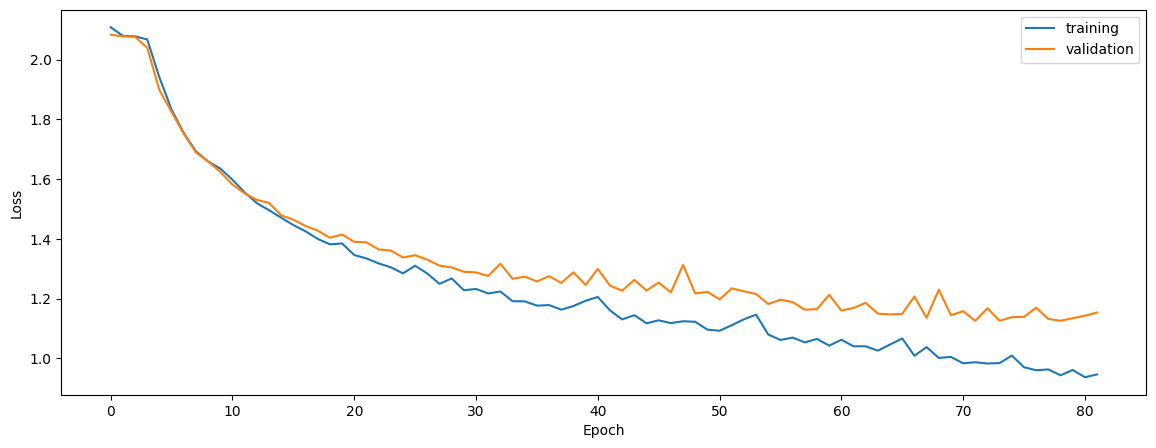

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6330440399662434


0.5822178009164581


0.4923483231431569


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.4925867288994372


0.4928654807742565


0.3863280611172114


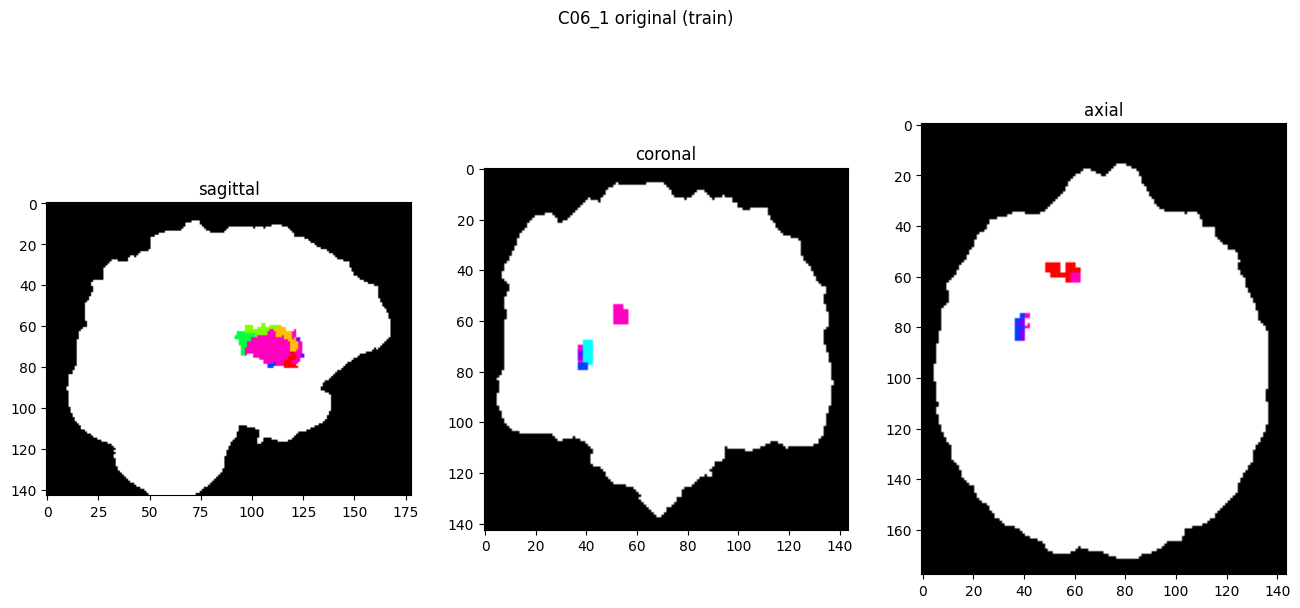

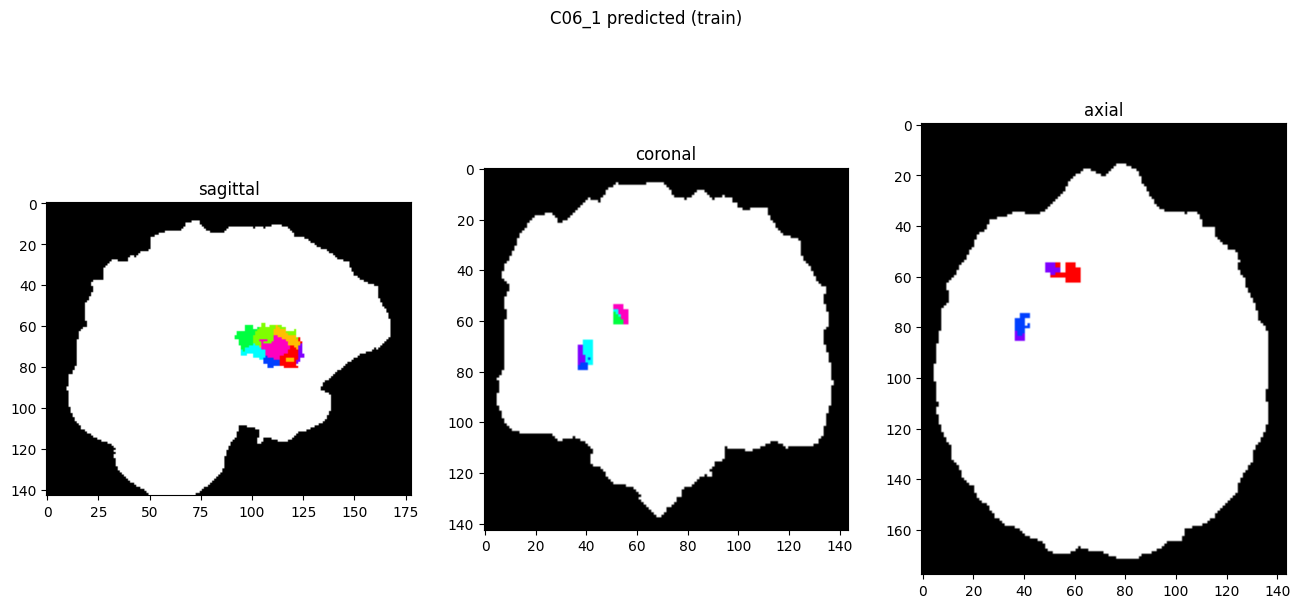

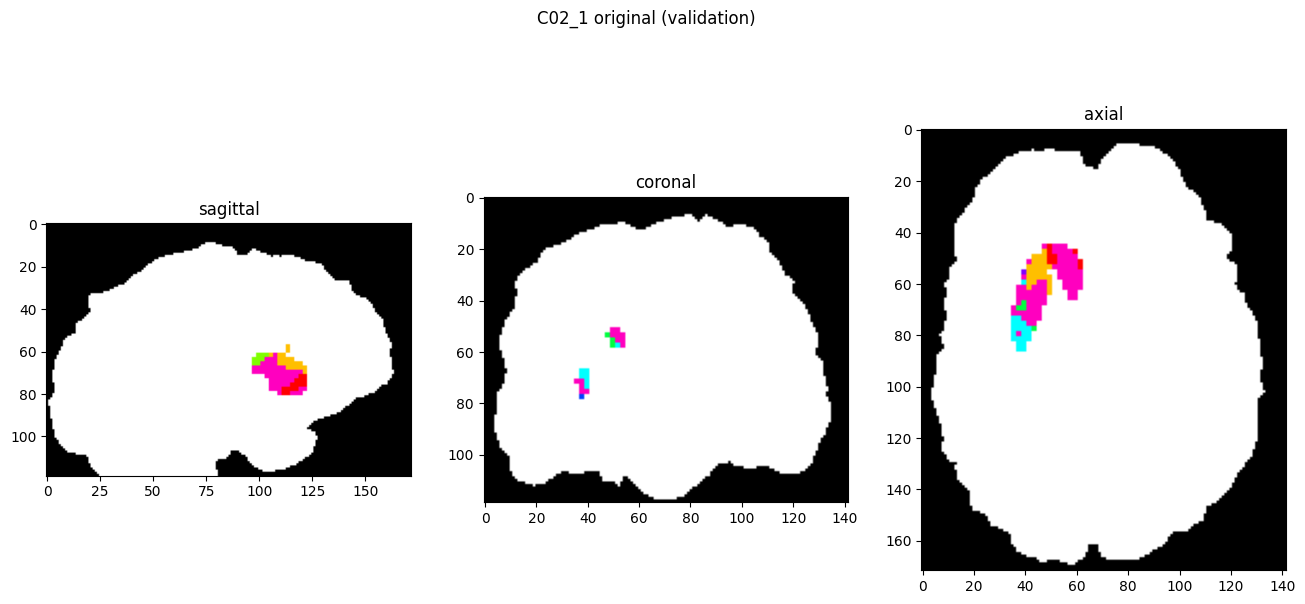

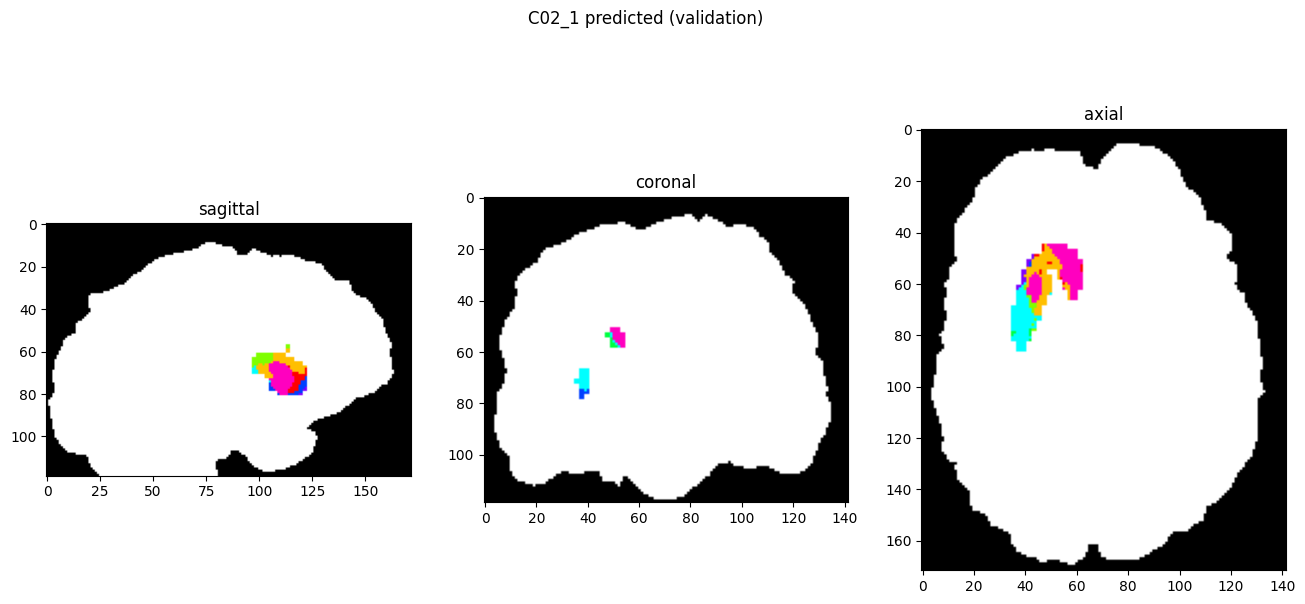

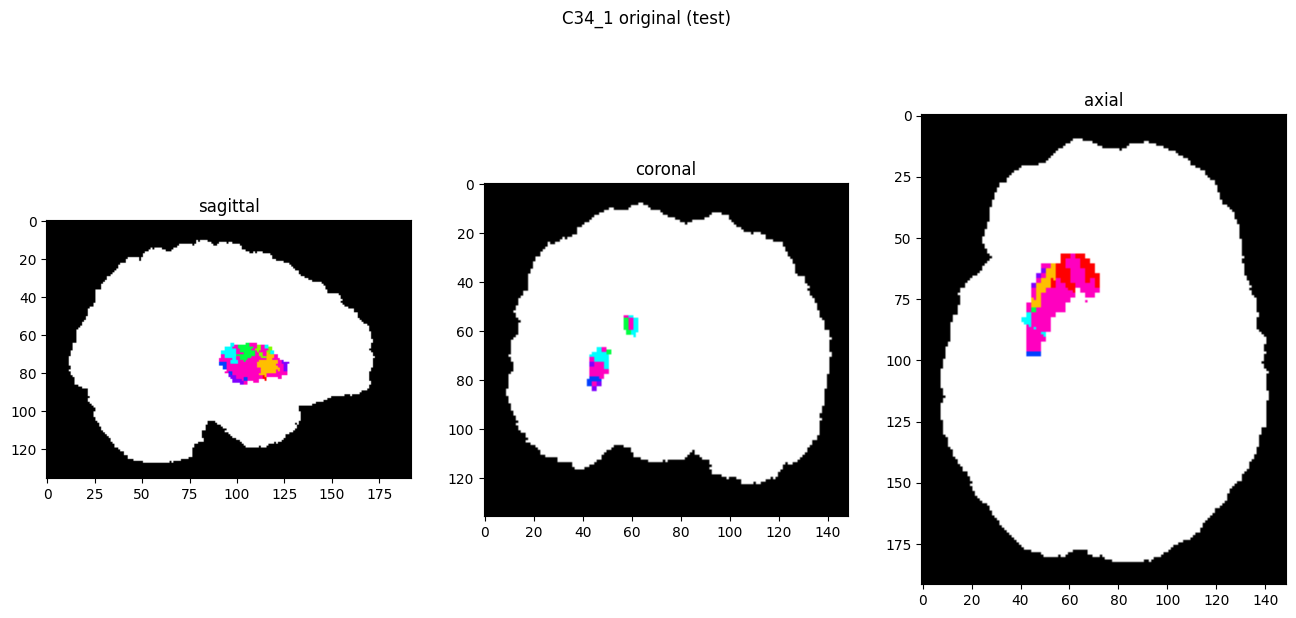

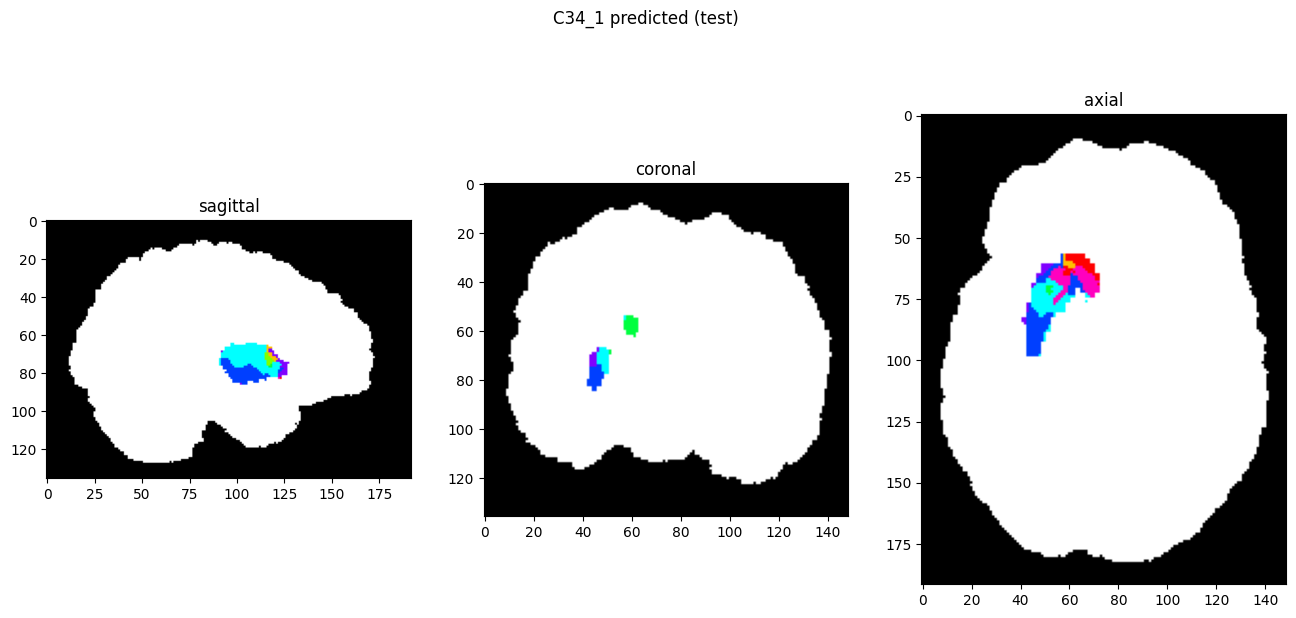

In [9]:
showResults(model, gen, threshold=0)